In [ ]:
# use if you have a gpu
# !pip install cudf-cu11 --extra-index-url=https://pypi.nvidia.com
# import cudf
# %load_ext cudf.pandas

In [ ]:
def classify_value(value):
    for label, interval in occ_labels.items():
        if interval[0] <= value <= interval[1]:
            return label

occ_labels = {'Occ_Class_0': (0, 0)}
j = 1
for i in range(1, 101, 10):
    occ_labels[f'Occ_Class_{j}'] = (i, i + 9)
    j += 1
occ_labels

{'Occ_Class_0': (0, 0),
 'Occ_Class_1': (1, 10),
 'Occ_Class_2': (11, 20),
 'Occ_Class_3': (21, 30),
 'Occ_Class_4': (31, 40),
 'Occ_Class_5': (41, 50),
 'Occ_Class_6': (51, 60),
 'Occ_Class_7': (61, 70),
 'Occ_Class_8': (71, 80),
 'Occ_Class_9': (81, 90),
 'Occ_Class_10': (91, 100)}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import plotly.graph_objects as go
import plotly.express as px
from joblib import Parallel, delayed
import joblib
from collections import Counter

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Concat.csv')

In [ ]:
df.shape # (rows, columns)

(12071, 18)

In [ ]:
df.replace('$', np.nan, inplace = True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['CO (ppm)'] = df['CO (ppm)'].astype('float64')
df['NO2 (ppm)'] = df['NO2 (ppm)'].astype('float64')
df['CO2 (ppm)'] = df['CO2 (ppm)'].astype('float64')
df['Occupancy_Classified'] = df['Occupancy'].apply(classify_value).map(lambda x: int(x.split('_')[2]) - 1)
df = df.query("`Occupancy_Classified` != -1").reset_index(drop = True)

In [ ]:
df.head()

Timestamp  CO (ppm)  NO2 (ppm)  CO2 (ppm)  TVOC (ppb)  \
0 2023-08-16 11:16:33      36.3        0.1     1701.0         0.0   
1 2023-08-16 11:16:38      36.1        0.1     1699.0         0.0   
2 2023-08-16 11:16:44      36.5        0.1     1695.0         0.0   
3 2023-08-16 11:16:50      34.2        0.1     1690.0         0.0   
4 2023-08-16 11:16:55      36.3        0.1     1684.0         0.0   

   PM1 (ug/m3)  PM2.5 (ug/m3)  PM10 (ug/m3)  Temperature (C)  Humidity (%)  \
0         44.0           65.0          70.0             26.1          14.1   
1         44.0           64.0          69.0             26.1          14.1   
2         44.0           64.0          69.0             26.1          14.1   
3         43.0           64.0          68.0             26.1          14.1   
4         43.0           64.0          67.0             26.1          14.0   

   Sound (dB)  Occupancy Position Room Condition Room Type  Floor No. Weather  \
0        72.1       26.0   middle             ac       lab        2.0   sunny   
1        70.5       26.0   middle             ac       lab        2.0   sunny   
2        77.2       26.0   middle             ac       lab        2.0   sunny   
3        72.2       26.0   middle             ac       lab        2.0   sunny   
4        75.3       26.0   middle             ac       lab        2.0   sunny   

   Occupancy_Classified  
0                     2  
1                     2  
2                     2  
3                     2  
4                     2

<Axes: xlabel='Occupancy_Classified'>

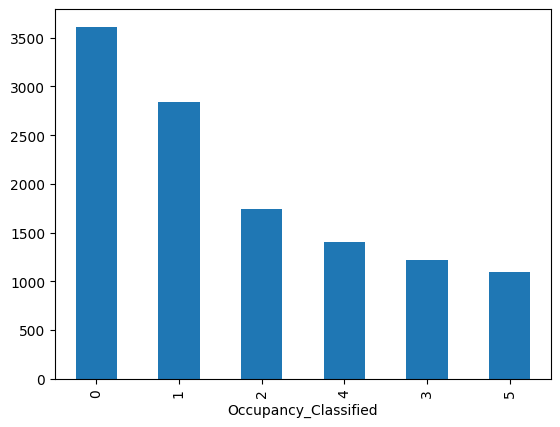

In [ ]:
df['Occupancy_Classified'].value_counts().plot(kind = 'bar')

In [ ]:
# Find the columns which contain strings
for column in df.columns:
    if pd.api.types.is_string_dtype(df[column]):
        print(column)

Position
Room Condition
Room Type
Weather


In [ ]:
{i: pd.api.types.is_string_dtype(df[i]) for i in df.columns}

{'Timestamp': False,
 'CO (ppm)': False,
 'NO2 (ppm)': False,
 'CO2 (ppm)': False,
 'TVOC (ppb)': False,
 'PM1 (ug/m3)': False,
 'PM2.5 (ug/m3)': False,
 'PM10 (ug/m3)': False,
 'Temperature (C)': False,
 'Humidity (%)': False,
 'Sound (dB)': False,
 'Occupancy': False,
 'Position': True,
 'Room Condition': True,
 'Room Type': True,
 'Floor No.': False,
 'Weather': True,
 'Occupancy_Classified': False}

In [ ]:
for column in df.columns:
    if pd.api.types.is_string_dtype(df[column]):
        df[column] = df[column].astype('category').cat.as_ordered()

In [ ]:
# Check missing data ratio percentage

df.isna().sum() * 100.00 / len(df)

Timestamp                0.000000
CO (ppm)                24.962204
NO2 (ppm)               24.962204
CO2 (ppm)                3.855199
TVOC (ppb)               0.000000
PM1 (ug/m3)              0.000000
PM2.5 (ug/m3)            0.000000
PM10 (ug/m3)             0.000000
Temperature (C)          0.000000
Humidity (%)             0.000000
Sound (dB)               0.000000
Occupancy                0.000000
Position                 0.000000
Room Condition           0.000000
Room Type                0.000000
Floor No.                0.000000
Weather                  0.000000
Occupancy_Classified     0.000000
dtype: float64

In [ ]:
df.isna().sum()

Timestamp                  0
CO (ppm)                2972
NO2 (ppm)               2972
CO2 (ppm)                459
TVOC (ppb)                 0
PM1 (ug/m3)                0
PM2.5 (ug/m3)              0
PM10 (ug/m3)               0
Temperature (C)            0
Humidity (%)               0
Sound (dB)                 0
Occupancy                  0
Position                   0
Room Condition             0
Room Type                  0
Floor No.                  0
Weather                    0
Occupancy_Classified       0
dtype: int64

In [ ]:
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        print(column)

CO (ppm)
NO2 (ppm)
CO2 (ppm)
TVOC (ppb)
PM1 (ug/m3)
PM2.5 (ug/m3)
PM10 (ug/m3)
Temperature (C)
Humidity (%)
Sound (dB)
Occupancy
Floor No.
Occupancy_Classified


In [ ]:
# Check for which numeric columns have null values
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]) and df[column].isna().sum():
        print(column)

CO (ppm)
NO2 (ppm)
CO2 (ppm)


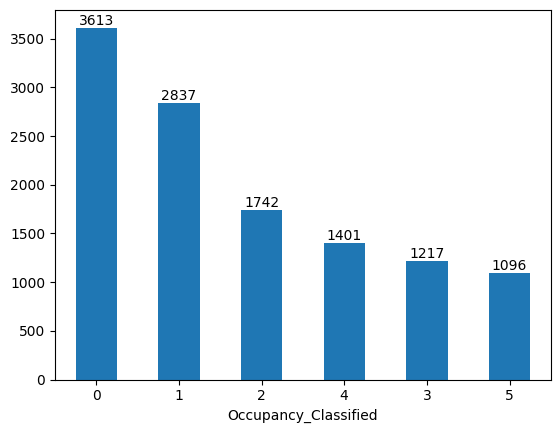

In [ ]:
ax = df['Occupancy_Classified'].value_counts().plot(kind = 'bar')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.xticks(rotation = 0);

In [ ]:
# Dropping all missing rows
new_df = df.dropna().reset_index(drop = True)

In [ ]:
new_df.shape

(8907, 18)

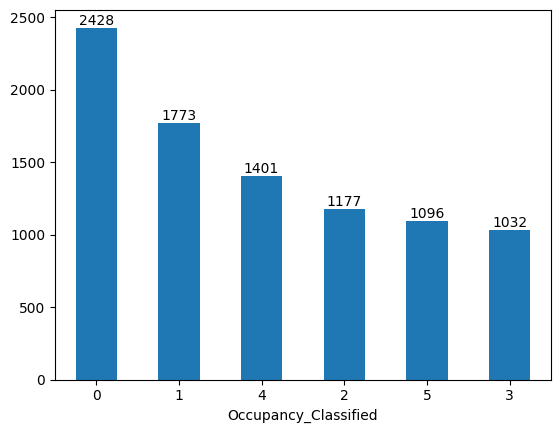

In [ ]:
ax = new_df['Occupancy_Classified'].value_counts().plot(kind = 'bar')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.xticks(rotation = 0);

In [ ]:
# Check for columns which aren't numeric or is categorical
# and print category codes
l = 0
for column in new_df.columns:
    if pd.api.types.is_categorical_dtype(new_df[column]):
        l += 1
        print(f'{column}: {dict(enumerate(df[column].cat.categories))}')
print(l)

Position: {0: 'backside', 1: 'frontside', 2: 'middle'}
Room Condition: {0: 'ac', 1: 'non ac'}
Room Type: {0: 'classroom', 1: 'lab'}
Weather: {0: 'cloudy', 1: 'overcast', 2: 'rainy', 3: 'sunny'}
4


In [ ]:
# Turn all categorical variables into numbers and fill missing
for column in new_df.columns:
    if pd.api.types.is_categorical_dtype(new_df[column]):
        # Turn categories into numbers and add +1
        new_df[column] = pd.Categorical(new_df[column]).codes + 1

# ML

## Original ML Pipeline Module

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import warnings
import time
warnings.filterwarnings("ignore")
np.random.seed(42)

class MultiModelEvaluator:
    def __init__(self, models):
        self.models = models
        self.model_names = list(models.keys())
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.metric_scores = {}

    def split_data(self, X, y, test_size=0.2, random_state=42):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    def train_models(self):
        for model_name, model in self.models.items():
            print(f"\n================================================\n{model_name} model has started training")
            start = time.time()
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', model)
            ])
            pipeline.fit(self.X_train, self.y_train)
            self.models[model_name] = pipeline
            print(f"{model_name} model has ended training. Time -> {round(time.time() - start, 2)}s. Accuracy - > {(pipeline.score(self.X_test, self.y_test) * 100.00):.2f} %\n================================================\n")

    def evaluate_models(self, X_test, y_test):
        for model_name, pipeline in self.models.items():
            Train_y_pred = pipeline.predict(self.X_train)
            Train_accuracy = accuracy_score(self.y_train, Train_y_pred)
            Train_f1_macro = f1_score(self.y_train, Train_y_pred, average='macro')
            Train_f1_weighted = f1_score(self.y_train, Train_y_pred, average='weighted')
            Train_recall_macro = recall_score(self.y_train, Train_y_pred, average='macro')
            Train_recall_weighted = recall_score(self.y_train, Train_y_pred, average='weighted')
            Train_precision_macro = precision_score(self.y_train, Train_y_pred, average='macro')
            Train_precision_weighted = precision_score(self.y_train, Train_y_pred, average='weighted')
            Train_confusion = confusion_matrix(self.y_train, Train_y_pred)

            Test_y_pred = pipeline.predict(X_test)
            Test_accuracy = accuracy_score(y_test, Test_y_pred)
            Test_f1_macro = f1_score(y_test, Test_y_pred, average='macro')
            Test_f1_weighted = f1_score(y_test, Test_y_pred, average='weighted')
            Test_recall_macro = recall_score(y_test, Test_y_pred, average='macro')
            Test_recall_weighted = recall_score(y_test, Test_y_pred, average='weighted')
            Test_precision_macro = precision_score(y_test, Test_y_pred, average='macro')
            Test_precision_weighted = precision_score(y_test, Test_y_pred, average='weighted')
            Test_confusion = confusion_matrix(y_test, Test_y_pred)

            self.metric_scores[model_name] = {
                'Train Accuracy': Train_accuracy,
                'Train F1 Macro': Train_f1_macro,
                'Train F1 Weighted': Train_f1_weighted,
                'Train Recall Macro': Train_recall_macro,
                'Train Recall Weighted': Train_recall_weighted,
                'Train Precision Macro': Train_precision_macro,
                'Train Precision Weighted': Train_precision_weighted,
                'Train Confusion Matrix': Train_confusion,
                'Test Accuracy': Test_accuracy,
                'Test F1 Macro': Test_f1_macro,
                'Test F1 Weighted': Test_f1_weighted,
                'Test Recall Macro': Test_recall_macro,
                'Test Recall Weighted': Test_recall_weighted,
                'Test Precision Macro': Test_precision_macro,
                'Test Precision Weighted': Test_precision_weighted,
                'Test Confusion Matrix': Test_confusion
            }

    def get_metric_scores(self, model_name):
        return self.metric_scores.get(model_name, {})

## Hyper-Tuned Pipeline Module

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import warnings
import numpy as np
import time
warnings.filterwarnings("ignore")
np.random.seed(42)

class MultiModelEvaluatorWithTuning:
    def __init__(self, models, param_grids, n_iter_values = {}, n_jobs_values = {}, verbose_values = {}):
        self.models = models
        self.model_names = list(models.keys())
        self.param_grids = param_grids
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.n_iter_values = n_iter_values
        self.n_jobs_values = n_jobs_values
        self.verbose_values = verbose_values
        self.metric_scores = {}
        self.best_params = {}

    def split_data(self, X, y, test_size=0.2, random_state=42):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    def train_models(self):
        for model_name, model in self.models.items():
            print(f"\n================================================\n{model_name} tuned model has started training")
            start = time.time()
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', model)
            ])
            if model_name not in self.n_iter_values:
                search = GridSearchCV(pipeline, self.param_grids[model_name], cv=5, n_jobs = self.n_jobs_values.get(model_name, -1), verbose = self.verbose_values.get(model_name, 1))
            else:
                search = RandomizedSearchCV(pipeline, self.param_grids[model_name], cv=5, n_jobs = self.n_jobs_values.get(model_name, -1), n_iter = self.n_iter_values.get(model_name, 10), verbose = self.verbose_values.get(model_name, 1))
            search.fit(self.X_train, self.y_train)
            best_model = search.best_estimator_
            self.models[model_name] = best_model
            self.best_params[model_name] = search.best_params_
            print(f"{model_name} tuned model has ended training. Time -> {round(time.time() - start, 2)}s. Accuracy - > {(best_model.score(self.X_test, self.y_test) * 100.00):.2f} %\n================================================\n")


    def evaluate_models(self, X_test, y_test):
        for model_name, pipeline in self.models.items():
            Train_y_pred = pipeline.predict(self.X_train)
            Train_accuracy = accuracy_score(self.y_train, Train_y_pred)
            Train_f1_macro = f1_score(self.y_train, Train_y_pred, average='macro')
            Train_f1_weighted = f1_score(self.y_train, Train_y_pred, average='weighted')
            Train_recall_macro = recall_score(self.y_train, Train_y_pred, average='macro')
            Train_recall_weighted = recall_score(self.y_train, Train_y_pred, average='weighted')
            Train_precision_macro = precision_score(self.y_train, Train_y_pred, average='macro')
            Train_precision_weighted = precision_score(self.y_train, Train_y_pred, average='weighted')
            Train_confusion = confusion_matrix(self.y_train, Train_y_pred)

            Test_y_pred = pipeline.predict(X_test)
            Test_accuracy = accuracy_score(y_test, Test_y_pred)
            Test_f1_macro = f1_score(y_test, Test_y_pred, average='macro')
            Test_f1_weighted = f1_score(y_test, Test_y_pred, average='weighted')
            Test_recall_macro = recall_score(y_test, Test_y_pred, average='macro')
            Test_recall_weighted = recall_score(y_test, Test_y_pred, average='weighted')
            Test_precision_macro = precision_score(y_test, Test_y_pred, average='macro')
            Test_precision_weighted = precision_score(y_test, Test_y_pred, average='weighted')
            Test_confusion = confusion_matrix(y_test, Test_y_pred)

            self.metric_scores[model_name] = {
                'Train Accuracy': Train_accuracy,
                'Train F1 Macro': Train_f1_macro,
                'Train F1 Weighted': Train_f1_weighted,
                'Train Recall Macro': Train_recall_macro,
                'Train Recall Weighted': Train_recall_weighted,
                'Train Precision Macro': Train_precision_macro,
                'Train Precision Weighted': Train_precision_weighted,
                'Train Confusion Matrix': Train_confusion,
                'Test Accuracy': Test_accuracy,
                'Test F1 Macro': Test_f1_macro,
                'Test F1 Weighted': Test_f1_weighted,
                'Test Recall Macro': Test_recall_macro,
                'Test Recall Weighted': Test_recall_weighted,
                'Test Precision Macro': Test_precision_macro,
                'Test Precision Weighted': Test_precision_weighted,
                'Test Confusion Matrix': Test_confusion
            }

    def get_metric_scores(self, model_name):
        return self.metric_scores.get(model_name, {})

    def get_best_params(self, model_name):
        return self.best_params.get(model_name, {})

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

class DeepModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DeepModel, self).__init__()
        layers = []
        in_features = input_size

        # Input normalization
        layers.append(nn.BatchNorm1d(input_size))

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            # Batch normalization for hidden layers
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            in_features = hidden_size

        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

def ann_model(X, y, test_size = 0.2):
    # Evaluate the best model on the test set
    def evaluate_accuracy(model, data_loader):
        model.eval()
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)
        accuracy = total_correct / total_samples
        return accuracy

    # Convert to PyTorch tensors
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    # Convert data to PyTorch dataset
    dataset = data.TensorDataset(X, y)

    # Split the data into train, dev, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)
    X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Create PyTorch DataLoader for each set
    train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    dev_loader = data.DataLoader(data.TensorDataset(X_dev, y_dev), batch_size=32, shuffle=False)
    test_loader = data.DataLoader(data.TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

    # Define hyperparameters to try
    learning_rate = 0.01
    num_epochs = 50

    # Function to train and evaluate the model
    def train_and_evaluate(model, learning_rate):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        # Lists to store convergence data
        train_losses = []
        dev_losses = []
        train_accuracies = []
        dev_accuracies = []

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            # Compute and store losses and accuracies
            train_loss = loss.item()
            train_losses.append(train_loss)
            train_acc = evaluate_accuracy(model, train_loader)
            train_accuracies.append(train_acc)
            dev_acc = evaluate_accuracy(model, dev_loader)
            dev_accuracies.append(dev_acc)
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Dev Accuracy: {dev_acc:.4f}")

        # Plot convergence graph
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, num_epochs + 1), dev_accuracies, label='Dev Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Evaluation
        model.eval()
        total_correct = 0
        total_samples = 0
        predicted_labels = []
        with torch.no_grad():
            for inputs, labels in dev_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)
                predicted_labels.extend(predicted.tolist())

        accuracy = total_correct / total_samples

        # Classification report and F1-score
        print("Classification Report:")
        print(classification_report(y_dev, predicted_labels))
        f1 = f1_score(y_dev, predicted_labels, average='weighted')
        print(f"F1-Score: {f1:.4f}")

        return accuracy

    # Define different configurations for hidden layers and units
    hidden_layers_configs = [
        [16, 8],  # 2 hidden layers with 16 and 8 units
        [32, 16, 8],  # 3 hidden layers with 32, 16, and 8 units
        [64, 32, 16, 8]  # 4 hidden layers with 64, 32, 16, and 8 units
    ]

    # Train and evaluate models with different configurations
    best_accuracy = 0.0
    best_model = None
    for hidden_layers in hidden_layers_configs:
        model = DeepModel(input_size=X.shape[1], hidden_sizes=hidden_layers, output_size=y.shape[0])
        accuracy = train_and_evaluate(model, learning_rate)
        print(f"Hidden layers configuration: {hidden_layers}, Accuracy: {accuracy}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

    print(f"Best model hidden layers configuration: {best_model.layers}, Best accuracy: {best_accuracy}")
    test_accuracy = evaluate_accuracy(best_model, test_loader)
    print(f"Test Accuracy: {test_accuracy}")
    return best_model

In [ ]:
def original_ml_pipeline_obj(x, y, test_size = 0.2):
    # Define the machine learning models
    models = {
        'LogisticRegression': LogisticRegression(solver = 'liblinear'),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(kernel = 'rbf', gamma = 0.1, C = 1.0),
        'Linear SVM': SVC(kernel="linear", C=0.025, random_state=42),
        'DecisionTree': DecisionTreeClassifier(random_state = 42),
        'RandomForest': RandomForestClassifier(n_estimators = 1000, random_state = 42),
        'XGB': XGBClassifier(use_label_encoder = False),
        'LGBM': LGBMClassifier(n_estimators = 1000, random_state = 42, n_jobs = -1, verbosity = -1),
        'GradientBoosting': GradientBoostingClassifier(),
        'MLP Neural Net': MLPClassifier(alpha=1, max_iter=1000, random_state=42),
        "AdaBoost": AdaBoostClassifier(random_state=42),
        "Naive Bayes": GaussianNB(),
        "QDA": QuadraticDiscriminantAnalysis(),
    }

    # Initialize the MultiModelEvaluator
    evaluator = MultiModelEvaluator(models)

    # Split the data into training and testing sets
    evaluator.split_data(x, y, test_size = test_size)

    # Train the models
    evaluator.train_models()

    # Evaluate the models
    evaluator.evaluate_models(evaluator.X_test, evaluator.y_test)

    # Get metric scores for a specific model
    # model_name = 'RandomForest'
    # scores = evaluator.get_metric_scores(model_name)
    # print(f'Metric Scores for Model {model_name}:')
    # for metric, score in scores.items():
    #     print(f'{metric}: {score}')
    return evaluator

In [ ]:
def hyper_tuned_ml_pipeline_obj(x, y, test_size = 0.2):
    # Define the machine learning models
    models = {
        'LogisticRegression': LogisticRegression(solver = 'liblinear'),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(kernel = 'rbf', gamma = 0.1, C = 1.0),
        'Linear SVM': SVC(kernel="linear", C=0.025, random_state=42),
        'DecisionTree': DecisionTreeClassifier(random_state = 42),
        'RandomForest': RandomForestClassifier(n_estimators = 1000, random_state = 42),
        'XGB': XGBClassifier(use_label_encoder = False),
        'LGBM': LGBMClassifier(n_estimators = 1000, random_state = 42, n_jobs = -1, verbosity = -1),
        'GradientBoosting': GradientBoostingClassifier(),
        'MLP Neural Net': MLPClassifier(alpha=1, max_iter=1000, random_state=42),
        "AdaBoost": AdaBoostClassifier(random_state=42),
        "Naive Bayes": GaussianNB(),
        "QDA": QuadraticDiscriminantAnalysis(),
    }

    n_jobs_values = {

    }

    verbose_values = {

    }

    n_iter_values = {
        'RandomForest': 10,
        'XGB': 150,
        'LGBM': 150,
        'MLP Neural Net': 50,
    }

    # Define parameter grids for hyperparameter tuning
    param_grids = {
        'RandomForest': {'classifier__n_estimators': np.arange(100, 3000, 100), 'classifier__max_features': ['auto', 'sqrt'], 'classifier__max_depth': [2, 3, 5, 10, 15, None], 'classifier__min_samples_split': [2, 5, 10], 'classifier__min_samples_leaf': [1, 2, 4]},
        'DecisionTree': {"classifier__criterion":("gini", "entropy"), "classifier__splitter":("best", "random"), "classifier__max_depth":np.arange(1, 21), "classifier__min_samples_split":[2, 3, 4], "classifier__min_samples_leaf":np.arange(1, 21)},
        'GradientBoosting': {'classifier__n_estimators': [50, 100, 200]},
        'KNN': {'classifier__n_neighbors': np.arange(1, 21)},
        'XGB': {'classifier__max_depth': np.arange(1, 21), 'classifier__learning_rate': np.arange(0, 1.1, 0.1)},
        'SVM': {'classifier__C': [0.1, 0.5, 1, 2, 5, 10, 20], 'classifier__kernel': ['rbf'], "classifier__gamma": [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1]},
        'LogisticRegression': {'classifier__C': np.logspace(-4, 4, 20), "classifier__solver": ["liblinear"], 'classifier__penalty': ['l1', 'l2']},
        'LGBM': {'classifier__learning_rate': np.logspace(np.log(0.01), np.log(1), num = 500, base=3), 'classifier__max_depth': np.arange(5, 15), 'classifier__n_estimators': np.arange(5, 35), 'classifier__num_leaves': np.arange(5, 50), 'classifier__boosting_type': ['gbdt', 'dart'], 'classifier__colsample_bytree': np.linspace(0.6, 1, 500),'classifier__reg_lambda': np.linspace(0, 1, 500)},
        'AdaBoost' : {'classifier__n_estimators': [10, 50, 100, 500], 'classifier__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0], 'classifier__random_state': [42]},
        'Naive Bayes': {'classifier__var_smoothing': np.logspace(0,-9, num=100)},
        'MLP Neural Net': {'classifier__hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)], 'classifier__max_iter': [50, 100, 150],
                           'classifier__activation': ['tanh', 'relu'], 'classifier__solver': ['lbfgs', 'adam'], 'classifier__alpha': [0.0001, 0.05],
                           'classifier__learning_rate': ['constant','adaptive'], 'classifier__random_state': [42]},
        'QDA': {'classifier__reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]},
        'Linear SVM': {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear']}
        }

    # Initialize the MultiModelEvaluatorWithTuning
    evaluator = MultiModelEvaluatorWithTuning(models, param_grids, n_iter_values = n_iter_values, n_jobs_values = n_jobs_values, verbose_values = verbose_values)

    # Split the data into training and testing sets
    evaluator.split_data(x, y, test_size = test_size)

    # Train the models with hyperparameter tuning
    evaluator.train_models()

    # Evaluate the models
    evaluator.evaluate_models(evaluator.X_test, evaluator.y_test)

    # Get metric scores for a specific model
    # model_name = 'RandomForest'
    # scores = evaluator_tuned.get_metric_scores(model_name)
    # print(f'Metric Scores for Model {model_name}:')
    # for metric, score in scores.items():
    #     print(f'{metric}: {score}')

    return evaluator

In [ ]:
def evaluate_result(evaluator):
    result = {'Model Name': [], 'Train Accuracy': [], 'Train F1 Macro': [], 'Train F1 Weighted': [], 'Train Recall Macro': [],
              'Train Recall Weighted': [], 'Train Precision Macro': [], 'Train Precision Weighted': [],
              'Test Accuracy': [], 'Test F1 Macro': [], 'Test F1 Weighted': [], 'Test Recall Macro': [],
              'Test Recall Weighted': [], 'Test Precision Macro': [], 'Test Precision Weighted': []
              }

    for model_name in evaluator.metric_scores:
        result['Model Name'].append(model_name)
        for metric_name in list(result.keys())[1:]:
            result[metric_name].append(round(evaluator.metric_scores[model_name][metric_name] * 100.00, 2))

    result = pd.DataFrame(result).T
    result.rename(columns=result.iloc[0], inplace = True)
    result.drop(result.index[0], inplace = True)
    result.index = pd.MultiIndex.from_tuples(
        [('Train', metric.replace('Train ', '')) if i < 7 else ('Test', metric.replace('Test ', '')) for i, metric in enumerate(result.index)],
        names=['', 'Metrics'])
    result.index.names = ['',  'Metrics']
    return result

In [ ]:
def evaluate_ann(model, X_train, X_test, y_train, y_test):
    model.eval()
    with torch.no_grad():
        Train_y_pred = torch.max(model(torch.tensor(X_train, dtype=torch.float32)), 1)[1].numpy()
    Train_accuracy = accuracy_score(y_train, Train_y_pred)
    Train_f1_macro = f1_score(y_train, Train_y_pred, average='macro')
    Train_f1_weighted = f1_score(y_train, Train_y_pred, average='weighted')
    Train_recall_macro = recall_score(y_train, Train_y_pred, average='macro')
    Train_recall_weighted = recall_score(y_train, Train_y_pred, average='weighted')
    Train_precision_macro = precision_score(y_train, Train_y_pred, average='macro')
    Train_precision_weighted = precision_score(y_train, Train_y_pred, average='weighted')
    Train_confusion = confusion_matrix(y_train, Train_y_pred)

    model.eval()
    with torch.no_grad():
        Test_y_pred = torch.max(model(torch.tensor(X_test, dtype=torch.float32)), 1)[1].numpy()
    Test_accuracy = accuracy_score(y_test, Test_y_pred)
    Test_f1_macro = f1_score(y_test, Test_y_pred, average='macro')
    Test_f1_weighted = f1_score(y_test, Test_y_pred, average='weighted')
    Test_recall_macro = recall_score(y_test, Test_y_pred, average='macro')
    Test_recall_weighted = recall_score(y_test, Test_y_pred, average='weighted')
    Test_precision_macro = precision_score(y_test, Test_y_pred, average='macro')
    Test_precision_weighted = precision_score(y_test, Test_y_pred, average='weighted')
    Test_confusion = confusion_matrix(y_test, Test_y_pred)

    metrics = {
                    'Train Accuracy': Train_accuracy,
                    'Train F1 Macro': Train_f1_macro,
                    'Train F1 Weighted': Train_f1_weighted,
                    'Train Recall Macro': Train_recall_macro,
                    'Train Recall Weighted': Train_recall_weighted,
                    'Train Precision Macro': Train_precision_macro,
                    'Train Precision Weighted': Train_precision_weighted,
                    'Train Confusion Matrix': Train_confusion,
                    'Test Accuracy': Test_accuracy,
                    'Test F1 Macro': Test_f1_macro,
                    'Test F1 Weighted': Test_f1_weighted,
                    'Test Recall Macro': Test_recall_macro,
                    'Test Recall Weighted': Test_recall_weighted,
                    'Test Precision Macro': Test_precision_macro,
                    'Test Precision Weighted': Test_precision_weighted,
                    'Test Confusion Matrix': Test_confusion
                }

    result = {'Model Name': [], 'Train Accuracy': [], 'Train F1 Macro': [], 'Train F1 Weighted': [], 'Train Recall Macro': [],
              'Train Recall Weighted': [], 'Train Precision Macro': [], 'Train Precision Weighted': [],
              'Test Accuracy': [], 'Test F1 Macro': [], 'Test F1 Weighted': [], 'Test Recall Macro': [],
              'Test Recall Weighted': [], 'Test Precision Macro': [], 'Test Precision Weighted': []
              }
    result['Model Name'].append('ANN')
    for metric_name in list(result.keys())[1:]:
        result[metric_name].append(round(metrics[metric_name] * 100.00, 2))

    result = pd.DataFrame(result).T
    result.rename(columns=result.iloc[0], inplace = True)
    result.drop(result.index[0], inplace = True)
    result.index = pd.MultiIndex.from_tuples(
        [('Train', metric.replace('Train ', '')) if i < 7 else ('Test', metric.replace('Test ', '')) for i, metric in enumerate(result.index)],
        names=['', 'Metrics'])
    result.index.names = ['',  'Metrics']
    return metrics, result

In [ ]:
def plot_feature_importances(models, model_names, feature_names):
    """
    Plot feature importances for a list of machine learning models.

    Parameters:
    - models (list): List of trained models.
    - model_names (list): Names of the models for labeling in the plot.
    - feature_names (list): Names of the features for labeling in the plot.

    Returns:
    - None
    """
    num_models = len(models)
    num_features = len(feature_names)

    for i in range(num_models):
        plt.figure(figsize=(10, 6))

        if isinstance(models[i], DecisionTreeClassifier) or isinstance(models[i], RandomForestClassifier):
            importances = models[i].feature_importances_
        elif isinstance(models[i], XGBClassifier) or isinstance(models[i], AdaBoostClassifier):
            importances = models[i].feature_importances_
        elif isinstance(models[i], LGBMClassifier):
            importances = models[i].feature_importances_
        elif isinstance(models[i], LogisticRegression):
            importances = np.abs(models[i].coef_[0])
        elif isinstance(models[i], MLPClassifier):
            importances = [np.sum(np.abs(layer), axis=1) for layer in [layer / np.linalg.norm(layer, ord=2, axis=0)
                            for layer in models[i].coefs_]][0]
        # elif isinstance(models[i], KNeighborsClassifier) or isinstance(models[i], SVC):
        #     importances = [1] * num_features  # KNN and SVM doesn't have feature importance, for instance let's say every feature importance is equal
        elif isinstance(models[i], GradientBoostingClassifier):
            importances = models[i].feature_importances_
        else:
            pass  # KNN, SVM, Naive Bayes and QDA doesn't have feature importance
            # raise ValueError(f"Unsupported model type: {type(models[i])}")

        # Sort feature importances in descending order
        sorted_indices = np.argsort(importances)[::-1]
        sorted_importances = [importances[idx] for idx in sorted_indices]  # Convert to a list of values
        sorted_feature_names = [feature_names[idx] for idx in sorted_indices]

        plt.bar(range(num_features), sorted_importances, tick_label=sorted_feature_names)
        plt.title(f'Feature Importances for {model_names[i]}')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

In [ ]:
# for feature scaling
from sklearn.preprocessing import StandardScaler
st_x = StandardScaler()

* Position: {1: 'backside', 2: 'frontside', 3: 'middle'}
* Room Condition: {1: 'ac', 2: 'non ac'}
* Room Type: {1: 'classroom', 2: 'lab'}
* Weather: {1: 'cloudy', 2: 'overcast', 3: 'rainy', 4: 'sunny'}


- Lab has always ac
- Classroom has ac and non-ac

## AC Lab ML Machine Learning Model

In [ ]:
# Preparing data for ML
df_tmp = new_df.query("`Room Type` == 2")[['CO2 (ppm)', 'PM1 (ug/m3)', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'Temperature (C)', 'Humidity (%)', 'Position', 'Room Condition', 'Room Type', 'Floor No.', 'Weather', 'Occupancy_Classified']].drop(["Room Condition", "Room Type"], axis = 1)

In [ ]:
# Split data into x and y
ac_lab_x = df_tmp.drop('Occupancy_Classified', axis = 1)
ac_lab_y = df_tmp['Occupancy_Classified'].values  # converting to numpy array

# Scaling input variables, output variables doens't required as we are just predicting discrete outcomes
ac_lab_x = st_x.fit_transform(ac_lab_x)

In [ ]:
# @title Experimenting our dataset with Dimension Reduction Techniques (t-SNE)

!pip install openTSNE
from openTSNE import TSNE
n = 4

ac_lab_x = df_tmp.drop('Occupancy_Classified', axis = 1).to_numpy()
ac_lab_y = df_tmp['Occupancy_Classified'].values  # converting to numpy array

model = TSNE(
    n_components = n,
    perplexity=25,
    metric="euclidean",
    n_jobs=-1,
    random_state=42,
    verbose=True,
)
tsne_data = model.fit(ac_lab_x)
tsne_data = np.vstack((tsne_data.T, ac_lab_y)).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns = [f'Dim_{i}' for i in range(1, n + 1)] + ['label'])
sns.pairplot(tsne_df, hue='label', palette="bright")
plt.show()


tsne_df.corr()['label']


# evaluator_ac_lab = original_ml_pipeline_obj(tsne_df.drop('label', axis = 1), tsne_df['label'], test_size = 0.4)


# result_ac_lab = evaluate_result(evaluator_ac_lab)
# result_ac_lab


# metric_to_show = 'Accuracy'
# ax = result_ac_lab.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(marker='o', figsize=(14, 8))
# plt.title(f'Train and Test {metric_to_show} for Different Models')
# plt.xlabel('Model')
# plt.ylabel(metric_to_show)
# plt.xticks(np.arange(len(result_ac_lab.columns.to_numpy())), result_ac_lab.columns.to_numpy(), rotation=90)
# plt.legend(loc='best')
# plt.grid(True)
# plt.show()


# ann_model_ac_lab = ann_model(tsne_data[:, :3], tsne_data[:, 3], test_size = 0.4)
# evaluate_ann(ann_model_ac_lab, *train_test_split(tsne_data[:, :3], tsne_data[:, 3], test_size=0.4, random_state=42))[1]

In [ ]:
evaluator_ac_lab = original_ml_pipeline_obj(ac_lab_x, ac_lab_y, test_size = 0.4)


LogisticRegression model has started training
LogisticRegression model has ended training. Time -> 0.04s. Accuracy - > 76.65 %


KNN model has started training
KNN model has ended training. Time -> 0.01s. Accuracy - > 93.99 %


SVM model has started training
SVM model has ended training. Time -> 0.1s. Accuracy - > 83.67 %


Linear SVM model has started training
Linear SVM model has ended training. Time -> 0.11s. Accuracy - > 73.94 %


DecisionTree model has started training
DecisionTree model has ended training. Time -> 0.01s. Accuracy - > 97.29 %


RandomForest model has started training
RandomForest model has ended training. Time -> 3.26s. Accuracy - > 98.41 %


XGB model has started training
XGB model has ended training. Time -> 1.98s. Accuracy - > 98.17 %


LGBM model has started training
LGBM model has ended training. Time -> 4.11s. Accuracy - > 97.70 %


GradientBoosting model has started training
GradientBoosting model has ended training. Time -> 2.81s. Accuracy - > 97.88 %


M

In [ ]:
result_ac_lab = evaluate_result(evaluator_ac_lab)
result_ac_lab

LogisticRegression    KNN    SVM Linear SVM  \
      Metrics                                                          
Train Accuracy                        75.18  97.29  83.32      73.25   
      F1 Macro                        60.59  96.02  75.55      53.63   
      F1 Weighted                     72.13  97.28  82.42       69.2   
      Recall Macro                    60.89  95.45  72.76      56.39   
      Recall Weighted                 75.18  97.29  83.32      73.25   
      Precision Macro                 67.28  96.65  86.75      52.53   
      Precision Weighted              71.66  97.29  84.91      66.94   
Test  Accuracy                        76.65  93.99  83.67      73.94   
      F1 Macro                        61.96  90.37   74.4      53.66   
      F1 Weighted                     73.78  93.96  82.78      70.18   
      Recall Macro                    61.53  89.84  71.37      55.85   
      Recall Weighted                 76.65  93.99  83.67      73.94   
      Precision Macro                 68.13  90.96  86.34      53.12   
      Precision Weighted              72.93  93.96  85.18      68.18   

                         DecisionTree RandomForest    XGB   LGBM  \
      Metrics                                                      
Train Accuracy                  100.0        100.0  99.92  99.84   
      F1 Macro                  100.0        100.0  99.79  99.73   
      F1 Weighted               100.0        100.0  99.92  99.84   
      Recall Macro              100.0        100.0  99.79  99.88   
      Recall Weighted           100.0        100.0  99.92  99.84   
      Precision Macro           100.0        100.0  99.79  99.59   
      Precision Weighted        100.0        100.0  99.92  99.84   
Test  Accuracy                  97.29        98.41  98.17   97.7   
      F1 Macro                  95.39        97.78  97.11  96.68   
      F1 Weighted               97.29        98.41  98.17   97.7   
      Recall Macro               95.3        97.68  96.87  96.45   
      Recall Weighted           97.29        98.41  98.17   97.7   
      Precision Macro           95.54        97.91  97.38  96.94   
      Precision Weighted        97.32        98.42  98.19  97.72   

                         GradientBoosting MLP Neural Net AdaBoost Naive Bayes  \
      Metrics                                                                   
Train Accuracy                      100.0          86.31    42.25       56.45   
      F1 Macro                      100.0          79.19    22.97       41.23   
      F1 Weighted                   100.0          85.64    31.42        50.4   
      Recall Macro                  100.0          77.41    33.63       50.38   
      Recall Weighted               100.0          86.31    42.25       56.45   
      Precision Macro               100.0          85.67    18.26       58.89   
      Precision Weighted            100.0          87.01    26.59       64.75   
Test  Accuracy                      97.88           86.5    43.51       57.49   
      F1 Macro                      96.58          78.88    23.29       41.67   
      F1 Weighted                   97.87          85.87    33.21       52.43   
      Recall Macro                   96.0          77.28    33.61       51.34   
      Recall Weighted               97.88           86.5    43.51       57.49   
      Precision Macro               97.26          84.01    18.84       58.82   
      Precision Weighted            97.89          86.93    28.76       66.36   

                            QDA  
      Metrics                    
Train Accuracy             33.4  
      F1 Macro             7.15  
      F1 Weighted         16.72  
      Recall Macro        14.29  
      Recall Weighted      33.4  
      Precision Macro      4.77  
      Precision Weighted  11.15  
Test  Accuracy            34.91  
      F1 Macro             7.39  
      F1 Weighted         18.06  
      Recall Macro        14.29  
      Recall Weighted     34.91  
      Prec

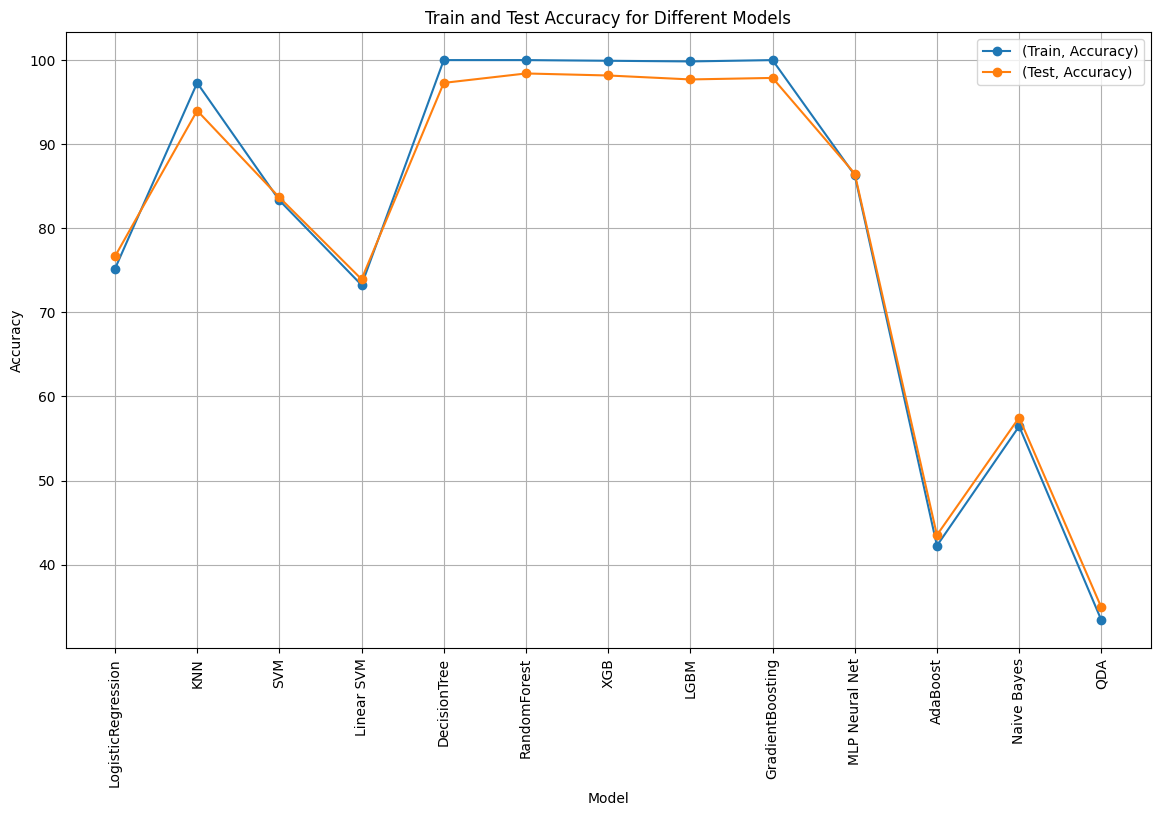

In [ ]:
metric_to_show = 'Accuracy'

ax = result_ac_lab.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(marker='o', figsize=(14, 8))
plt.title(f'Train and Test {metric_to_show} for Different Models')
plt.xlabel('Model')
plt.ylabel(metric_to_show)
plt.xticks(np.arange(len(result_ac_lab.columns.to_numpy())), result_ac_lab.columns.to_numpy(), rotation=90)
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
evaluator_ac_lab_hyper_tuned = hyper_tuned_ml_pipeline_obj(ac_lab_x, ac_lab_y, test_size = 0.4)


LogisticRegression tuned model has started training
Fitting 5 folds for each of 40 candidates, totalling 200 fits
LogisticRegression tuned model has ended training. Time -> 109.5s. Accuracy - > 78.24 %


KNN tuned model has started training
Fitting 5 folds for each of 20 candidates, totalling 100 fits
KNN tuned model has ended training. Time -> 5.01s. Accuracy - > 96.52 %


SVM tuned model has started training
Fitting 5 folds for each of 49 candidates, totalling 245 fits
SVM tuned model has ended training. Time -> 28.6s. Accuracy - > 93.93 %


Linear SVM tuned model has started training
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Linear SVM tuned model has ended training. Time -> 2.17s. Accuracy - > 86.32 %


DecisionTree tuned model has started training
Fitting 5 folds for each of 4800 candidates, totalling 24000 fits
DecisionTree tuned model has ended training. Time -> 138.99s. Accuracy - > 96.82 %


RandomForest tuned model has started training
Fitting 5 folds for e

In [ ]:
result_ac_lab_hyper_tuned = evaluate_result(evaluator_ac_lab_hyper_tuned)
result_ac_lab_hyper_tuned

LogisticRegression    KNN    SVM Linear SVM  \
      Metrics                                                          
Train Accuracy                        77.62  100.0  95.83      86.15   
      F1 Macro                        70.58  100.0  94.37      80.13   
      F1 Weighted                     75.69  100.0  95.82      85.09   
      Recall Macro                    70.03  100.0  93.44      77.99   
      Recall Weighted                 77.62  100.0  95.83      86.15   
      Precision Macro                 75.52  100.0  95.51      88.78   
      Precision Weighted              76.01  100.0  95.89      86.75   
Test  Accuracy                        78.24  96.52  93.93      86.32   
      F1 Macro                        69.87  95.01  91.52      80.41   
      F1 Weighted                     76.42  96.52  93.96      85.46   
      Recall Macro                    68.92  95.14  91.13      78.23   
      Recall Weighted                 78.24  96.52  93.93      86.32   
      Precision Macro                 75.92  94.89  92.09      88.26   
      Precision Weighted              77.03  96.53  94.05      87.04   

                         DecisionTree RandomForest    XGB   LGBM  \
      Metrics                                                      
Train Accuracy                  100.0        99.57  99.92  99.84   
      F1 Macro                  100.0         99.4  99.79  99.73   
      F1 Weighted               100.0        99.57  99.92  99.84   
      Recall Macro              100.0        99.34  99.79  99.88   
      Recall Weighted           100.0        99.57  99.92  99.84   
      Precision Macro           100.0        99.47  99.79  99.59   
      Precision Weighted        100.0        99.57  99.92  99.84   
Test  Accuracy                  96.82        97.88  98.23  97.88   
      F1 Macro                  94.21        97.41  97.22  97.05   
      F1 Weighted               96.79        97.88  98.23  97.88   
      Recall Macro              93.37        97.45  96.96  96.88   
      Recall Weighted           96.82        97.88  98.23  97.88   
      Precision Macro           95.27        97.41  97.51  97.24   
      Precision Weighted        96.81        97.91  98.24  97.89   

                         GradientBoosting MLP Neural Net AdaBoost Naive Bayes  \
      Metrics                                                                   
Train Accuracy                      100.0          97.25    69.79       65.38   
      F1 Macro                      100.0          95.69    53.34       60.57   
      F1 Weighted                   100.0          97.23    66.48       65.16   
      Recall Macro                  100.0          94.71    55.56       64.78   
      Recall Weighted               100.0          97.25    69.79       65.38   
      Precision Macro               100.0          96.87    58.95       65.15   
      Precision Weighted            100.0          97.29    67.37        68.9   
Test  Accuracy                      97.82          94.93    71.17       64.45   
      F1 Macro                      96.53          91.72    54.42       58.22   
      F1 Weighted                   97.81          94.88    68.36       64.65   
      Recall Macro                  95.93          90.65    55.72       63.22   
      Recall Weighted               97.82          94.93    71.17       64.45   
      Precision Macro               97.24          92.97    63.21       62.25   
      Precision Weighted            97.84           94.9    70.74       68.73   

                            QDA  
      Metrics                    
Train Accuracy            70.02  
      F1 Macro            59.54  
      F1 Weighted         68.01  
      Recall Macro        63.49  
      Recall Weighted     70.02  
      Precision Macro      59.2  
      Precision Weighted  67.77  
Test  Accuracy            69.99  
      F1 Macro            58.62  
      F1 Weighted         68.33  
      Recall Macro        63.06  
      Recall Weighted     69.99  
      Prec

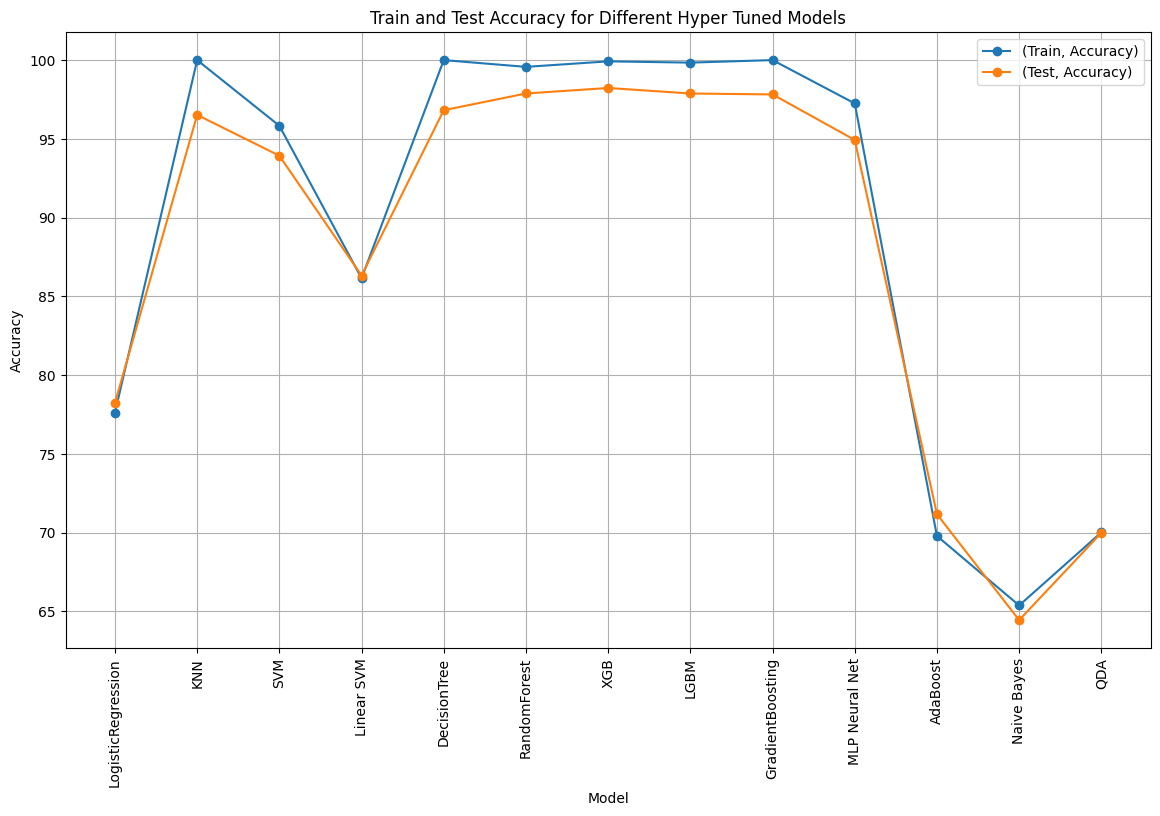

In [ ]:
metric_to_show = 'Accuracy'

result_ac_lab_hyper_tuned.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(marker='o', figsize=(14, 8))
plt.title(f'Train and Test {metric_to_show} for Different Hyper Tuned Models')
plt.xlabel('Model')
plt.ylabel(metric_to_show)
plt.xticks(np.arange(len(result_ac_lab_hyper_tuned.columns.to_numpy())), result_ac_lab_hyper_tuned.columns.to_numpy(), rotation=90)
plt.legend(loc='best')
plt.grid(True)
plt.show()

Epoch 1/50, Train Loss: 7.5679, Train Accuracy: 0.3088, Dev Accuracy: 0.3090
Epoch 2/50, Train Loss: 6.4552, Train Accuracy: 0.3812, Dev Accuracy: 0.3620
Epoch 3/50, Train Loss: 5.2430, Train Accuracy: 0.4555, Dev Accuracy: 0.4528
Epoch 4/50, Train Loss: 3.7336, Train Accuracy: 0.4500, Dev Accuracy: 0.4281
Epoch 5/50, Train Loss: 3.4900, Train Accuracy: 0.4772, Dev Accuracy: 0.4505
Epoch 6/50, Train Loss: 3.0107, Train Accuracy: 0.4941, Dev Accuracy: 0.4682
Epoch 7/50, Train Loss: 1.8069, Train Accuracy: 0.6424, Dev Accuracy: 0.6533
Epoch 8/50, Train Loss: 1.0936, Train Accuracy: 0.6900, Dev Accuracy: 0.6969
Epoch 9/50, Train Loss: 0.9546, Train Accuracy: 0.7781, Dev Accuracy: 0.7689
Epoch 10/50, Train Loss: 2.1245, Train Accuracy: 0.7789, Dev Accuracy: 0.7748
Epoch 11/50, Train Loss: 1.7963, Train Accuracy: 0.8029, Dev Accuracy: 0.8031
Epoch 12/50, Train Loss: 0.5580, Train Accuracy: 0.7939, Dev Accuracy: 0.7830
Epoch 13/50, Train Loss: 0.5155, Train Accuracy: 0.7974, Dev Accuracy: 0.

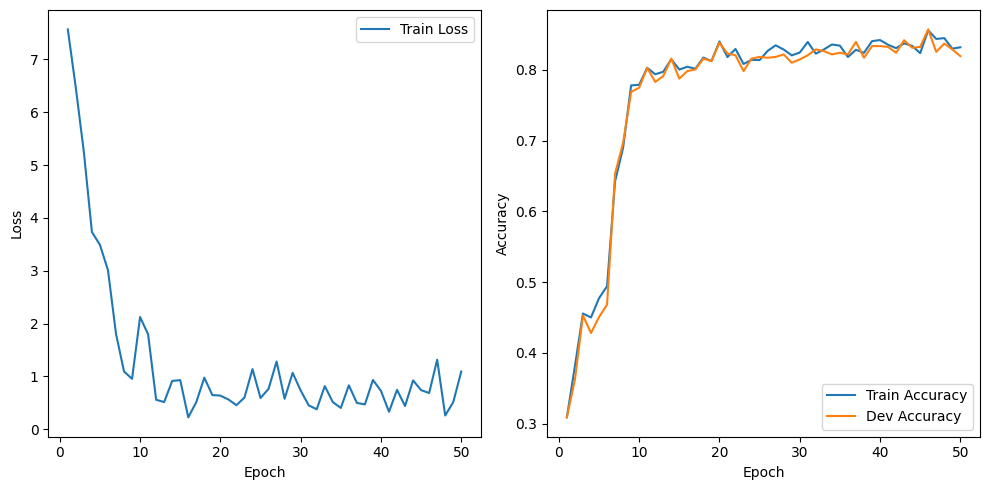

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       292
           1       0.78      0.79      0.78       110
           2       0.82      0.85      0.83       152
           3       0.95      0.81      0.87        73
           4       0.83      0.31      0.45        49
           5       0.73      0.84      0.78       148
           6       0.00      0.00      0.00        24

    accuracy                           0.82       848
   macro avg       0.71      0.65      0.66       848
weighted avg       0.80      0.82      0.80       848

F1-Score: 0.8002
Hidden layers configuration: [16, 8], Accuracy: 0.8195754716981132
Epoch 1/50, Train Loss: 7.4726, Train Accuracy: 0.3006, Dev Accuracy: 0.2771
Epoch 2/50, Train Loss: 6.1961, Train Accuracy: 0.5268, Dev Accuracy: 0.5024
Epoch 3/50, Train Loss: 4.4576, Train Accuracy: 0.5732, Dev Accuracy: 0.5401
Epoch 4/50, Train Loss: 2.5779, Train Accuracy: 0.5814, Dev Accur

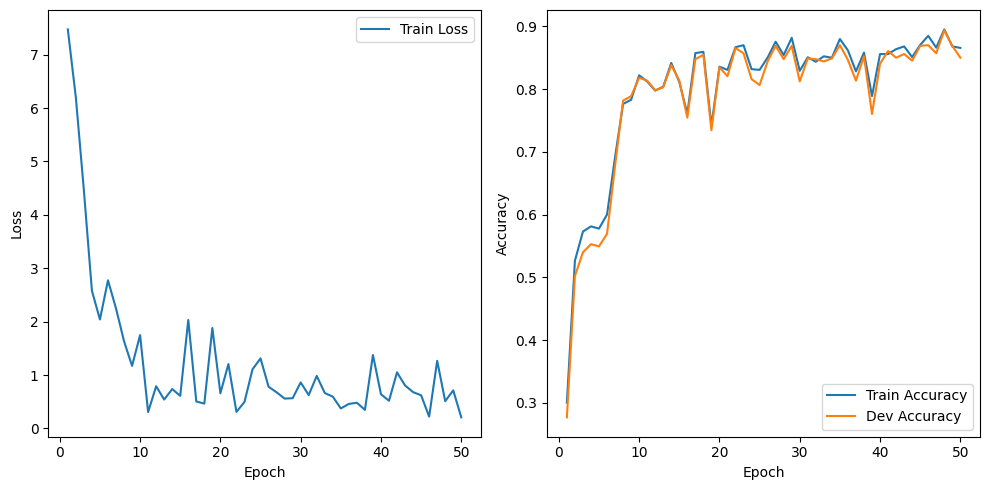

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95       292
           1       0.74      0.81      0.77       110
           2       0.80      0.84      0.82       152
           3       0.96      0.89      0.92        73
           4       0.83      0.39      0.53        49
           5       0.74      0.99      0.85       148
           6       1.00      0.25      0.40        24

    accuracy                           0.85       848
   macro avg       0.86      0.73      0.75       848
weighted avg       0.86      0.85      0.84       848

F1-Score: 0.8424
Hidden layers configuration: [32, 16, 8], Accuracy: 0.8502358490566038
Epoch 1/50, Train Loss: 7.3063, Train Accuracy: 0.1459, Dev Accuracy: 0.1285
Epoch 2/50, Train Loss: 6.3056, Train Accuracy: 0.6743, Dev Accuracy: 0.6686
Epoch 3/50, Train Loss: 5.9427, Train Accuracy: 0.6998, Dev Accuracy: 0.6863
Epoch 4/50, Train Loss: 2.8393, Train Accuracy: 0.7065, Dev A

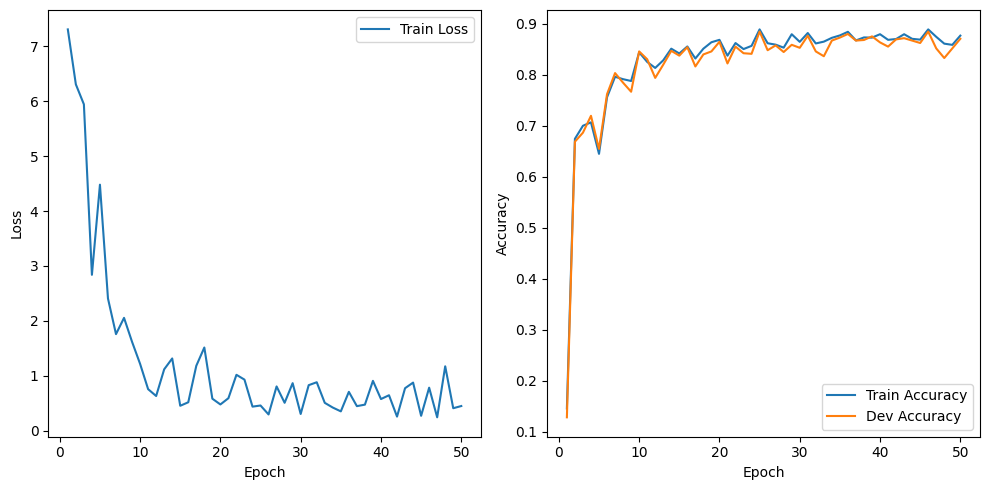

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       292
           1       0.73      0.85      0.79       110
           2       0.90      0.80      0.84       152
           3       0.96      0.89      0.92        73
           4       0.65      0.53      0.58        49
           5       0.85      0.91      0.88       148
           6       0.74      0.83      0.78        24

    accuracy                           0.87       848
   macro avg       0.83      0.82      0.82       848
weighted avg       0.87      0.87      0.87       848

F1-Score: 0.8697
Hidden layers configuration: [64, 32, 16, 8], Accuracy: 0.8702830188679245
Best model hidden layers configuration: Sequential(
  (0): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=9, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3):

In [ ]:
ann_model_ac_lab = ann_model(ac_lab_x, ac_lab_y, test_size = 0.4)

In [ ]:
evaluate_ann(ann_model_ac_lab, *train_test_split(ac_lab_x, ac_lab_y, test_size=0.4, random_state=42))[1]

ANN
      Metrics                  
Train Accuracy            88.12
      F1 Macro            82.65
      F1 Weighted         87.59
      Recall Macro        80.43
      Recall Weighted     88.12
      Precision Macro     87.01
      Precision Weighted   88.5
Test  Accuracy            87.38
      F1 Macro            81.12
      F1 Weighted         86.96
      Recall Macro        78.81
      Recall Weighted     87.38
      Precision Macro     85.23
      Precision Weighted   87.7

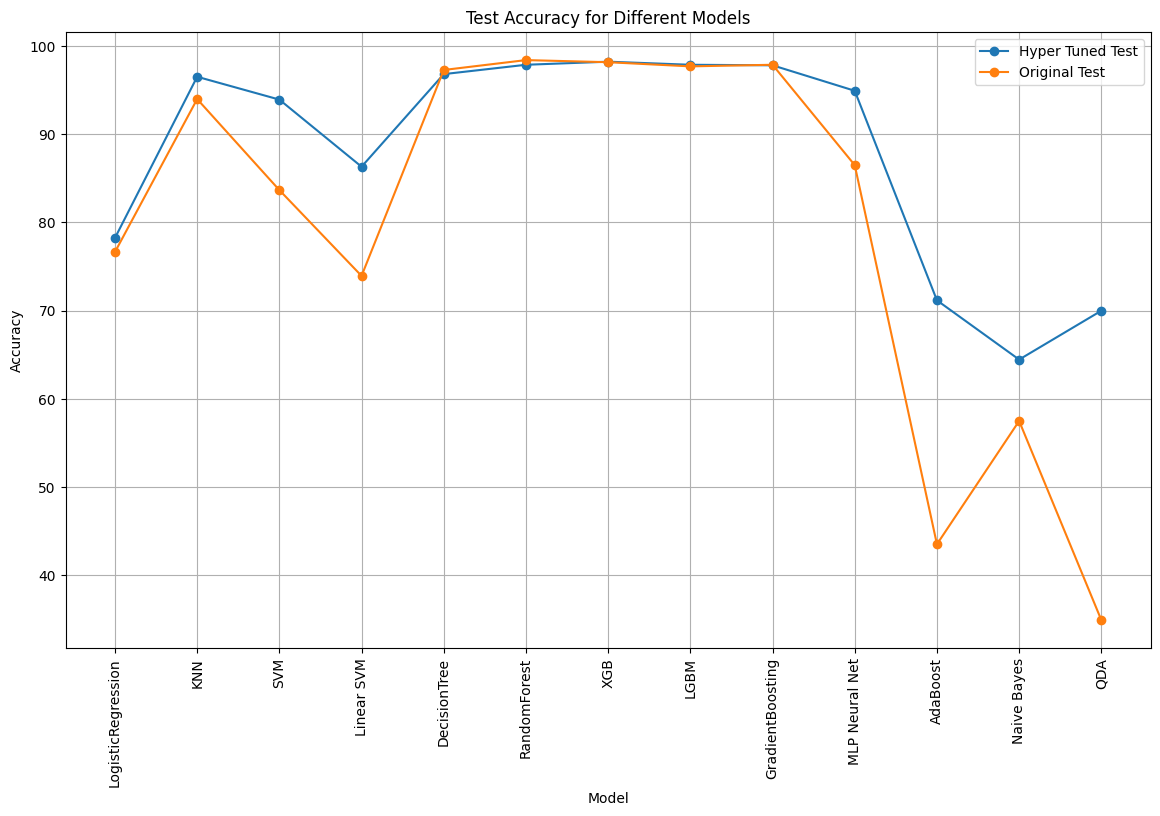

In [ ]:
metric_to_show = 'Accuracy'       # Accuracy, F1 Macro, F1 Weighted, Recall Macro, Recall Weighted, Precision Macro, Precision Weighted

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first set of data
# result_hyper_tuned.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8), title=f'Train and Test {metric_to_show} for Different Models')
result_ac_lab_hyper_tuned.loc[[('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8), title=f'Test {metric_to_show} for Different Models')

# Plot the second set of data
# result.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8))
result_ac_lab.loc[[('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8))

# Set labels, legends, and show the plot
ax.set_xlabel('Model')
ax.set_ylabel(metric_to_show)
ax.grid(True)
# ax.legend(['Hyper Tuned Train', 'Hyper Tuned Test', 'Original Train', 'Original Test'])
ax.legend(['Hyper Tuned Test', 'Original Test'])
plt.xticks(np.arange(len(result_ac_lab.columns.to_numpy())), result_ac_lab.columns.to_numpy(), rotation=90)
plt.show();

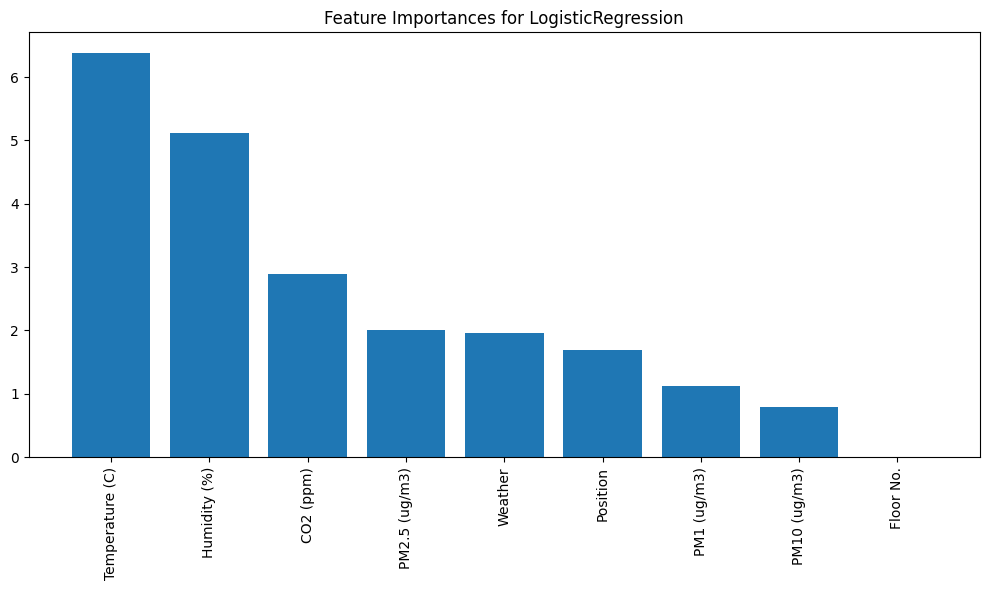

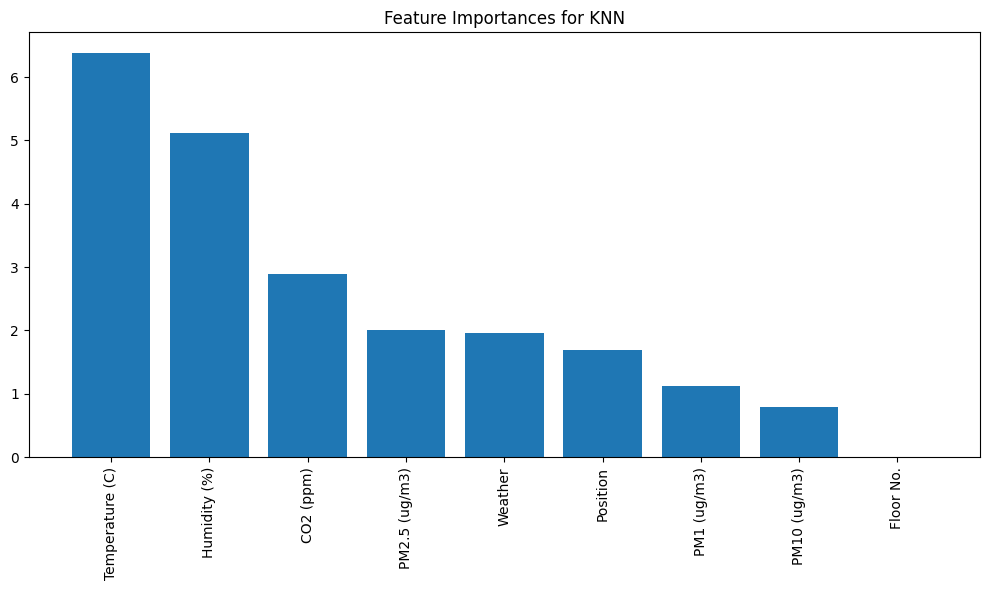

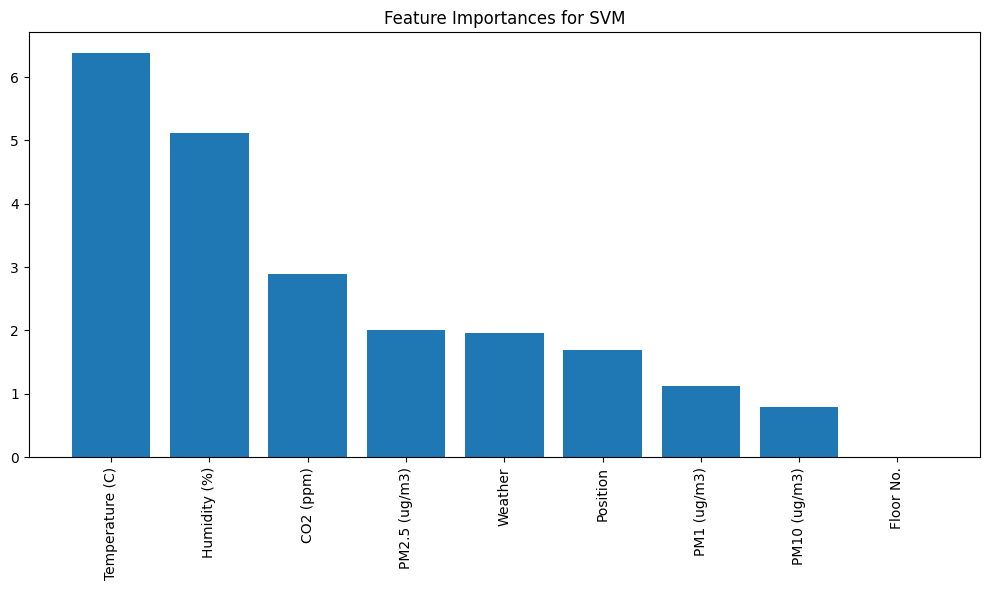

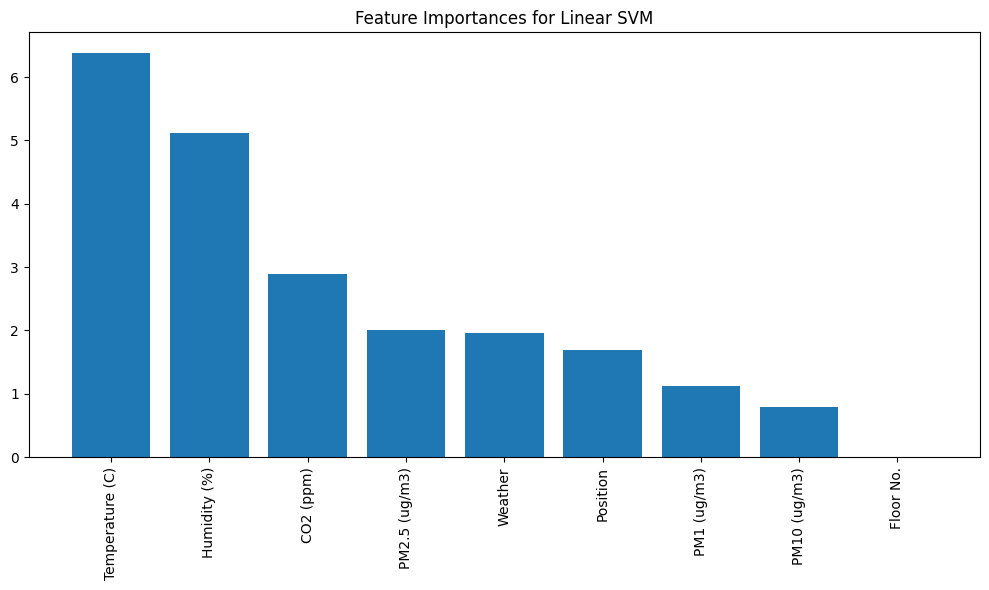

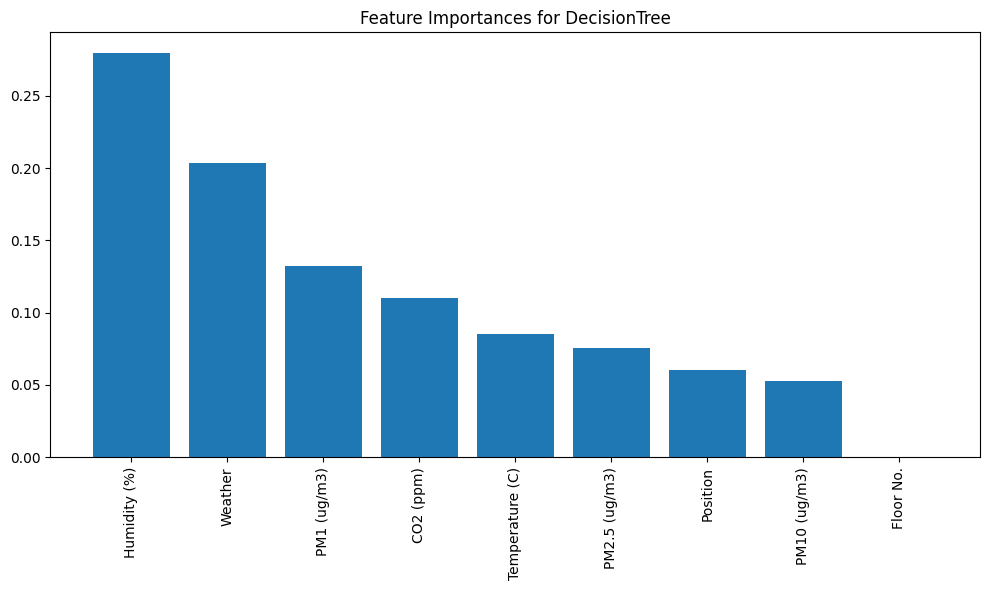

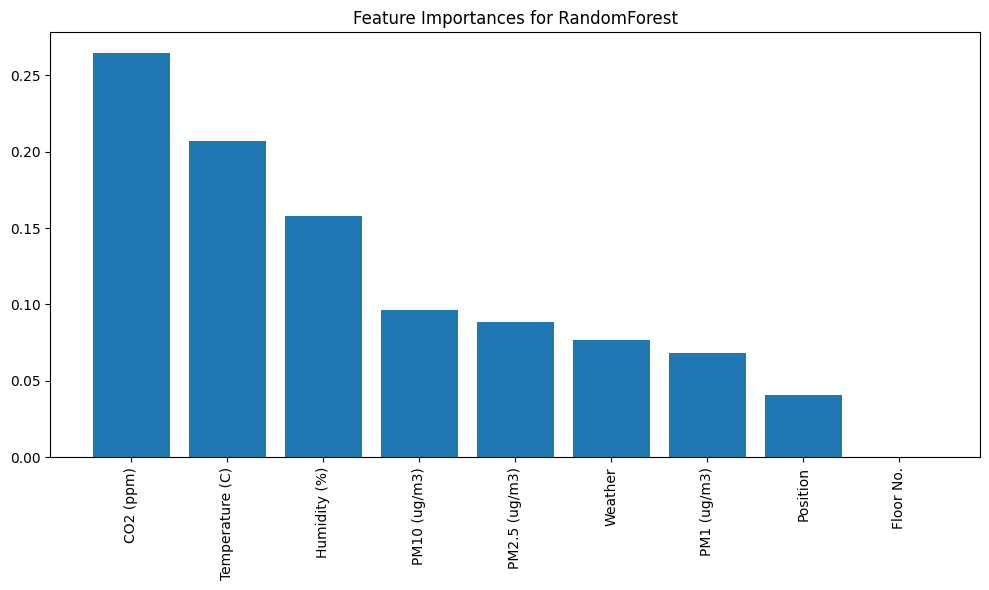

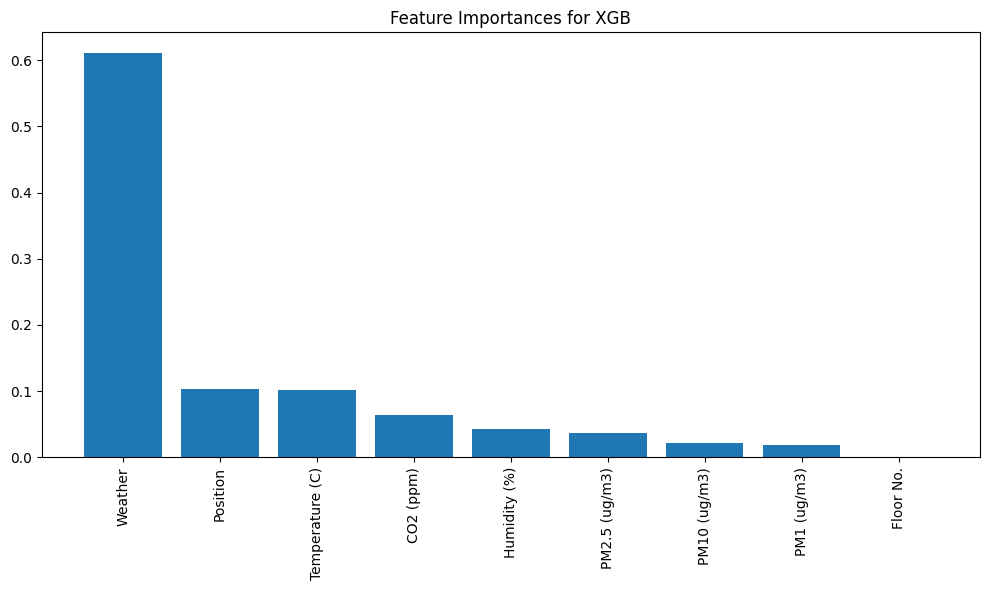

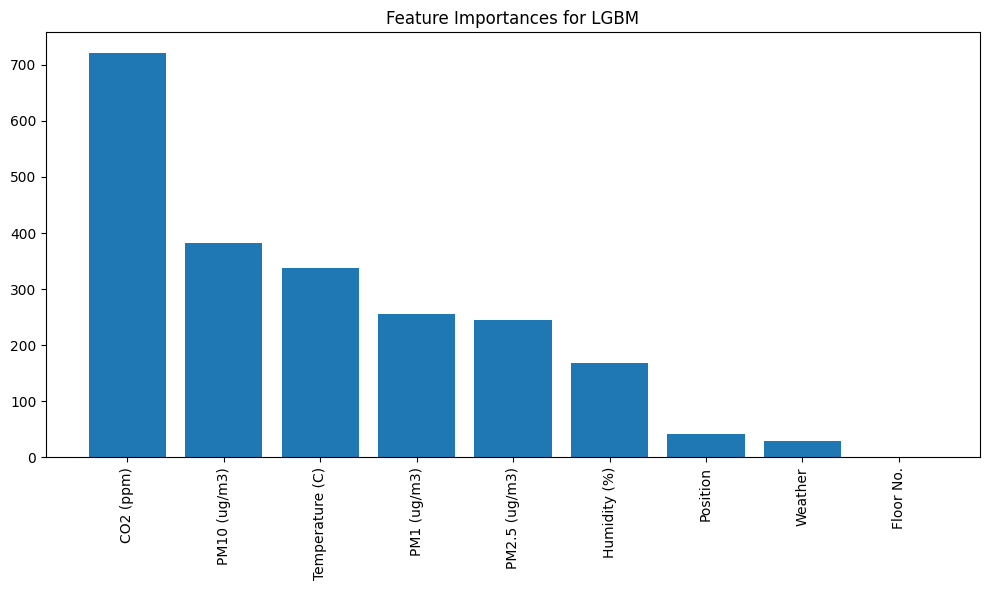

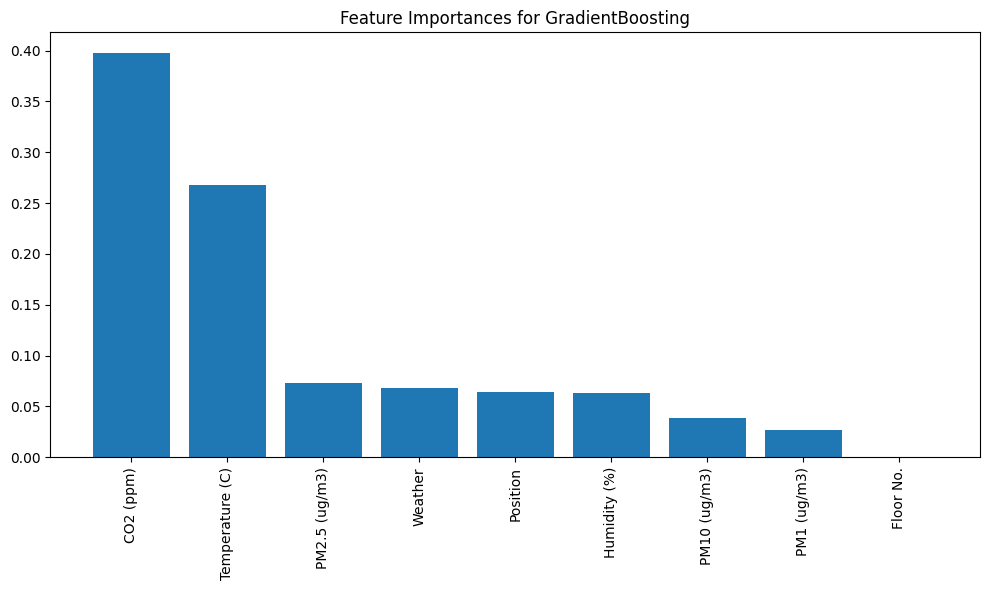

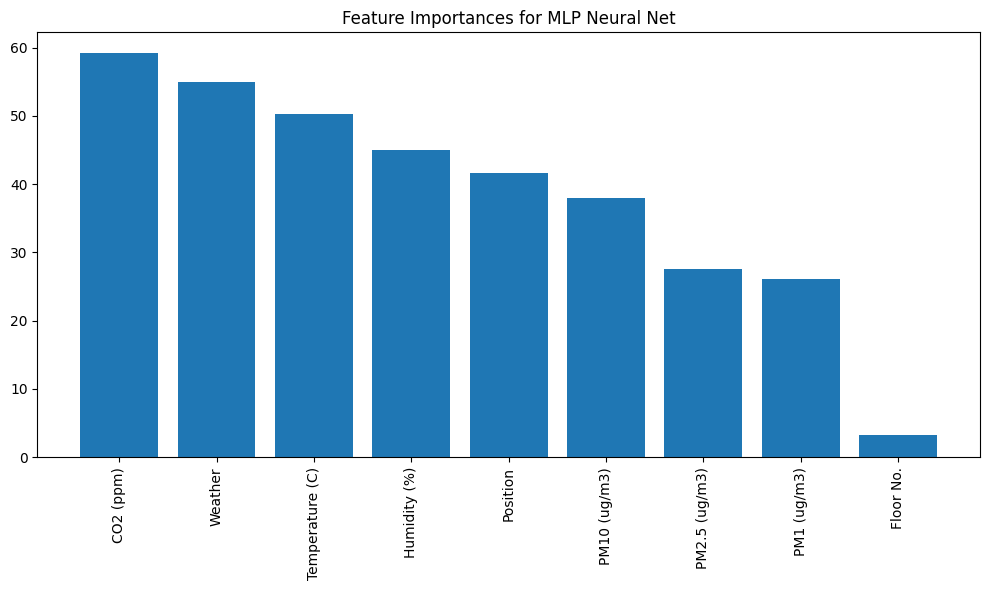

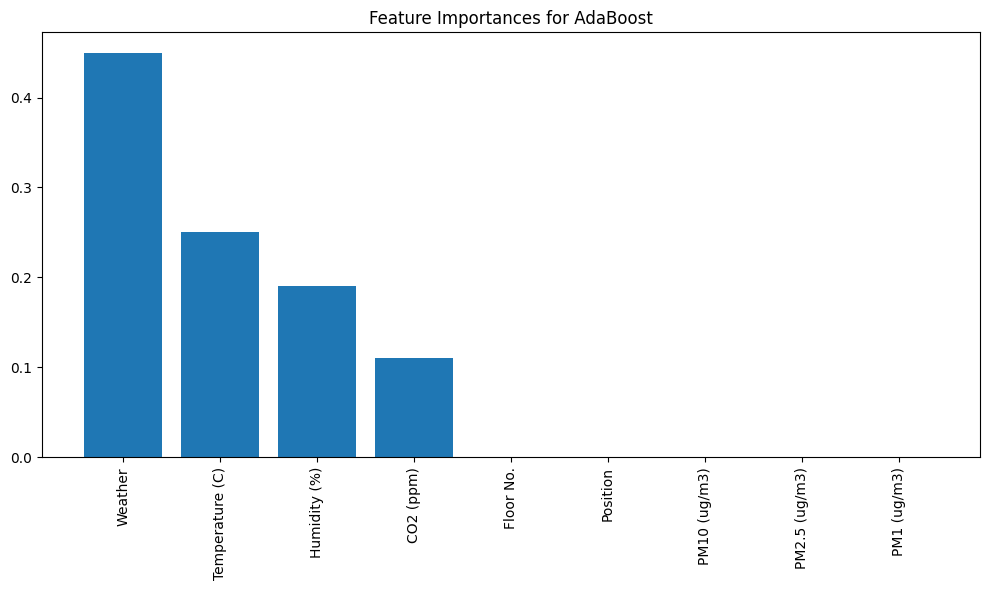

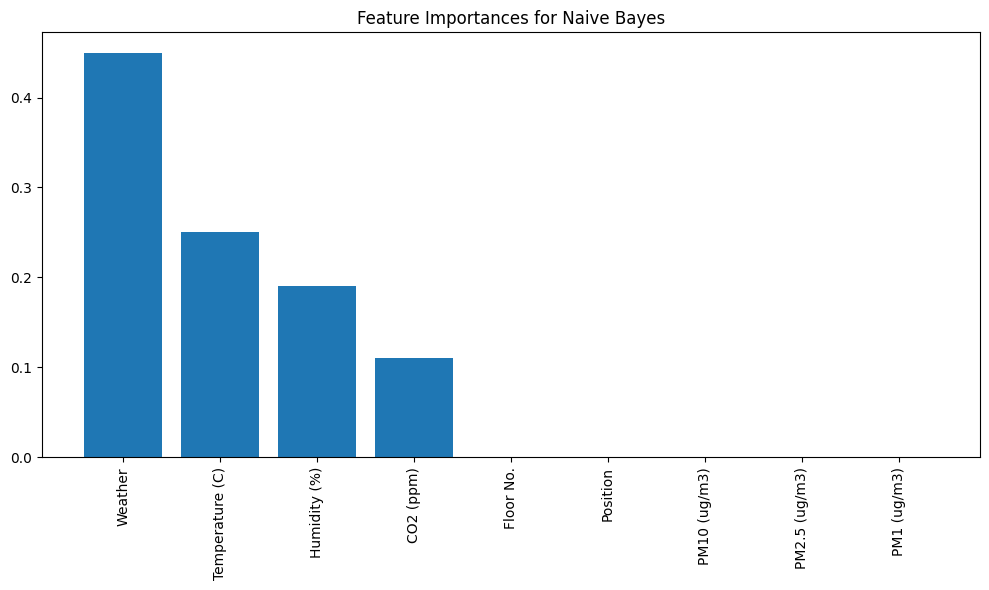

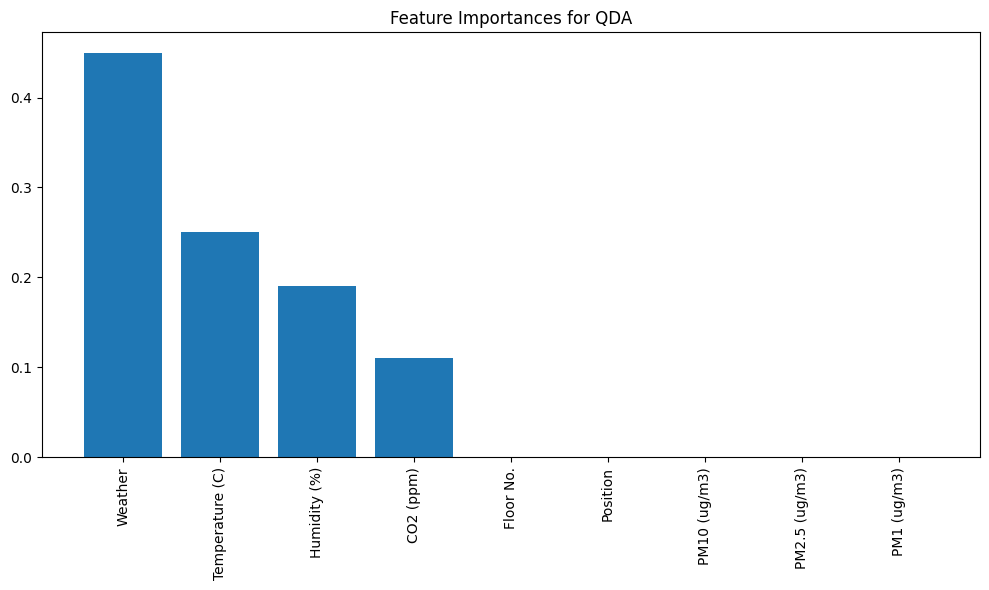

In [ ]:
model_names, models = [], []
for model_name in evaluator_ac_lab_hyper_tuned.model_names:
    model_names.append(model_name)
    models.append(evaluator_ac_lab_hyper_tuned.models[model_name].named_steps['classifier'])
plot_feature_importances(models, model_names, df_tmp.columns.to_numpy()[:-1])

Objects ->
- evaluator_ac_lab
- evaluator_ac_lab_hyper_tuned

Results ->
- result_ac_lab
- result_ac_lab_hyper_tuned

## AC Classroom ML Machine Learning Model

In [ ]:
# Preapring data for ML
df_tmp = new_df.query("`Room Type` == 1 and `Room Condition` == 1")[['CO2 (ppm)', 'PM1 (ug/m3)', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'Temperature (C)', 'Humidity (%)', 'Position', 'Room Condition', 'Room Type', 'Floor No.', 'Weather', 'Occupancy_Classified']].drop(["Room Condition", "Room Type"], axis = 1)

In [ ]:
# Split data into x and y
ac_classroom_x = df_tmp.drop('Occupancy_Classified', axis = 1)
ac_classroom_y = df_tmp['Occupancy_Classified'].values  # converting to numpy array

# Scaling input variables, output variables doens't required as we are just predicting discrete outcomes
ac_classroom_x = st_x.fit_transform(ac_classroom_x)

In [ ]:
# ML Training without hyper tuned
evaluator_ac_classroom = original_ml_pipeline_obj(ac_classroom_x, ac_classroom_y, test_size = 0.4)


LogisticRegression model has started training
LogisticRegression model has ended training. Time -> 0.03s. Accuracy - > 73.10 %


KNN model has started training
KNN model has ended training. Time -> 0.0s. Accuracy - > 93.75 %


SVM model has started training
SVM model has ended training. Time -> 0.08s. Accuracy - > 83.35 %


Linear SVM model has started training
Linear SVM model has ended training. Time -> 0.11s. Accuracy - > 69.86 %


DecisionTree model has started training
DecisionTree model has ended training. Time -> 0.01s. Accuracy - > 97.66 %


RandomForest model has started training
RandomForest model has ended training. Time -> 4.18s. Accuracy - > 97.59 %


XGB model has started training
XGB model has ended training. Time -> 1.09s. Accuracy - > 97.51 %


LGBM model has started training
LGBM model has ended training. Time -> 4.4s. Accuracy - > 97.59 %


GradientBoosting model has started training
GradientBoosting model has ended training. Time -> 2.1s. Accuracy - > 97.81 %


MLP

In [ ]:
result_ac_classroom = evaluate_result(evaluator_ac_classroom)
result_ac_classroom

LogisticRegression    KNN    SVM Linear SVM  \
      Metrics                                                          
Train Accuracy                        72.55  96.28   81.6      67.67   
      F1 Macro                        64.14  95.59  72.96      48.36   
      F1 Weighted                     70.28  96.27  79.18       64.7   
      Recall Macro                    63.54  95.43  73.61      50.68   
      Recall Weighted                 72.55  96.28   81.6      67.67   
      Precision Macro                 66.48  95.76  88.99      62.64   
      Precision Weighted              68.57  96.27  83.33      65.35   
Test  Accuracy                         73.1  93.75  83.35      69.86   
      F1 Macro                        63.72   91.0  73.73      50.12   
      F1 Weighted                     71.31  93.78  81.47      67.45   
      Recall Macro                    62.02  90.87  73.63      50.75   
      Recall Weighted                  73.1  93.75  83.35      69.86   
      Precision Macro                 67.42  91.22  90.05      64.89   
      Precision Weighted              70.03  93.86  84.53      67.62   

                         DecisionTree RandomForest    XGB   LGBM  \
      Metrics                                                      
Train Accuracy                   99.8         99.8   99.6   99.5   
      F1 Macro                  99.73        99.73   99.6  99.43   
      F1 Weighted                99.8         99.8   99.6   99.5   
      Recall Macro              99.77        99.56  99.45  99.28   
      Recall Weighted            99.8         99.8   99.6   99.5   
      Precision Macro           99.69         99.9  99.75  99.58   
      Precision Weighted         99.8         99.8   99.6   99.5   
Test  Accuracy                  97.66        97.59  97.51  97.59   
      F1 Macro                   95.8        95.58  96.18  96.32   
      F1 Weighted               97.71        97.58  97.52  97.61   
      Recall Macro              96.99        95.05  96.52  96.55   
      Recall Weighted           97.66        97.59  97.51  97.59   
      Precision Macro           94.84        96.13  95.88  96.13   
      Precision Weighted        97.83        97.58  97.55  97.65   

                         GradientBoosting MLP Neural Net AdaBoost Naive Bayes  \
      Metrics                                                                   
Train Accuracy                       99.5          82.45    51.63       33.69   
      F1 Macro                      99.27          72.35    39.43       31.88   
      F1 Weighted                   99.49          79.88    40.88       22.22   
      Recall Macro                  98.95          72.76    41.17       49.44   
      Recall Weighted                99.5          82.45    51.63       33.69   
      Precision Macro               99.61           72.5    53.73       45.86   
      Precision Weighted             99.5          77.74     46.8       61.21   
Test  Accuracy                      97.81           84.4    50.26       34.06   
      F1 Macro                      96.37          73.03    38.82       31.03   
      F1 Weighted                   97.82          82.33    39.26       22.91   
      Recall Macro                  96.23          72.65    40.38       48.55   
      Recall Weighted               97.81           84.4    50.26       34.06   
      Precision Macro               96.52          73.93    54.71       46.04   
      Precision Weighted            97.85          80.49    46.79       64.49   

                            QDA  
      Metrics                    
Train Accuracy             2.87  
      F1 Macro             0.93  
      F1 Weighted          0.16  
      Recall Macro        16.67  
      Recall Weighted      2.87  
      Precision Macro      0.48  
      Precision Weighted   0.08  
Test  Accuracy             2.19  
      F1 Macro             0.71  
      F1 Weighted          0.09  
      Recall Macro        16.67  
      Recall Weighted      2.19  
      Prec

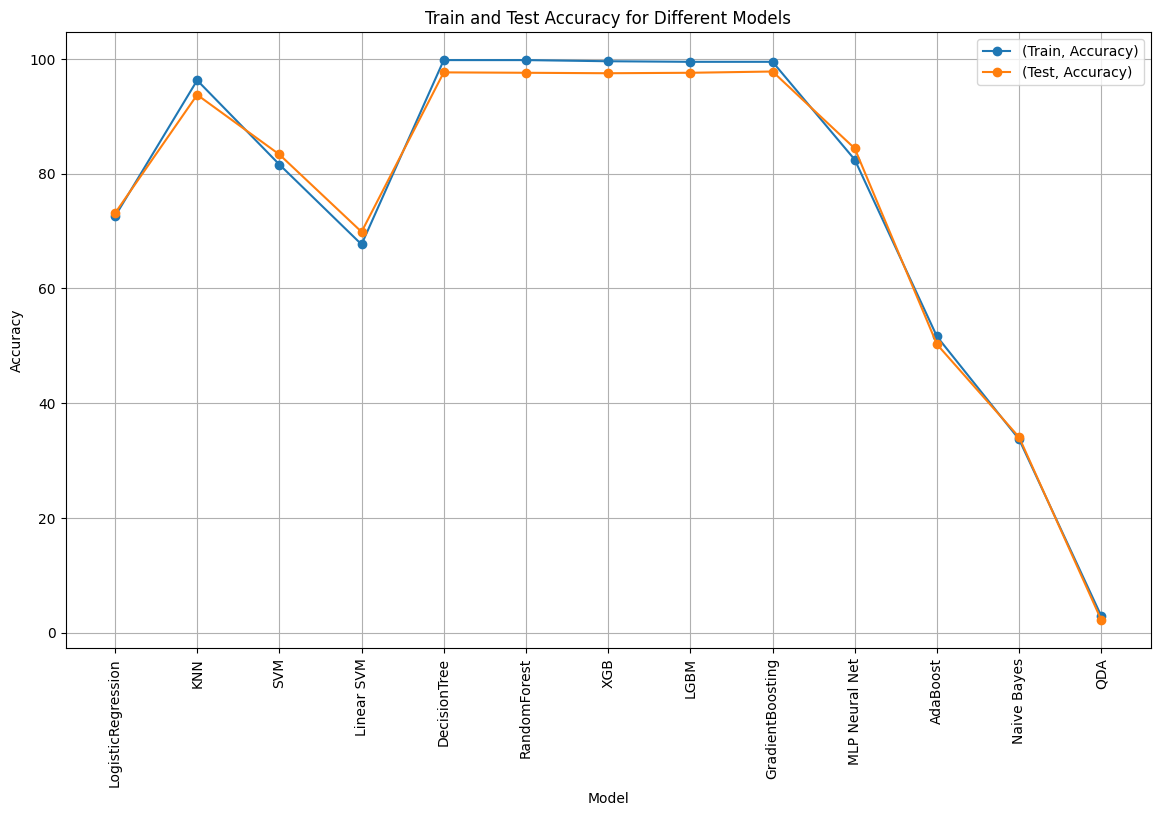

In [ ]:
metric_to_show = 'Accuracy'

ax = result_ac_classroom.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(marker='o', figsize=(14, 8))
plt.title(f'Train and Test {metric_to_show} for Different Models')
plt.xlabel('Model')
plt.ylabel(metric_to_show)
plt.xticks(np.arange(len(result_ac_classroom.columns.to_numpy())), result_ac_classroom.columns.to_numpy(), rotation=90)
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
evaluator_ac_classroom_hyper_tuned = hyper_tuned_ml_pipeline_obj(ac_classroom_x, ac_classroom_y, test_size = 0.4)


LogisticRegression tuned model has started training
Fitting 5 folds for each of 40 candidates, totalling 200 fits
LogisticRegression tuned model has ended training. Time -> 58.56s. Accuracy - > 75.96 %


KNN tuned model has started training
Fitting 5 folds for each of 20 candidates, totalling 100 fits
KNN tuned model has ended training. Time -> 2.58s. Accuracy - > 94.72 %


SVM tuned model has started training
Fitting 5 folds for each of 49 candidates, totalling 245 fits
SVM tuned model has ended training. Time -> 26.1s. Accuracy - > 94.80 %


Linear SVM tuned model has started training
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Linear SVM tuned model has ended training. Time -> 2.35s. Accuracy - > 79.50 %


DecisionTree tuned model has started training
Fitting 5 folds for each of 4800 candidates, totalling 24000 fits
DecisionTree tuned model has ended training. Time -> 134.04s. Accuracy - > 97.06 %


RandomForest tuned model has started training
Fitting 5 folds for e

In [ ]:
result_ac_classroom_hyper_tuned = evaluate_result(evaluator_ac_classroom_hyper_tuned)
result_ac_classroom_hyper_tuned

LogisticRegression    KNN    SVM Linear SVM  \
      Metrics                                                          
Train Accuracy                        75.87  97.23  94.87      80.19   
      F1 Macro                        72.98  96.43   92.7      78.53   
      F1 Weighted                     74.38  97.22  94.69      79.81   
      Recall Macro                    72.29  96.27   91.5      77.61   
      Recall Weighted                 75.87  97.23  94.87      80.19   
      Precision Macro                 84.69  96.61  94.64      80.14   
      Precision Weighted              77.22  97.22  94.82      79.73   
Test  Accuracy                        75.96  94.72   94.8       79.5   
      F1 Macro                         73.3  91.94  92.45      75.84   
      F1 Weighted                     74.89  94.75  94.73      79.38   
      Recall Macro                    71.63  92.23  90.96      74.18   
      Recall Weighted                 75.96  94.72   94.8       79.5   
      Precision Macro                 84.57  91.74  94.26      77.79   
      Precision Weighted              76.83  94.82  94.77      79.44   

                         DecisionTree RandomForest    XGB   LGBM  \
      Metrics                                                      
Train Accuracy                  99.04        99.35   99.6   99.3   
      F1 Macro                  98.47        99.09   99.6   99.1   
      F1 Weighted               99.05        99.34   99.6  99.29   
      Recall Macro              98.37        98.79  99.45  98.95   
      Recall Weighted           99.04        99.35   99.6   99.3   
      Precision Macro           98.57         99.4  99.75  99.25   
      Precision Weighted        99.05        99.34   99.6  99.29   
Test  Accuracy                  97.06        97.59  97.59  97.51   
      F1 Macro                  95.02        96.06  96.26  96.07   
      F1 Weighted               97.11        97.58  97.61  97.52   
      Recall Macro              95.17        95.26  96.77  95.75   
      Recall Weighted           97.06        97.59  97.59  97.51   
      Precision Macro           95.06        96.91   95.8  96.41   
      Precision Weighted        97.22        97.59  97.64  97.54   

                         GradientBoosting MLP Neural Net AdaBoost Naive Bayes  \
      Metrics                                                                   
Train Accuracy                       99.8          98.54    52.99        54.4   
      F1 Macro                      99.73          98.15    39.83       52.32   
      F1 Weighted                    99.8          98.54    48.06       49.99   
      Recall Macro                  99.66          98.11    42.47       57.79   
      Recall Weighted                99.8          98.54    52.99        54.4   
      Precision Macro                99.8          98.19    46.55       56.94   
      Precision Weighted             99.8          98.55    54.57       58.54   
Test  Accuracy                      97.51          96.01    56.52       57.27   
      F1 Macro                      95.86          94.25    42.46        53.0   
      F1 Weighted                   97.54          96.04    52.01       54.01   
      Recall Macro                  96.07          94.66    44.66       58.64   
      Recall Weighted               97.51          96.01    56.52       57.27   
      Precision Macro                95.7          93.92    50.62       57.86   
      Precision Weighted            97.59          96.11    59.99       64.08   

                            QDA  
      Metrics                    
Train Accuracy            72.75  
      F1 Macro            71.13  
      F1 Weighted         73.09  
      Recall Macro         72.7  
      Recall Weighted     72.75  
      Precision Macro     72.67  
      Precision Weighted  77.45  
Test  Accuracy            76.79  
      F1 Macro            74.12  
      F1 Weighted         77.68  
      Recall Macro        75.93  
      Recall Weighted     76.79  
      Prec

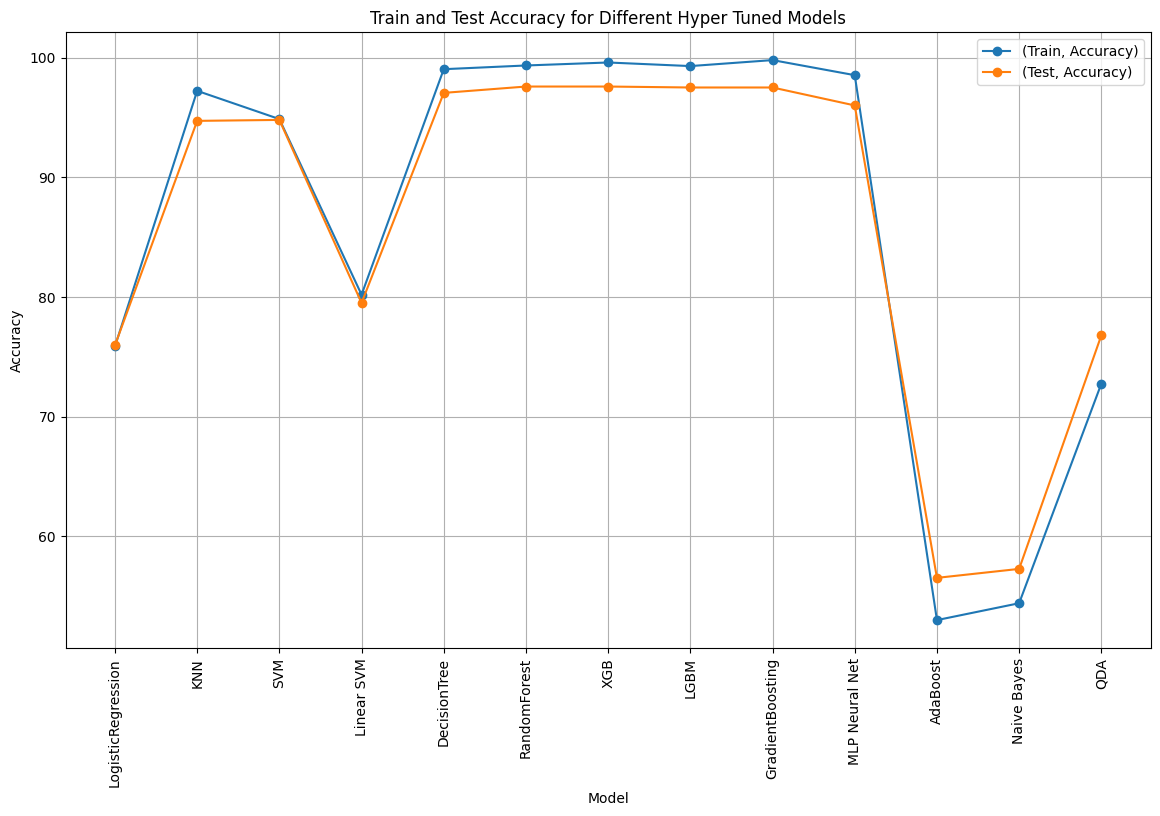

In [ ]:
metric_to_show = 'Accuracy'

result_ac_classroom_hyper_tuned.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(marker='o', figsize=(14, 8))
plt.title(f'Train and Test {metric_to_show} for Different Hyper Tuned Models')
plt.xlabel('Model')
plt.ylabel(metric_to_show)
plt.xticks(np.arange(len(result_ac_classroom_hyper_tuned.columns.to_numpy())), result_ac_classroom_hyper_tuned.columns.to_numpy(), rotation=90)
plt.legend(loc='best')
plt.grid(True)
plt.show()

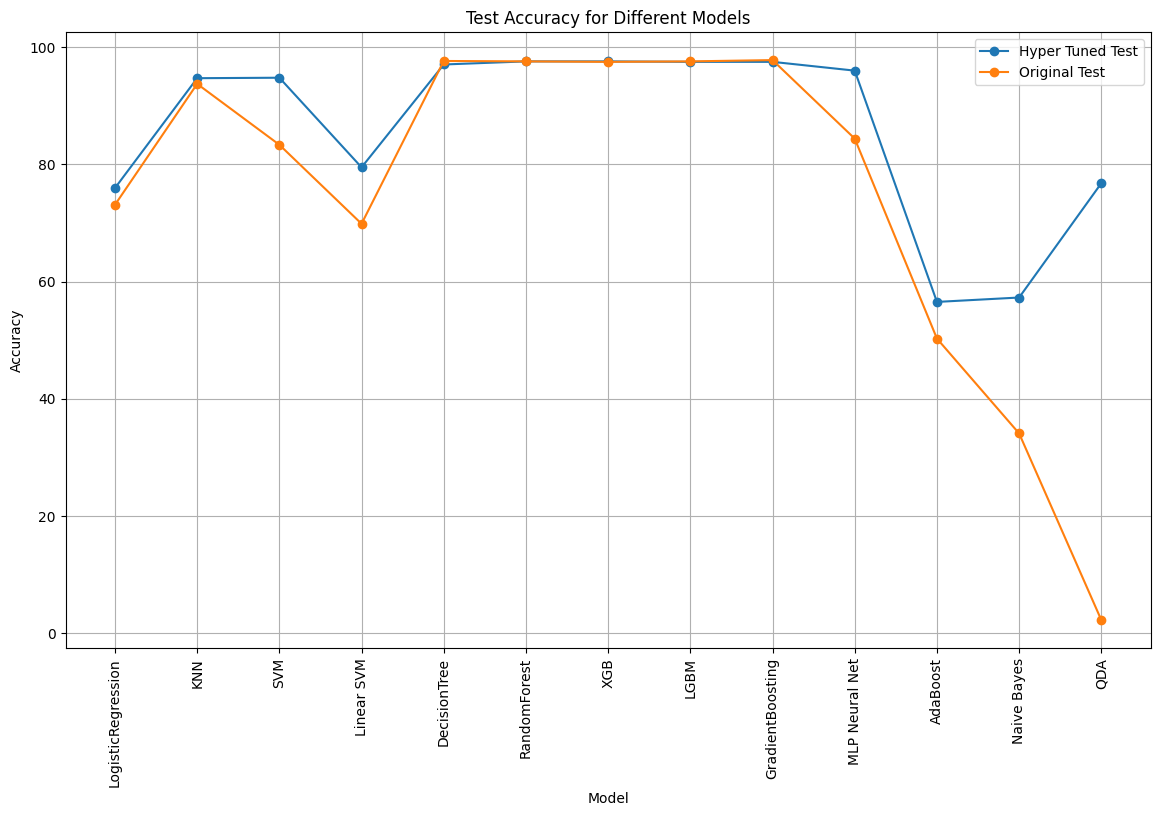

In [ ]:
metric_to_show = 'Accuracy'       # Accuracy, F1 Macro, F1 Weighted, Recall Macro, Recall Weighted, Precision Macro, Precision Weighted

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first set of data
# result_hyper_tuned.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8), title=f'Train and Test {metric_to_show} for Different Models')
result_ac_classroom_hyper_tuned.loc[[('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8), title=f'Test {metric_to_show} for Different Models')

# Plot the second set of data
# result.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8))
result_ac_classroom.loc[[('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8))

# Set labels, legends, and show the plot
ax.set_xlabel('Model')
ax.set_ylabel(metric_to_show)
ax.grid(True)
# ax.legend(['Hyper Tuned Train', 'Hyper Tuned Test', 'Original Train', 'Original Test'])
ax.legend(['Hyper Tuned Test', 'Original Test'])
plt.xticks(np.arange(len(result_ac_classroom.columns.to_numpy())), result_ac_classroom.columns.to_numpy(), rotation=90)
plt.show();

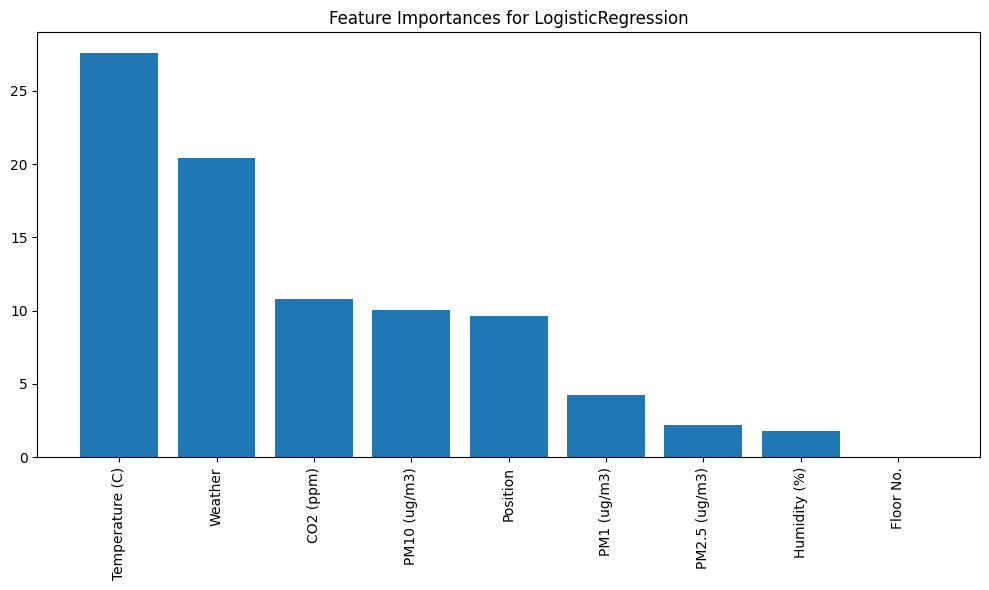

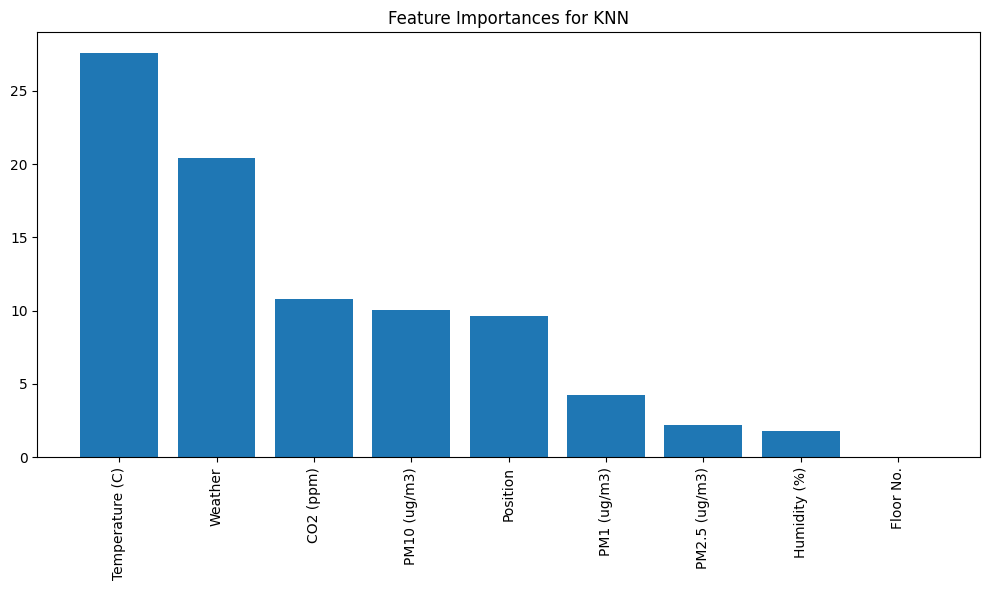

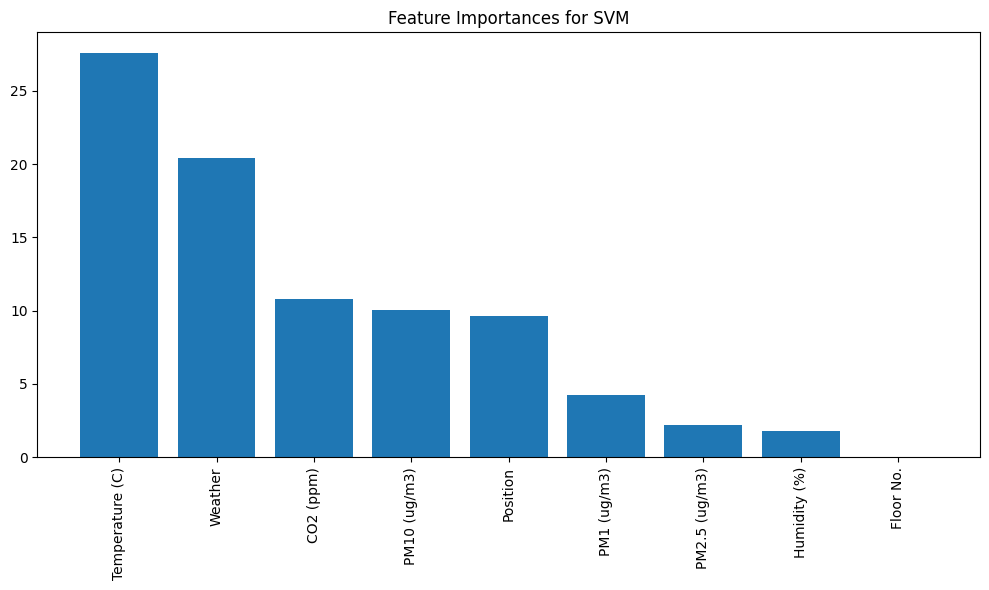

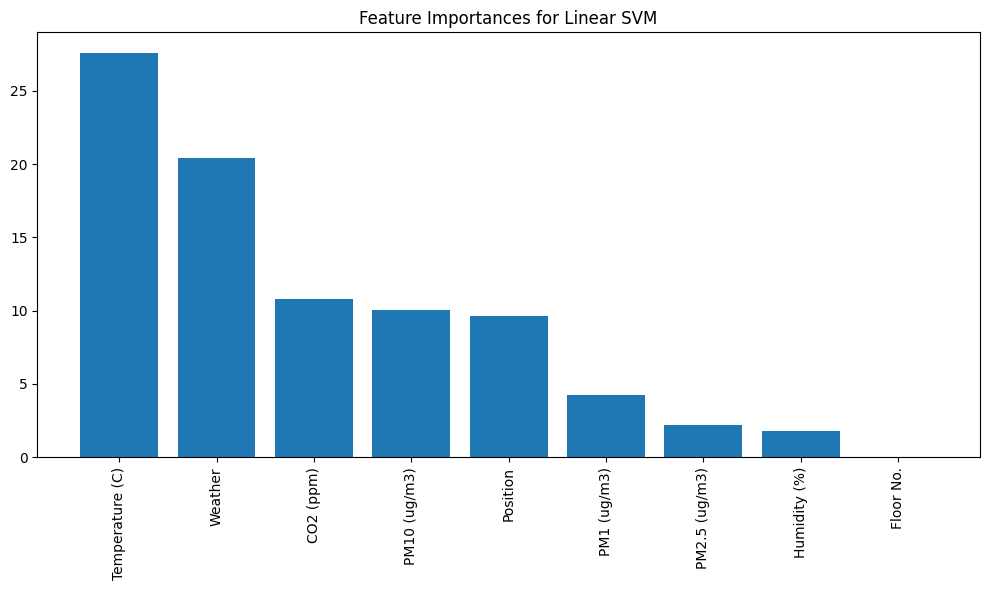

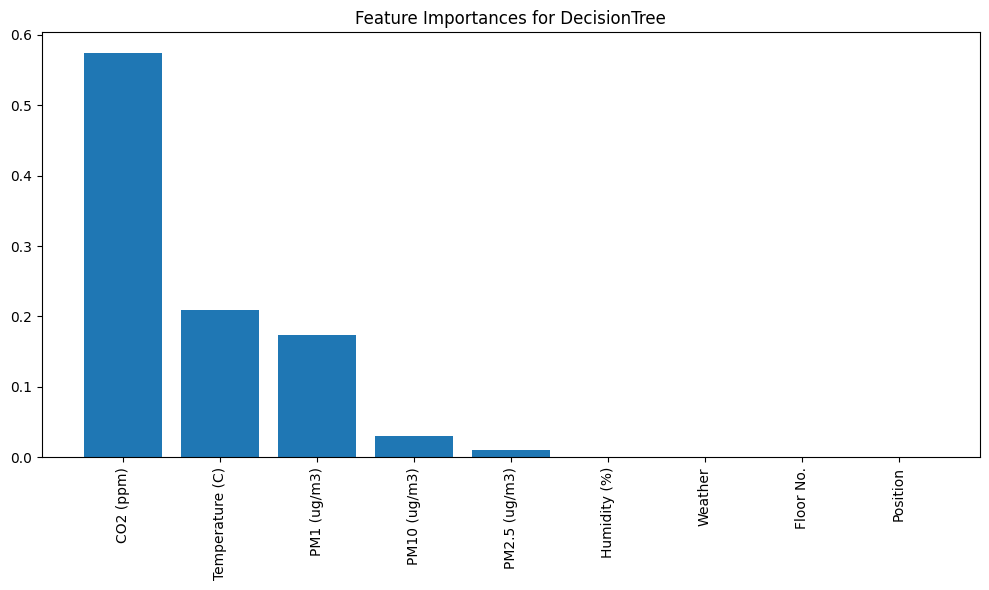

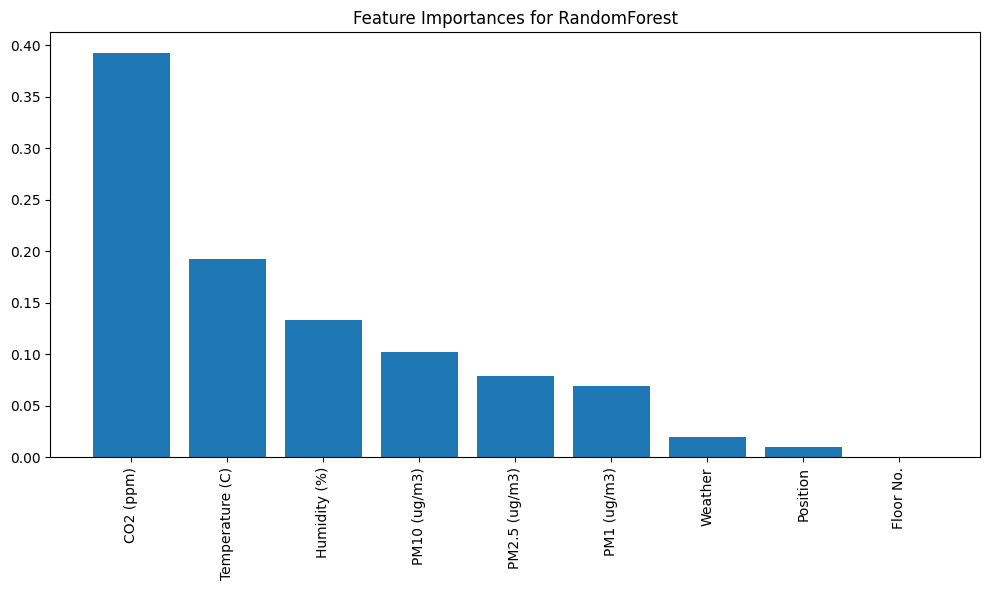

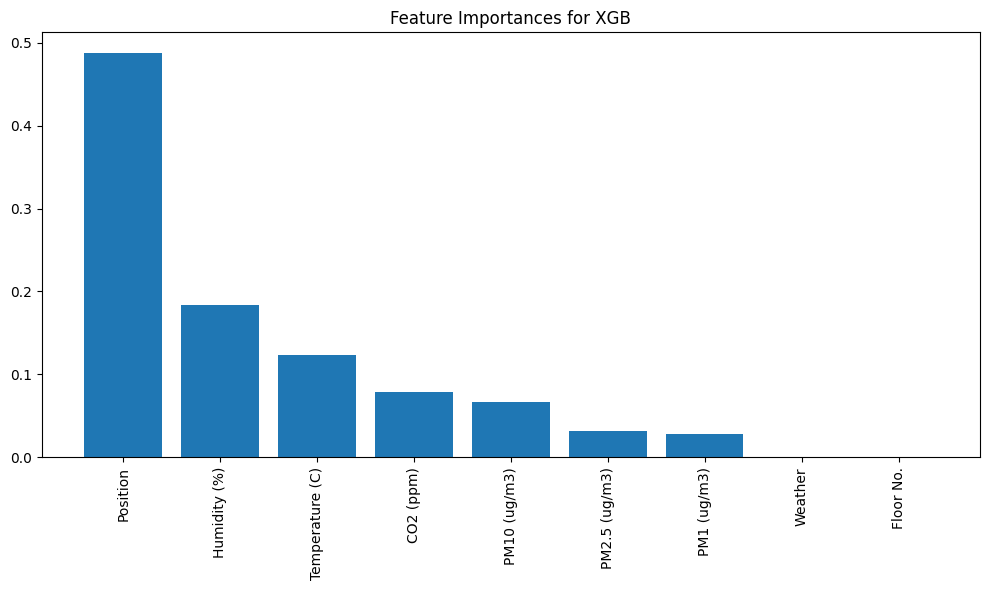

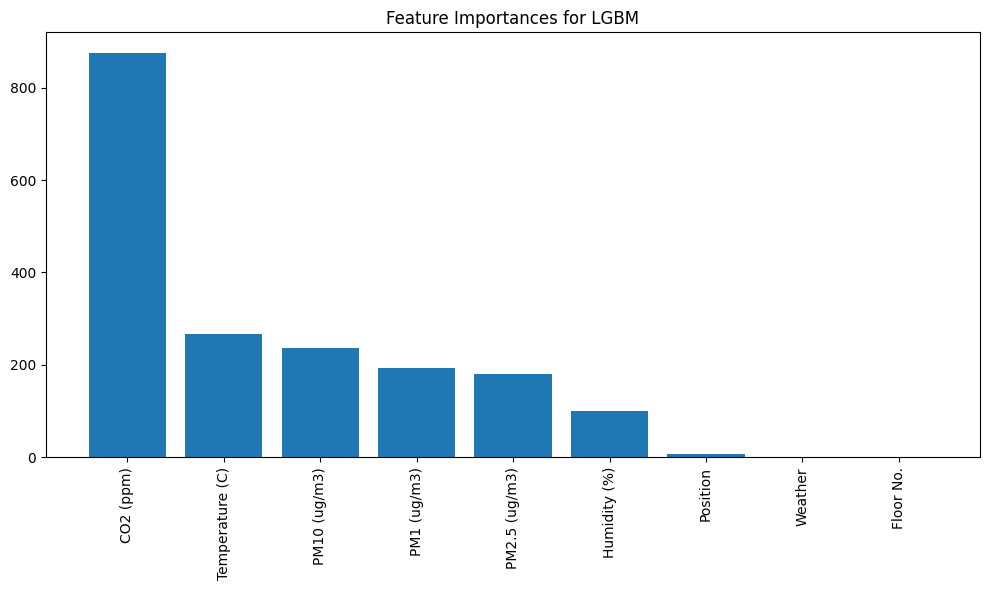

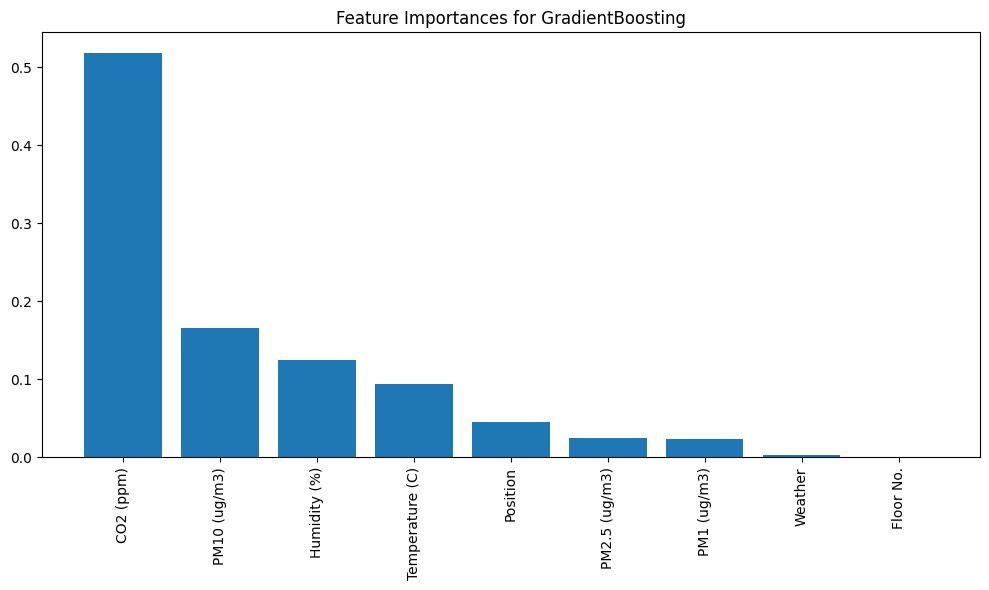

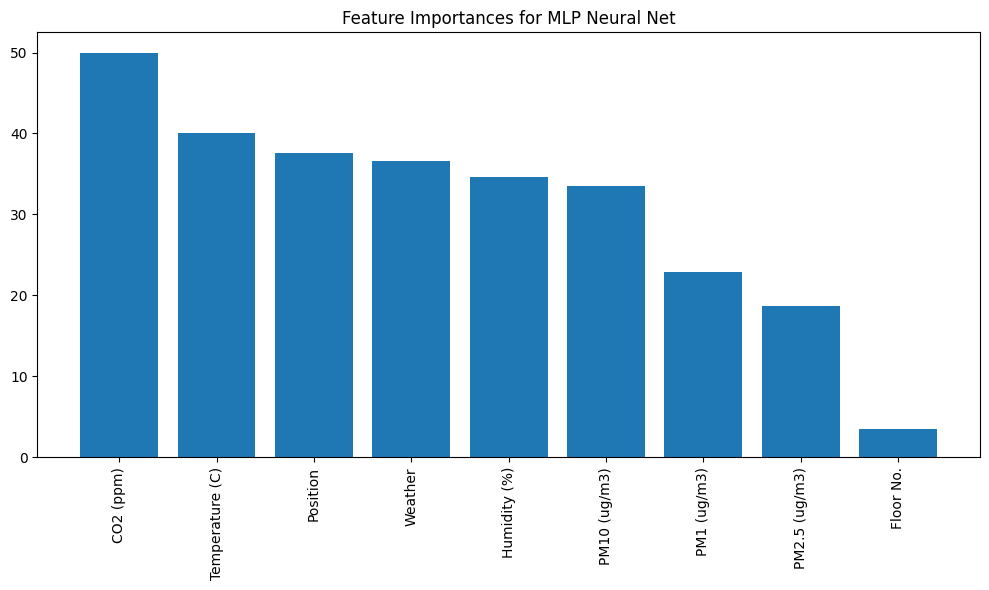

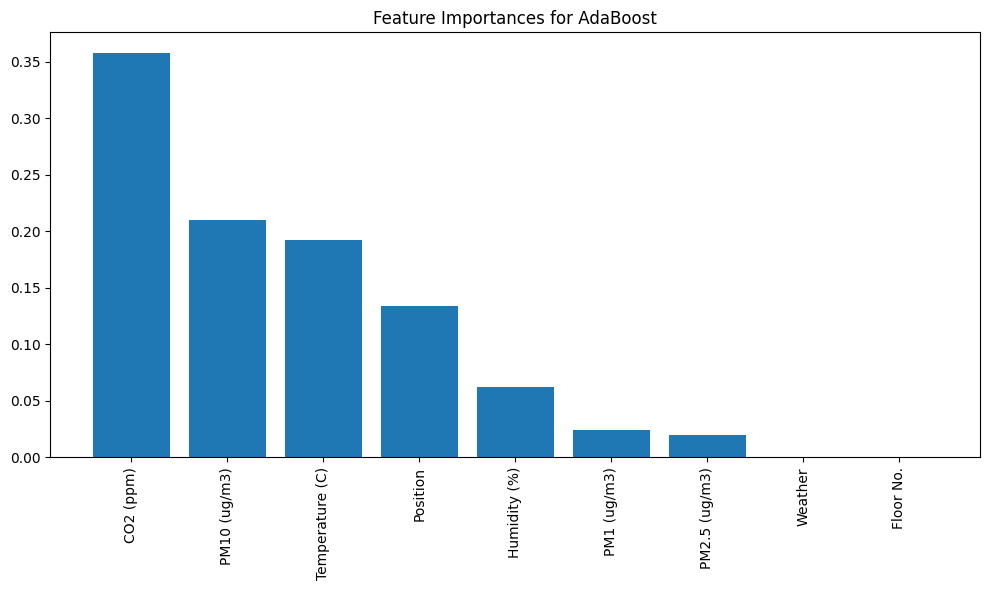

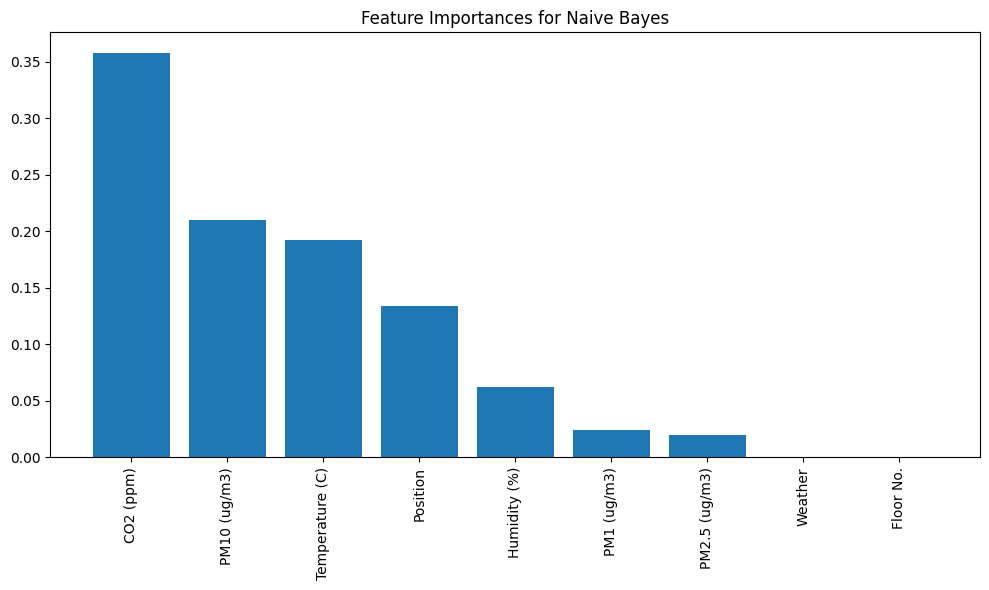

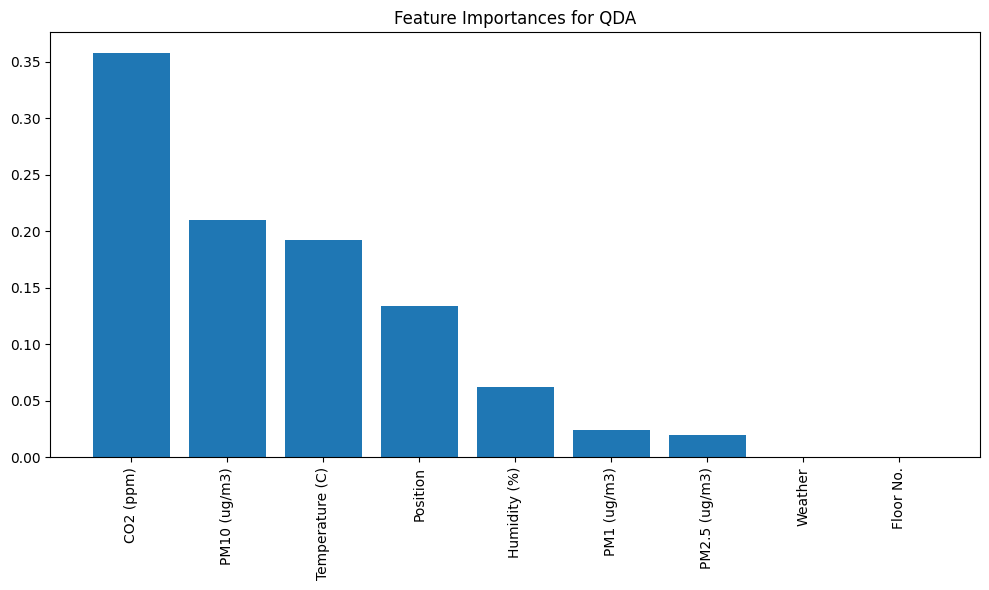

In [ ]:
model_names, models = [], []
for model_name in evaluator_ac_classroom_hyper_tuned.model_names:
    model_names.append(model_name)
    models.append(evaluator_ac_classroom_hyper_tuned.models[model_name].named_steps['classifier'])
plot_feature_importances(models, model_names, df_tmp.columns.to_numpy()[:-1])

Epoch 1/50, Train Loss: 7.3231, Train Accuracy: 0.0000, Dev Accuracy: 0.0000
Epoch 2/50, Train Loss: 6.8273, Train Accuracy: 0.3927, Dev Accuracy: 0.3967
Epoch 3/50, Train Loss: 5.8184, Train Accuracy: 0.4414, Dev Accuracy: 0.4465
Epoch 4/50, Train Loss: 6.6608, Train Accuracy: 0.4520, Dev Accuracy: 0.4540
Epoch 5/50, Train Loss: 4.1816, Train Accuracy: 0.4706, Dev Accuracy: 0.4630
Epoch 6/50, Train Loss: 5.1708, Train Accuracy: 0.4741, Dev Accuracy: 0.4691
Epoch 7/50, Train Loss: 5.4508, Train Accuracy: 0.5767, Dev Accuracy: 0.5641
Epoch 8/50, Train Loss: 1.8186, Train Accuracy: 0.5918, Dev Accuracy: 0.5686
Epoch 9/50, Train Loss: 1.1433, Train Accuracy: 0.6687, Dev Accuracy: 0.6742
Epoch 10/50, Train Loss: 0.7894, Train Accuracy: 0.6973, Dev Accuracy: 0.6938
Epoch 11/50, Train Loss: 1.1286, Train Accuracy: 0.6516, Dev Accuracy: 0.6591
Epoch 12/50, Train Loss: 3.3833, Train Accuracy: 0.7220, Dev Accuracy: 0.7360
Epoch 13/50, Train Loss: 3.3087, Train Accuracy: 0.7134, Dev Accuracy: 0.

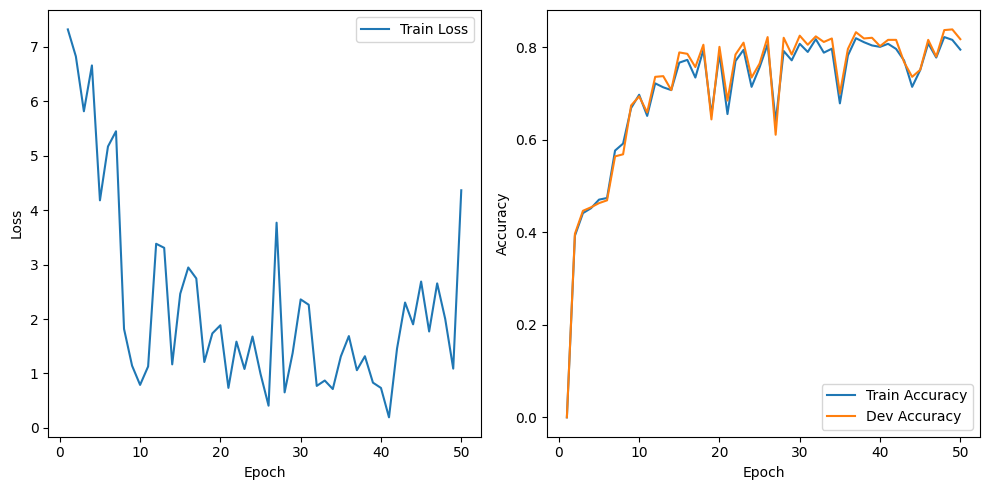

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       1.00      0.88      0.93        80
           2       0.33      0.03      0.06        32
           3       0.66      0.94      0.78       149
           4       0.87      0.85      0.86       265
           5       0.87      0.75      0.81       124

    accuracy                           0.82       663
   macro avg       0.78      0.73      0.73       663
weighted avg       0.82      0.82      0.80       663

F1-Score: 0.8036
Hidden layers configuration: [16, 8], Accuracy: 0.8174962292609351
Epoch 1/50, Train Loss: 7.5274, Train Accuracy: 0.1679, Dev Accuracy: 0.1312
Epoch 2/50, Train Loss: 7.5536, Train Accuracy: 0.3881, Dev Accuracy: 0.3635
Epoch 3/50, Train Loss: 6.8964, Train Accuracy: 0.6310, Dev Accuracy: 0.6591
Epoch 4/50, Train Loss: 5.9499, Train Accuracy: 0.6838, Dev Accuracy: 0.7044
Epoch 5/50, Train Loss: 5.3552, Train Accu

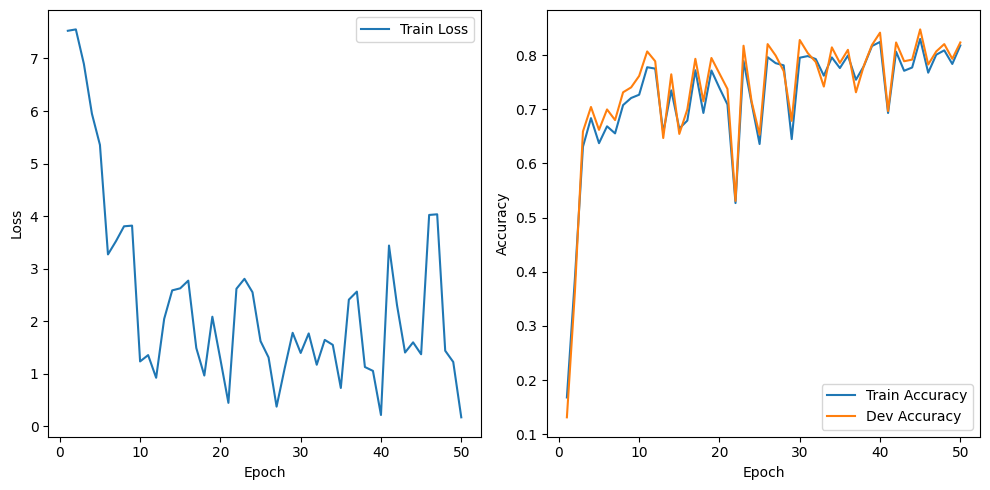

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.92      0.55        13
           1       1.00      0.70      0.82        80
           2       0.86      0.19      0.31        32
           3       0.80      0.88      0.84       149
           4       0.85      0.92      0.88       265
           5       0.82      0.79      0.81       124

    accuracy                           0.82       663
   macro avg       0.79      0.73      0.70       663
weighted avg       0.84      0.82      0.82       663

F1-Score: 0.8164
Hidden layers configuration: [32, 16, 8], Accuracy: 0.8235294117647058
Epoch 1/50, Train Loss: 7.3086, Train Accuracy: 0.2700, Dev Accuracy: 0.2986
Epoch 2/50, Train Loss: 6.5482, Train Accuracy: 0.5043, Dev Accuracy: 0.5204
Epoch 3/50, Train Loss: 5.2745, Train Accuracy: 0.5380, Dev Accuracy: 0.5596
Epoch 4/50, Train Loss: 4.0197, Train Accuracy: 0.5691, Dev Accuracy: 0.5928
Epoch 5/50, Train Loss: 4.3301, Train 

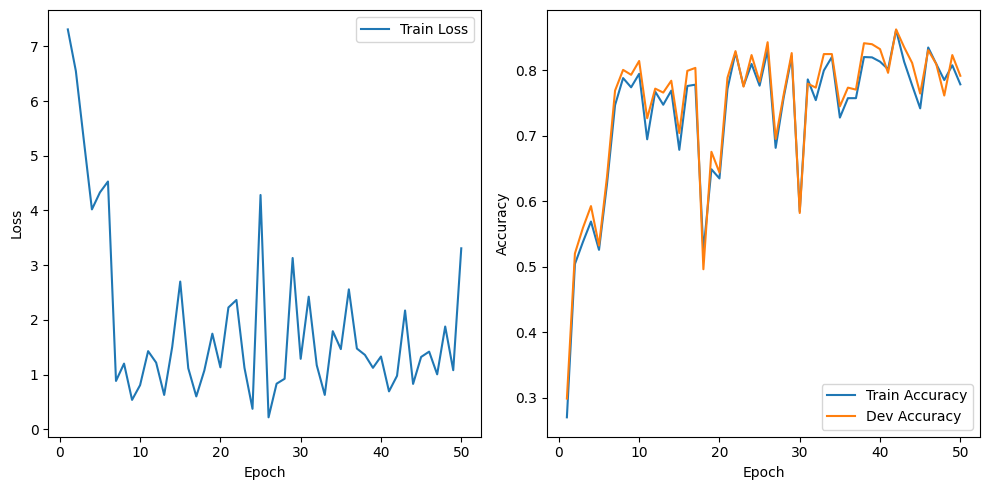

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.92      0.37        13
           1       1.00      0.44      0.61        80
           2       0.58      0.44      0.50        32
           3       0.77      0.91      0.83       149
           4       0.91      0.83      0.87       265
           5       0.81      0.88      0.84       124

    accuracy                           0.79       663
   macro avg       0.72      0.74      0.67       663
weighted avg       0.84      0.79      0.80       663

F1-Score: 0.7964
Hidden layers configuration: [64, 32, 16, 8], Accuracy: 0.7918552036199095
Best model hidden layers configuration: Sequential(
  (0): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=9, out_features=32, bias=True)
  (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=16,

In [ ]:
ann_model_ac_classroom = ann_model(ac_classroom_x, ac_classroom_y, test_size = 0.4)

In [ ]:
evaluate_ann(ann_model_ac_classroom, *train_test_split(ac_classroom_x, ac_classroom_y, test_size=0.4, random_state=42))[1]

ANN
      Metrics                  
Train Accuracy             81.8
      F1 Macro            72.38
      F1 Weighted         80.58
      Recall Macro        74.18
      Recall Weighted      81.8
      Precision Macro     78.85
      Precision Weighted  82.45
Test  Accuracy            83.27
      F1 Macro            71.13
      F1 Weighted         82.46
      Recall Macro        73.79
      Recall Weighted     83.27
      Precision Macro      79.1
      Precision Weighted  84.73

Objects ->
- evaluator_ac_classroom
- evaluator_ac_classroom_hyper_tuned

Results ->
- result_ac_classroom
- result_ac_classroom_hyper_tuned

## Non-AC Classroom ML Machine Learning Model

In [ ]:
# Preapring data for ML
df_tmp = new_df.query("`Room Type` == 1 and `Room Condition` == 2")[['CO2 (ppm)', 'PM1 (ug/m3)', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'Temperature (C)', 'Humidity (%)', 'Position', 'Room Condition', 'Room Type', 'Floor No.', 'Weather', 'Occupancy_Classified']].drop(["Room Condition", "Room Type"], axis = 1)

In [ ]:
# Split data into x and y
non_ac_classroom_x = df_tmp.drop('Occupancy_Classified', axis = 1)
non_ac_classroom_y = df_tmp['Occupancy_Classified'].values  # converting to numpy array

# Scaling input variables, output variables doens't required as we are just predicting discrete outcomes
non_ac_classroom_x = st_x.fit_transform(non_ac_classroom_x)

In [ ]:
# ML Training without hyper tuned
evaluator_non_ac_classroom = original_ml_pipeline_obj(non_ac_classroom_x, non_ac_classroom_y, test_size = 0.4)


LogisticRegression model has started training
LogisticRegression model has ended training. Time -> 0.02s. Accuracy - > 76.20 %


KNN model has started training
KNN model has ended training. Time -> 0.0s. Accuracy - > 96.31 %


SVM model has started training
SVM model has ended training. Time -> 0.02s. Accuracy - > 79.34 %


Linear SVM model has started training
Linear SVM model has ended training. Time -> 0.03s. Accuracy - > 71.59 %


DecisionTree model has started training
DecisionTree model has ended training. Time -> 0.0s. Accuracy - > 96.13 %


RandomForest model has started training
RandomForest model has ended training. Time -> 3.07s. Accuracy - > 97.23 %


XGB model has started training
XGB model has ended training. Time -> 0.97s. Accuracy - > 97.60 %


LGBM model has started training
LGBM model has ended training. Time -> 2.57s. Accuracy - > 97.60 %


GradientBoosting model has started training
GradientBoosting model has ended training. Time -> 1.13s. Accuracy - > 96.31 %


ML

In [ ]:
result_non_ac_classroom = evaluate_result(evaluator_non_ac_classroom)
result_non_ac_classroom

LogisticRegression    KNN    SVM Linear SVM  \
      Metrics                                                          
Train Accuracy                        77.07  97.53  82.12      71.89   
      F1 Macro                        55.99  96.07  68.99      41.59   
      F1 Weighted                     72.66  97.54   80.4      64.24   
      Recall Macro                    58.56  96.28  71.11      47.77   
      Recall Weighted                 77.07  97.53  82.12      71.89   
      Precision Macro                 60.52  95.87  72.52      54.42   
      Precision Weighted              72.39  97.55  81.89      68.01   
Test  Accuracy                         76.2  96.31  79.34      71.59   
      F1 Macro                         55.9  94.21  66.44      42.59   
      F1 Weighted                     70.65  96.23  77.14       62.6   
      Recall Macro                    59.84  93.87   68.1      48.84   
      Recall Weighted                  76.2  96.31  79.34      71.59   
      Precision Macro                 61.06  94.76   69.4      54.63   
      Precision Weighted              71.09  96.29  77.85      64.59   

                         DecisionTree RandomForest    XGB   LGBM  \
      Metrics                                                      
Train Accuracy                  100.0        100.0  100.0  100.0   
      F1 Macro                  100.0        100.0  100.0  100.0   
      F1 Weighted               100.0        100.0  100.0  100.0   
      Recall Macro              100.0        100.0  100.0  100.0   
      Recall Weighted           100.0        100.0  100.0  100.0   
      Precision Macro           100.0        100.0  100.0  100.0   
      Precision Weighted        100.0        100.0  100.0  100.0   
Test  Accuracy                  96.13        97.23   97.6   97.6   
      F1 Macro                   93.8        95.39  96.32  96.12   
      F1 Weighted               96.12        97.22  97.61   97.6   
      Recall Macro              93.85        95.13  96.08  95.78   
      Recall Weighted           96.13        97.23   97.6   97.6   
      Precision Macro           93.78        95.66   96.6  96.48   
      Precision Weighted        96.12        97.21  97.63  97.61   

                         GradientBoosting MLP Neural Net AdaBoost Naive Bayes  \
      Metrics                                                                   
Train Accuracy                      100.0          77.07    69.54       81.13   
      F1 Macro                      100.0           53.1    63.58       75.12   
      F1 Weighted                   100.0          71.31    70.84       82.33   
      Recall Macro                  100.0          58.03    63.04       78.52   
      Recall Weighted               100.0          77.07    69.54       81.13   
      Precision Macro               100.0          49.25    71.41       78.15   
      Precision Weighted            100.0          66.75    78.37       88.87   
Test  Accuracy                      96.31          75.83    68.27       82.29   
      F1 Macro                      94.49           53.3    61.31       77.98   
      F1 Weighted                   96.31          69.19    68.99       83.54   
      Recall Macro                  94.53          59.38    59.77       80.44   
      Recall Weighted               96.31          75.83    68.27       82.29   
      Precision Macro               94.48          48.88    68.43        80.5   
      Precision Weighted            96.32          64.09    73.85       89.17   

                            QDA  
      Metrics                    
Train Accuracy            72.38  
      F1 Macro            56.02  
      F1 Weighted         67.14  
      Recall Macro         58.6  
      Recall Weighted     72.38  
      Precision Macro     65.99  
      Precision Weighted  74.67  
Test  Accuracy            71.03  
      F1 Macro            57.81  
      F1 Weighted         66.13  
      Recall Macro        60.95  
      Recall Weighted     71.03  
      Prec

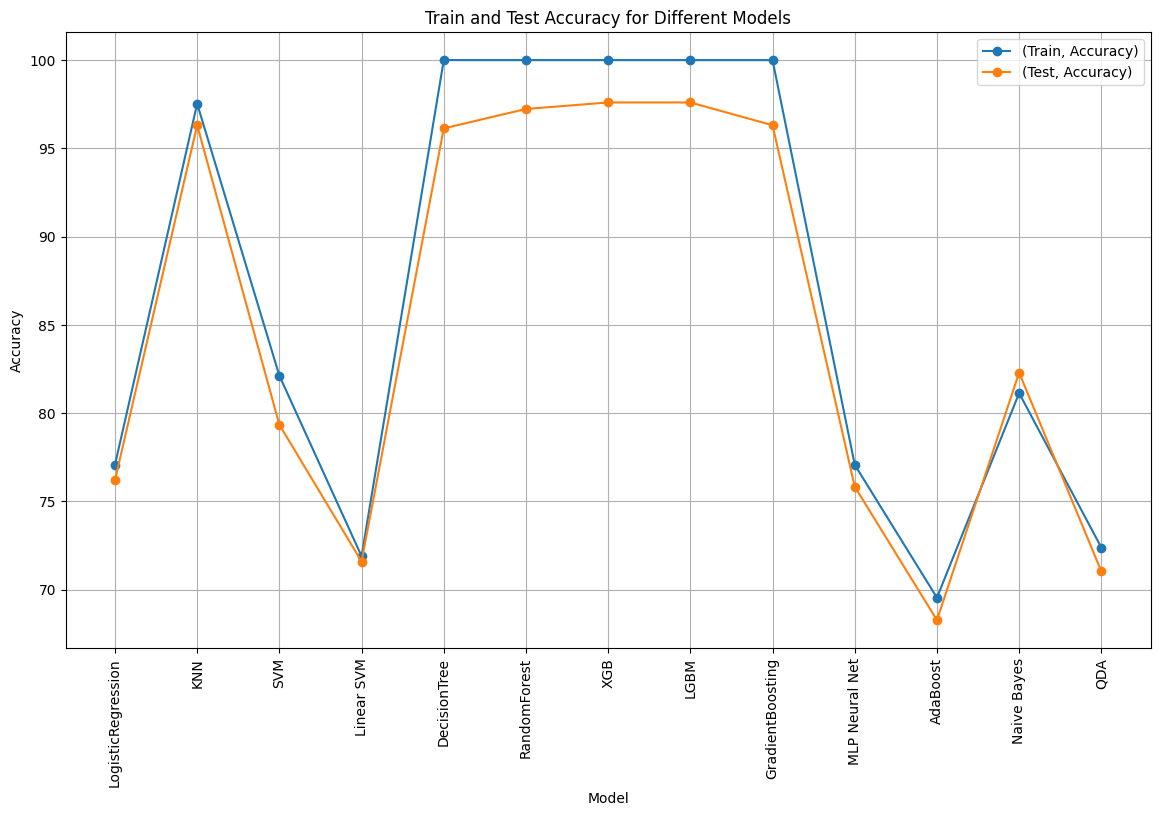

In [ ]:
metric_to_show = 'Accuracy'

ax = result_non_ac_classroom.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(marker='o', figsize=(14, 8))
plt.title(f'Train and Test {metric_to_show} for Different Models')
plt.xlabel('Model')
plt.ylabel(metric_to_show)
plt.xticks(np.arange(len(result_non_ac_classroom.columns.to_numpy())), result_non_ac_classroom.columns.to_numpy(), rotation=90)
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
evaluator_non_ac_classroom_hyper_tuned = hyper_tuned_ml_pipeline_obj(non_ac_classroom_x, non_ac_classroom_y, test_size = 0.4)


LogisticRegression tuned model has started training
Fitting 5 folds for each of 40 candidates, totalling 200 fits
LogisticRegression tuned model has ended training. Time -> 19.26s. Accuracy - > 80.81 %


KNN tuned model has started training
Fitting 5 folds for each of 20 candidates, totalling 100 fits
KNN tuned model has ended training. Time -> 1.33s. Accuracy - > 95.20 %


SVM tuned model has started training
Fitting 5 folds for each of 49 candidates, totalling 245 fits
SVM tuned model has ended training. Time -> 3.81s. Accuracy - > 95.57 %


Linear SVM tuned model has started training
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Linear SVM tuned model has ended training. Time -> 0.25s. Accuracy - > 83.39 %


DecisionTree tuned model has started training
Fitting 5 folds for each of 4800 candidates, totalling 24000 fits
DecisionTree tuned model has ended training. Time -> 103.19s. Accuracy - > 96.13 %


RandomForest tuned model has started training
Fitting 5 folds for e

In [ ]:
result_non_ac_classroom_hyper_tuned = evaluate_result(evaluator_non_ac_classroom_hyper_tuned)
result_non_ac_classroom_hyper_tuned

LogisticRegression    KNN    SVM Linear SVM  \
      Metrics                                                          
Train Accuracy                        83.85  100.0  97.78      84.96   
      F1 Macro                        71.88  100.0  95.99      71.27   
      F1 Weighted                     82.38  100.0  97.78       82.6   
      Recall Macro                    70.01  100.0  95.95      71.08   
      Recall Weighted                 83.85  100.0  97.78      84.96   
      Precision Macro                  78.5  100.0  96.05       87.0   
      Precision Weighted              83.23  100.0  97.79      86.97   
Test  Accuracy                        80.81   95.2  95.57      83.39   
      F1 Macro                        68.97   92.3  92.94      69.71   
      F1 Weighted                     79.11  95.16  95.51      80.63   
      Recall Macro                    69.02  92.08  92.32      70.58   
      Recall Weighted                 80.81   95.2  95.57      83.39   
      Precision Macro                 74.75  92.54  93.69      84.74   
      Precision Weighted              80.73  95.13  95.53      86.05   

                         DecisionTree RandomForest    XGB   LGBM  \
      Metrics                                                      
Train Accuracy                  99.51        100.0  100.0  100.0   
      F1 Macro                  99.13        100.0  100.0  100.0   
      F1 Weighted               99.51        100.0  100.0  100.0   
      Recall Macro              99.01        100.0  100.0  100.0   
      Recall Weighted           99.51        100.0  100.0  100.0   
      Precision Macro           99.28        100.0  100.0  100.0   
      Precision Weighted        99.52        100.0  100.0  100.0   
Test  Accuracy                  96.13        97.42  97.23   97.6   
      F1 Macro                  93.97        95.75  95.57  95.98   
      F1 Weighted               96.11        97.41  97.23  97.58   
      Recall Macro              93.72        95.45  95.45  95.69   
      Recall Weighted           96.13        97.42  97.23   97.6   
      Precision Macro           94.48        96.07  95.71  96.31   
      Precision Weighted        96.23        97.41  97.23  97.58   

                         GradientBoosting MLP Neural Net AdaBoost Naive Bayes  \
      Metrics                                                                   
Train Accuracy                      100.0          99.51    67.45       83.48   
      F1 Macro                      100.0          98.89    55.33       77.79   
      F1 Weighted                   100.0          99.51    66.42       84.76   
      Recall Macro                  100.0          98.95    52.83       81.19   
      Recall Weighted               100.0          99.51    67.45       83.48   
      Precision Macro               100.0          98.87    63.59       79.05   
      Precision Weighted            100.0          99.52    71.07       89.74   
Test  Accuracy                      96.49          96.86    64.76        84.5   
      F1 Macro                      94.72          94.64    54.23       79.72   
      F1 Weighted                   96.49          96.86    63.45       85.75   
      Recall Macro                  94.62          94.36    52.03       82.21   
      Recall Weighted               96.49          96.86    64.76        84.5   
      Precision Macro               94.82          95.05    62.36       80.62   
      Precision Weighted            96.48          96.91    68.05       89.78   

                            QDA  
      Metrics                    
Train Accuracy            75.59  
      F1 Macro            59.82  
      F1 Weighted         73.27  
      Recall Macro         65.3  
      Recall Weighted     75.59  
      Precision Macro     61.57  
      Precision Weighted  77.17  
Test  Accuracy             73.8  
      F1 Macro            59.46  
      F1 Weighted         71.23  
      Recall Macro        64.66  
      Recall Weighted      73.8  
      Prec

Epoch 1/50, Train Loss: 6.5778, Train Accuracy: 0.0000, Dev Accuracy: 0.0000
Epoch 2/50, Train Loss: 6.1484, Train Accuracy: 0.3921, Dev Accuracy: 0.3579
Epoch 3/50, Train Loss: 5.8990, Train Accuracy: 0.6893, Dev Accuracy: 0.6679
Epoch 4/50, Train Loss: 5.5161, Train Accuracy: 0.7213, Dev Accuracy: 0.7085
Epoch 5/50, Train Loss: 4.8806, Train Accuracy: 0.7275, Dev Accuracy: 0.7159
Epoch 6/50, Train Loss: 4.1998, Train Accuracy: 0.7263, Dev Accuracy: 0.7122
Epoch 7/50, Train Loss: 3.8079, Train Accuracy: 0.7263, Dev Accuracy: 0.7122
Epoch 8/50, Train Loss: 4.3991, Train Accuracy: 0.7263, Dev Accuracy: 0.7122
Epoch 9/50, Train Loss: 3.6251, Train Accuracy: 0.7263, Dev Accuracy: 0.7085
Epoch 10/50, Train Loss: 2.0269, Train Accuracy: 0.7448, Dev Accuracy: 0.7306
Epoch 11/50, Train Loss: 2.9066, Train Accuracy: 0.7275, Dev Accuracy: 0.7122
Epoch 12/50, Train Loss: 2.8730, Train Accuracy: 0.7386, Dev Accuracy: 0.7196
Epoch 13/50, Train Loss: 2.9959, Train Accuracy: 0.7287, Dev Accuracy: 0.

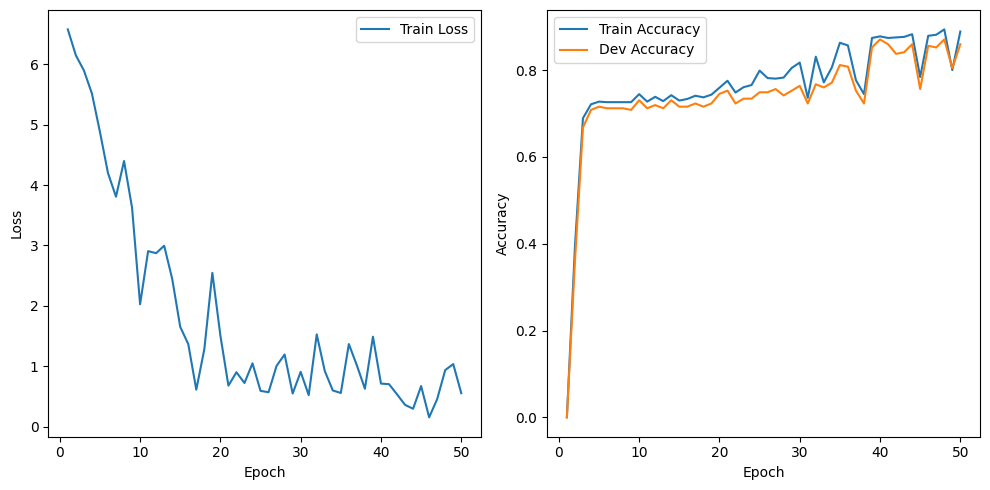

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.94      0.97      0.95        60
           2       0.44      0.67      0.53        18
           3       0.86      0.83      0.84        23
           4       0.50      0.48      0.49        27
           5       0.96      0.86      0.90        83

    accuracy                           0.86       271
   macro avg       0.78      0.80      0.79       271
weighted avg       0.88      0.86      0.86       271

F1-Score: 0.8649
Hidden layers configuration: [16, 8], Accuracy: 0.8597785977859779
Epoch 1/50, Train Loss: 7.0561, Train Accuracy: 0.0000, Dev Accuracy: 0.0000
Epoch 2/50, Train Loss: 6.9467, Train Accuracy: 0.0000, Dev Accuracy: 0.0000
Epoch 3/50, Train Loss: 6.6444, Train Accuracy: 0.1985, Dev Accuracy: 0.1808
Epoch 4/50, Train Loss: 6.0677, Train Accuracy: 0.4797, Dev Accuracy: 0.4207
Epoch 5/50, Train Loss: 6.7883, Train Accu

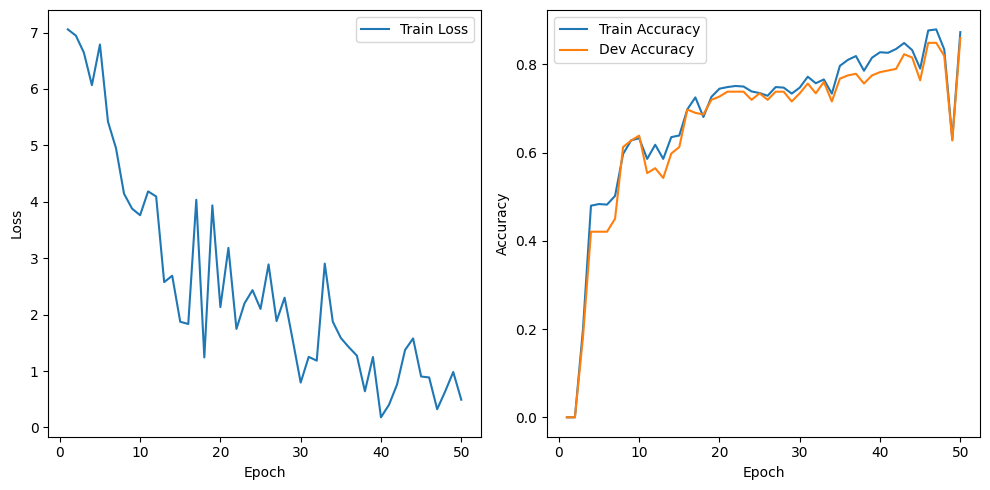

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.84      0.97      0.90        60
           2       0.48      0.78      0.60        18
           3       0.95      0.83      0.88        23
           4       0.45      0.33      0.38        27
           5       1.00      0.88      0.94        83

    accuracy                           0.86       271
   macro avg       0.79      0.80      0.78       271
weighted avg       0.87      0.86      0.86       271

F1-Score: 0.8599
Hidden layers configuration: [32, 16, 8], Accuracy: 0.8597785977859779
Epoch 1/50, Train Loss: 6.4835, Train Accuracy: 0.1899, Dev Accuracy: 0.1993
Epoch 2/50, Train Loss: 6.2137, Train Accuracy: 0.5598, Dev Accuracy: 0.4908
Epoch 3/50, Train Loss: 5.5238, Train Accuracy: 0.5783, Dev Accuracy: 0.5277
Epoch 4/50, Train Loss: 5.3057, Train Accuracy: 0.5783, Dev Accuracy: 0.5277
Epoch 5/50, Train Loss: 4.2484, Train 

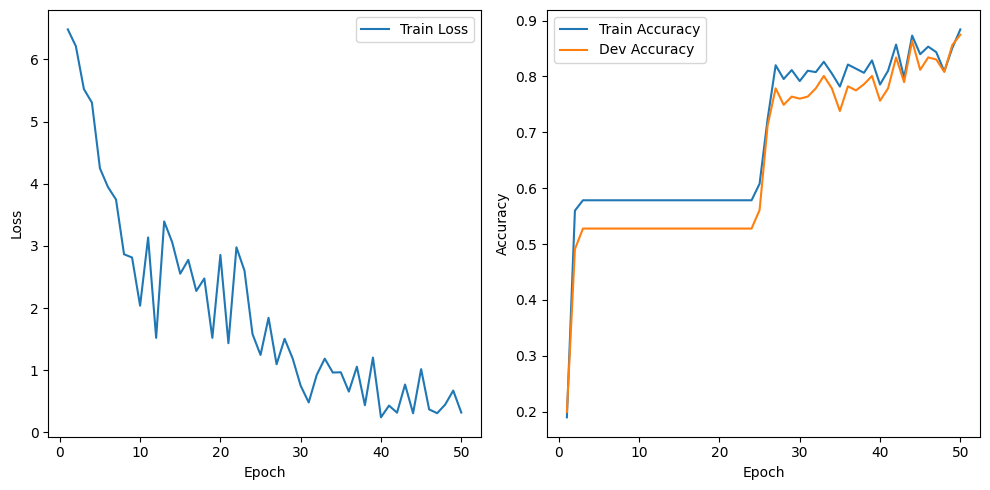

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.89      0.95      0.92        60
           2       0.54      0.72      0.62        18
           3       0.89      0.74      0.81        23
           4       0.50      0.44      0.47        27
           5       0.97      0.94      0.96        83

    accuracy                           0.87       271
   macro avg       0.80      0.80      0.80       271
weighted avg       0.88      0.87      0.87       271

F1-Score: 0.8748
Hidden layers configuration: [64, 32, 16, 8], Accuracy: 0.8745387453874539
Best model hidden layers configuration: Sequential(
  (0): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=9, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32,

In [ ]:
ann_model_non_ac_classroom = ann_model(non_ac_classroom_x, non_ac_classroom_y, test_size = 0.4)

In [ ]:
evaluate_ann(ann_model_non_ac_classroom, *train_test_split(non_ac_classroom_x, non_ac_classroom_y, test_size=0.2, random_state=42))[1]

ANN
      Metrics                  
Train Accuracy            88.35
      F1 Macro            78.96
      F1 Weighted         88.31
      Recall Macro        78.78
      Recall Weighted     88.35
      Precision Macro     80.25
      Precision Weighted  88.79
Test  Accuracy            87.08
      F1 Macro            80.34
      F1 Weighted          87.0
      Recall Macro        81.08
      Recall Weighted     87.08
      Precision Macro      81.0
      Precision Weighted  87.61

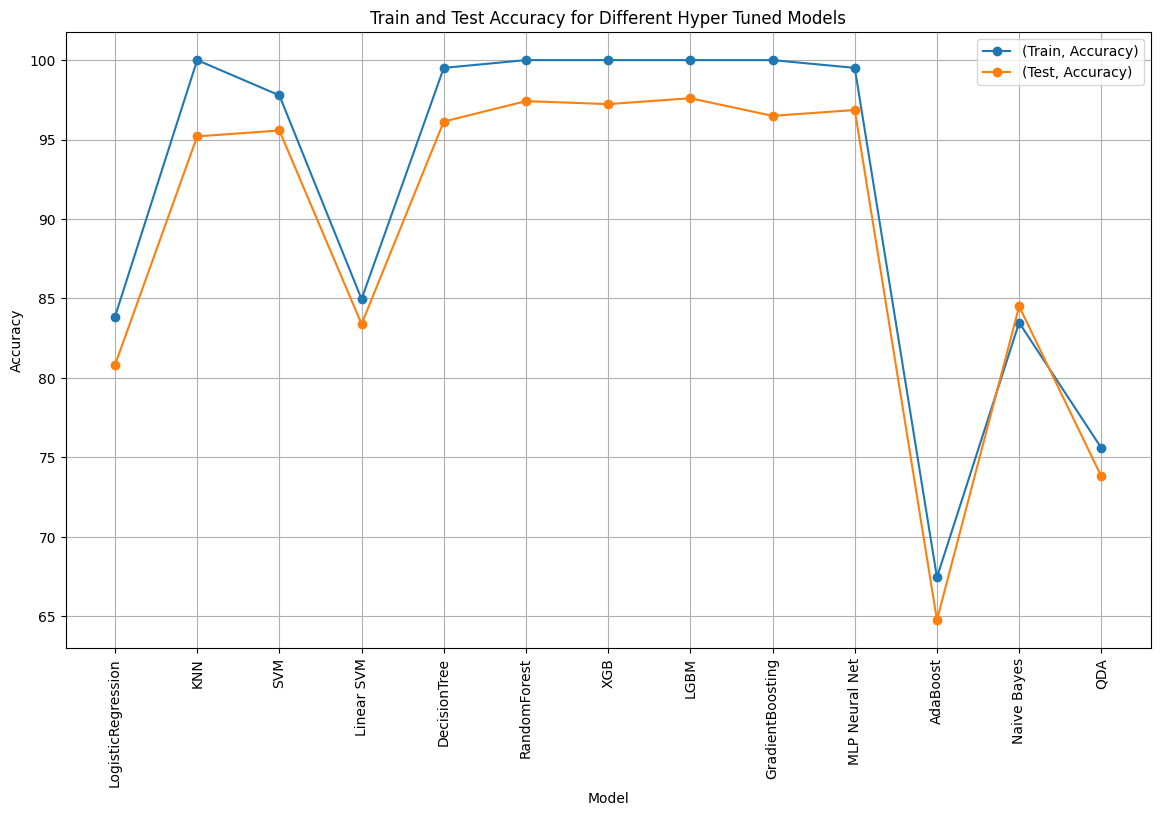

In [ ]:
metric_to_show = 'Accuracy'

result_non_ac_classroom_hyper_tuned.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(marker='o', figsize=(14, 8))
plt.title(f'Train and Test {metric_to_show} for Different Hyper Tuned Models')
plt.xlabel('Model')
plt.ylabel(metric_to_show)
plt.xticks(np.arange(len(result_non_ac_classroom_hyper_tuned.columns.to_numpy())), result_non_ac_classroom_hyper_tuned.columns.to_numpy(), rotation=90)
plt.legend(loc='best')
plt.grid(True)
plt.show()

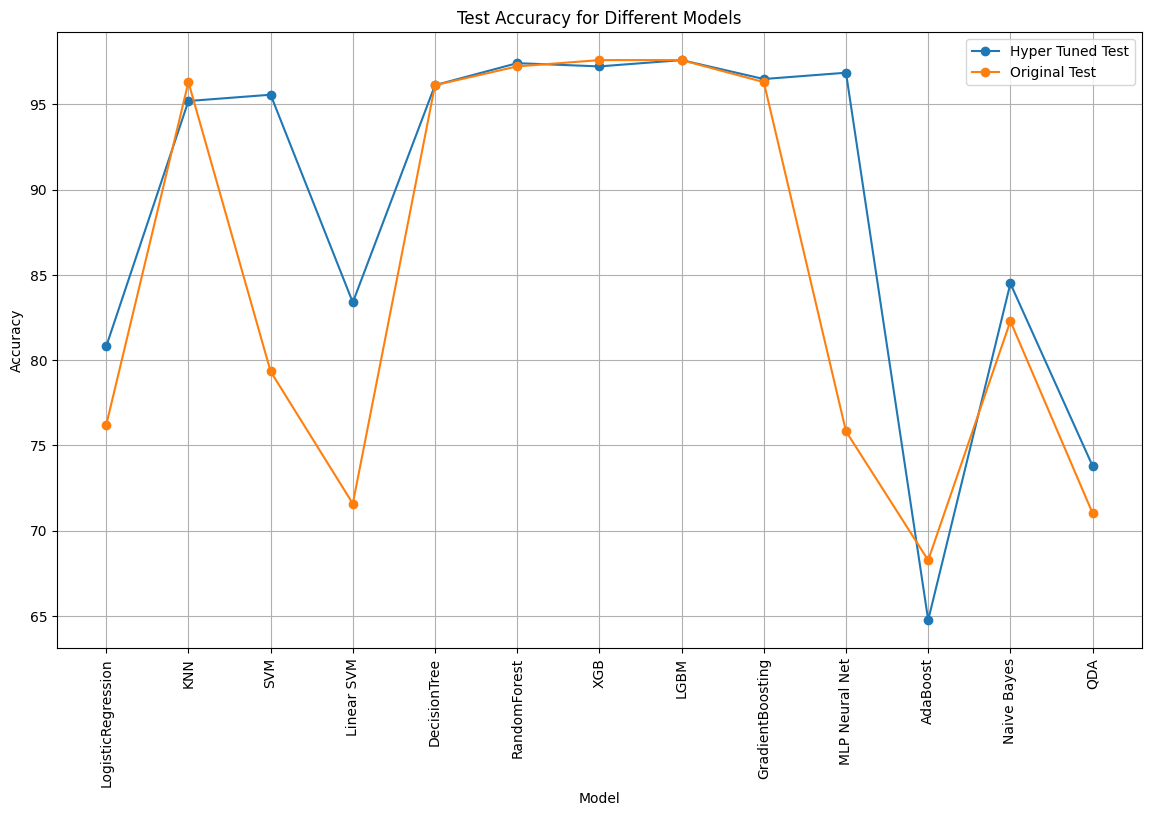

In [ ]:
metric_to_show = 'Accuracy'       # Accuracy, F1 Macro, F1 Weighted, Recall Macro, Recall Weighted, Precision Macro, Precision Weighted

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first set of data
# result_hyper_tuned.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8), title=f'Train and Test {metric_to_show} for Different Models')
result_non_ac_classroom_hyper_tuned.loc[[('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8), title=f'Test {metric_to_show} for Different Models')

# Plot the second set of data
# result.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8))
result_non_ac_classroom.loc[[('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8))

# Set labels, legends, and show the plot
ax.set_xlabel('Model')
ax.set_ylabel(metric_to_show)
ax.grid(True)
# ax.legend(['Hyper Tuned Train', 'Hyper Tuned Test', 'Original Train', 'Original Test'])
ax.legend(['Hyper Tuned Test', 'Original Test'])
plt.xticks(np.arange(len(result_non_ac_classroom.columns.to_numpy())), result_non_ac_classroom.columns.to_numpy(), rotation=90)
plt.show();

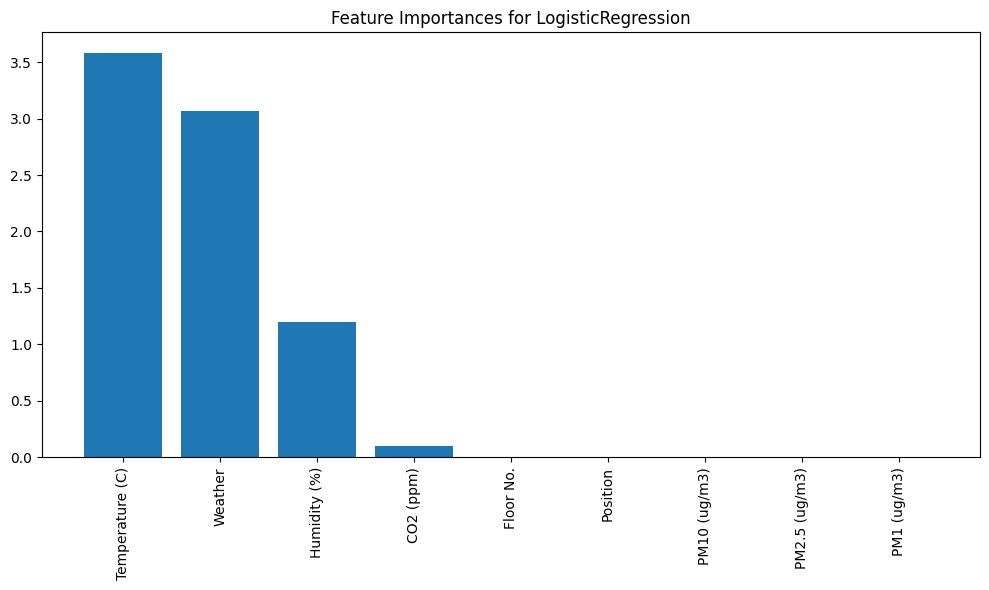

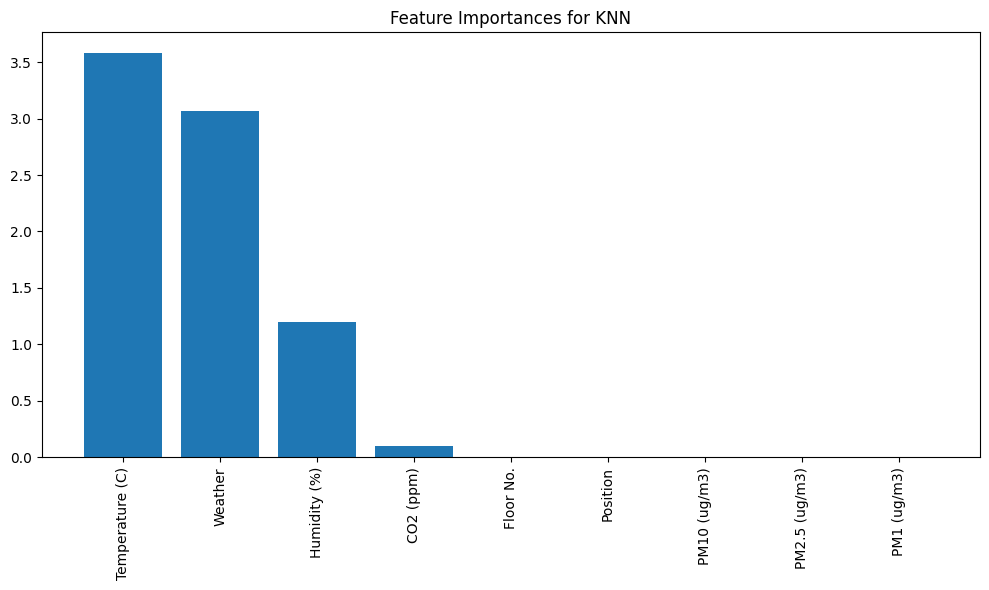

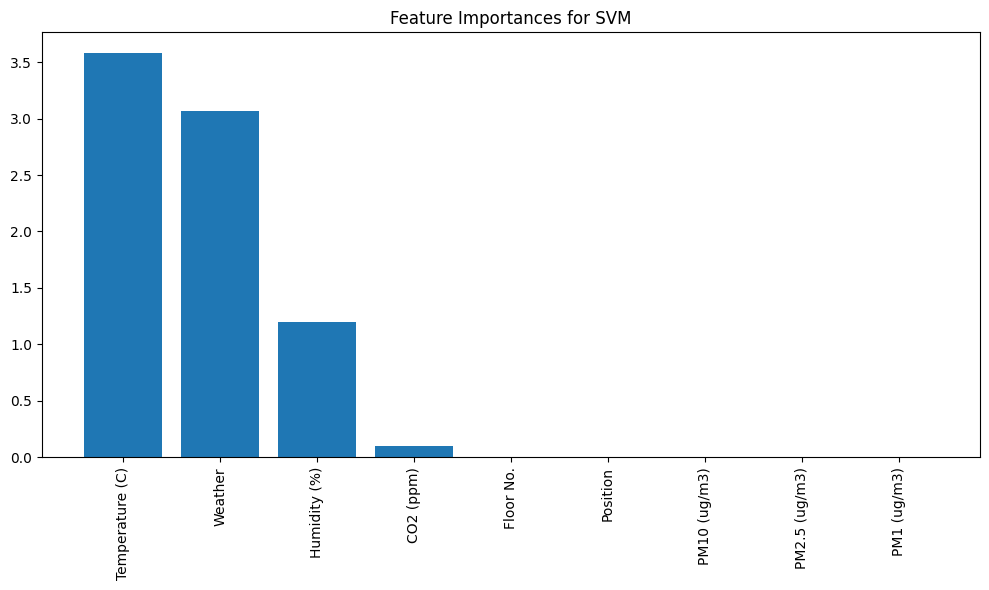

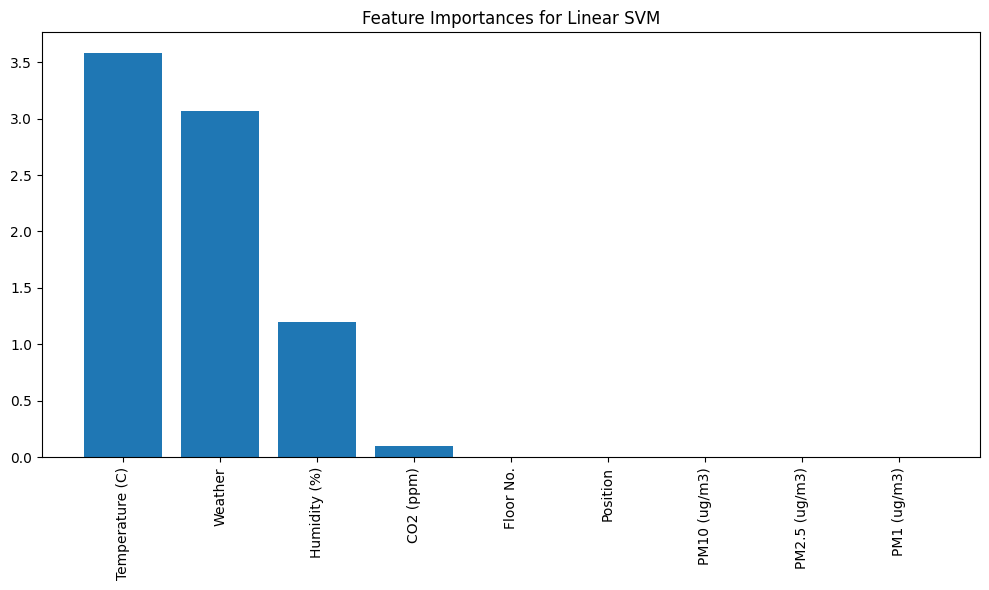

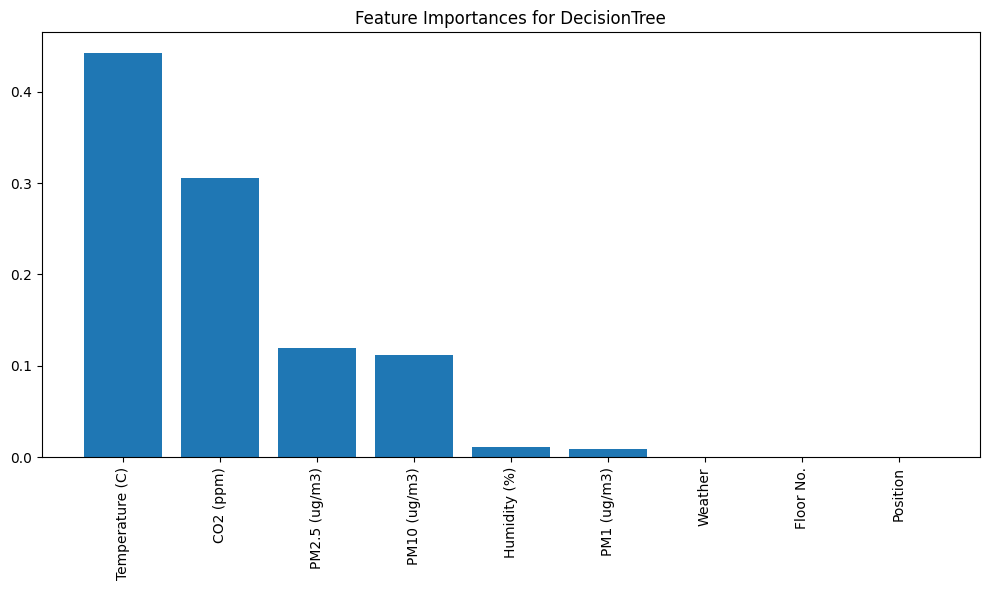

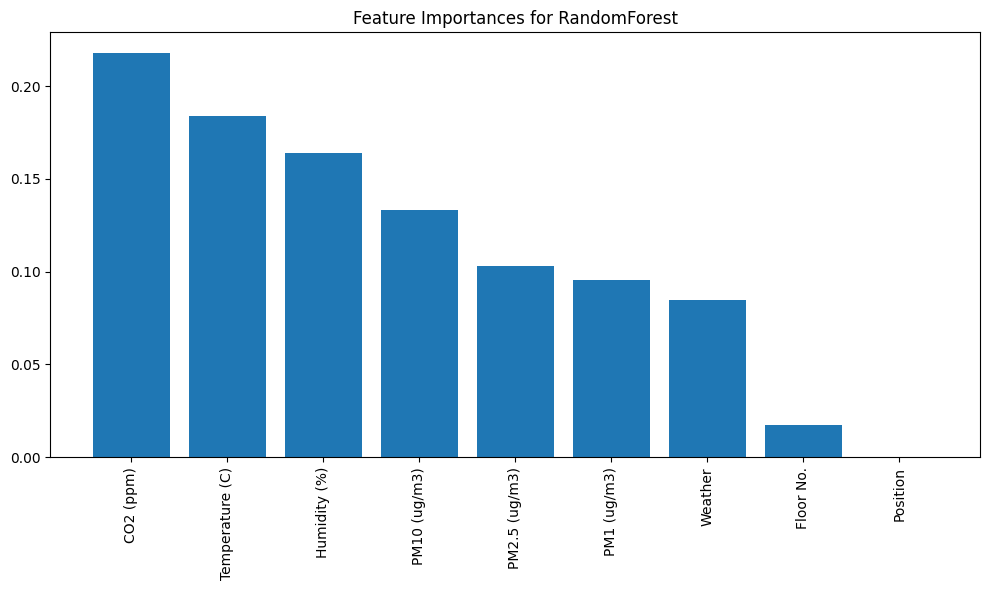

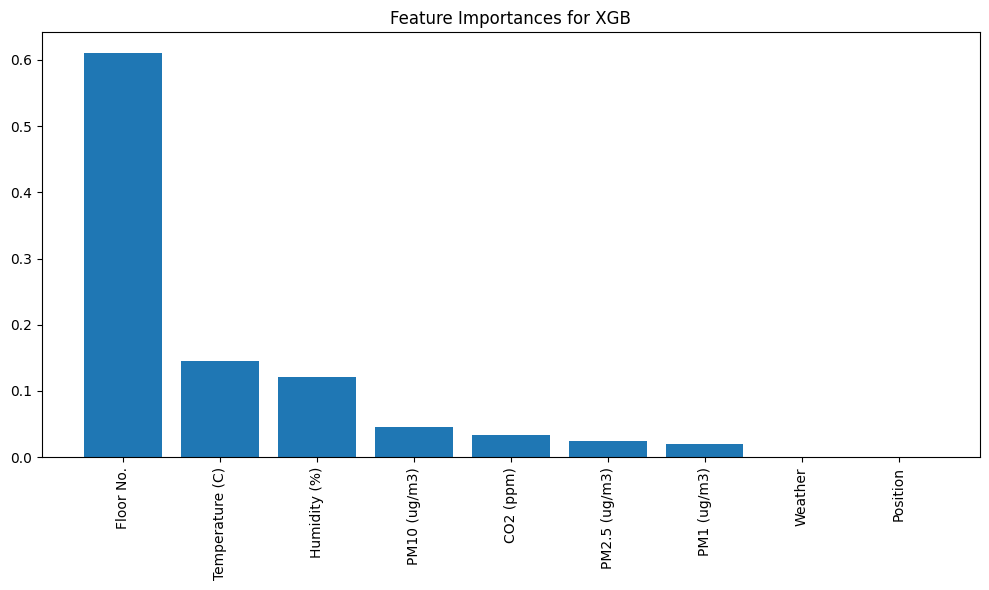

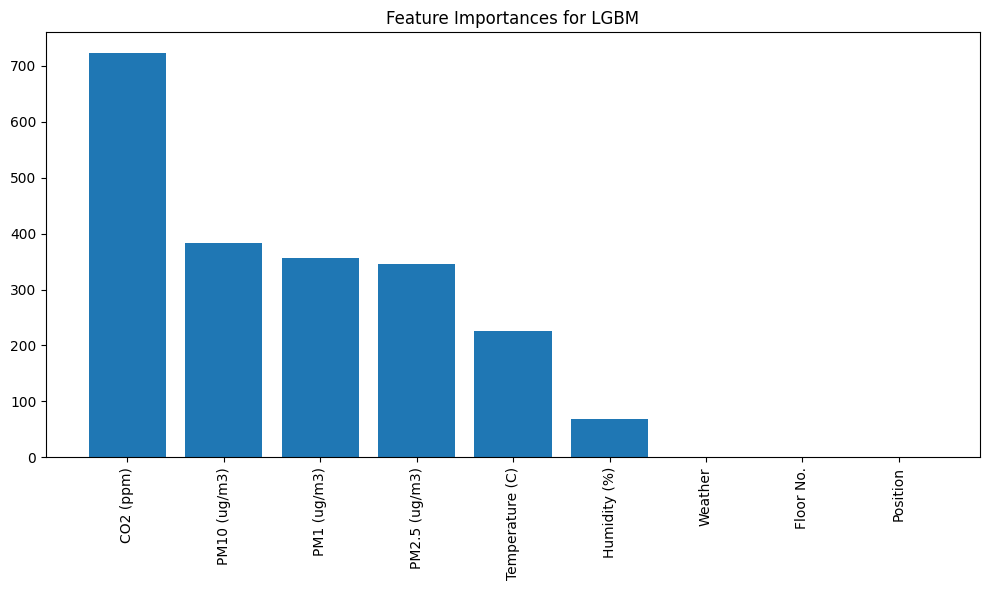

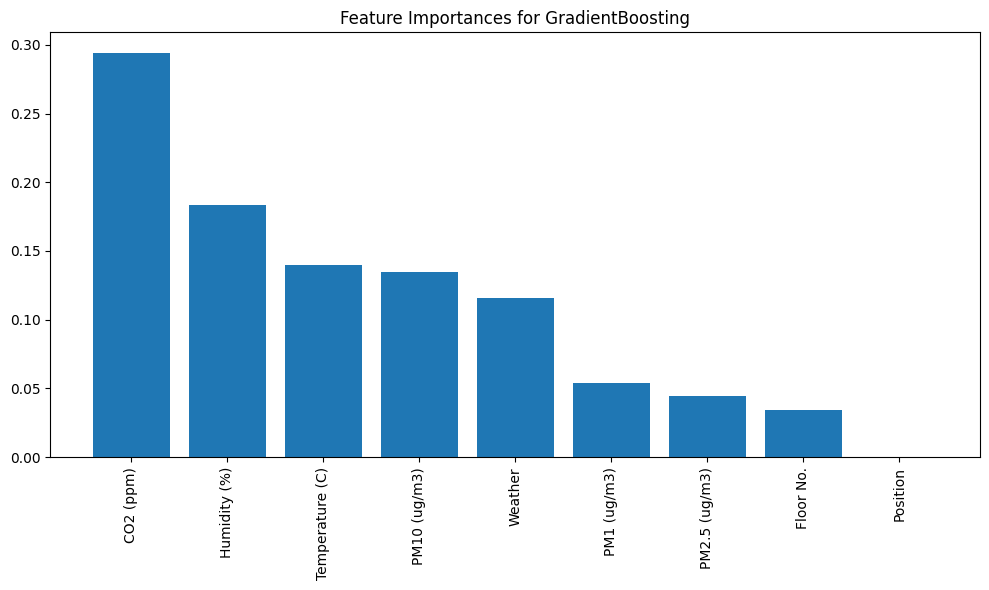

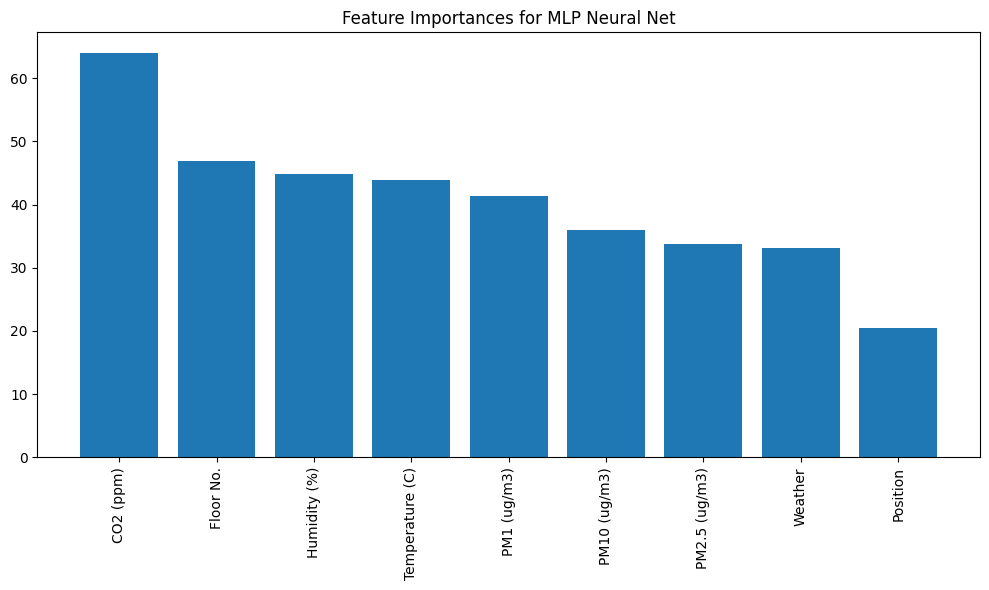

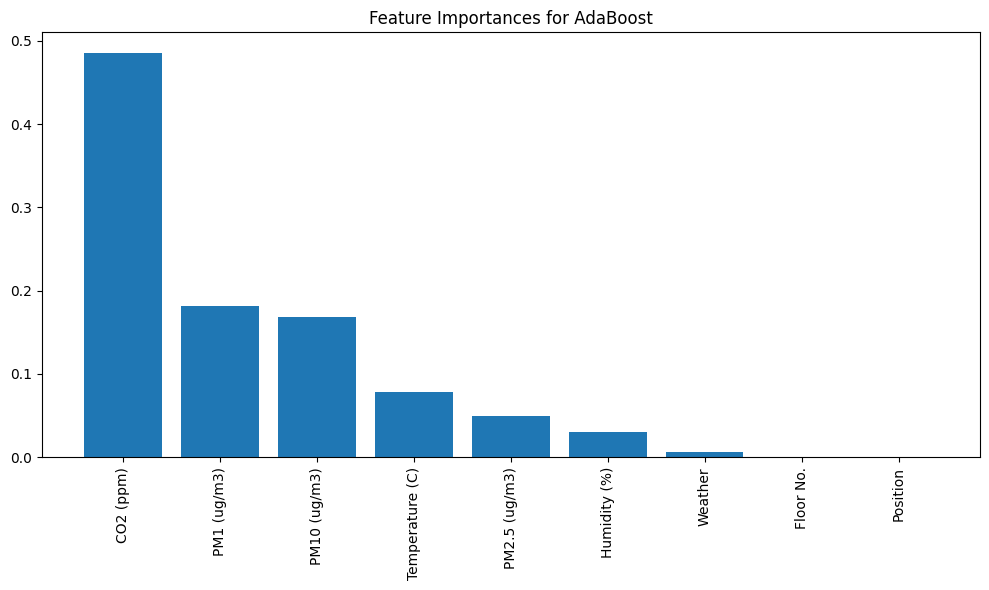

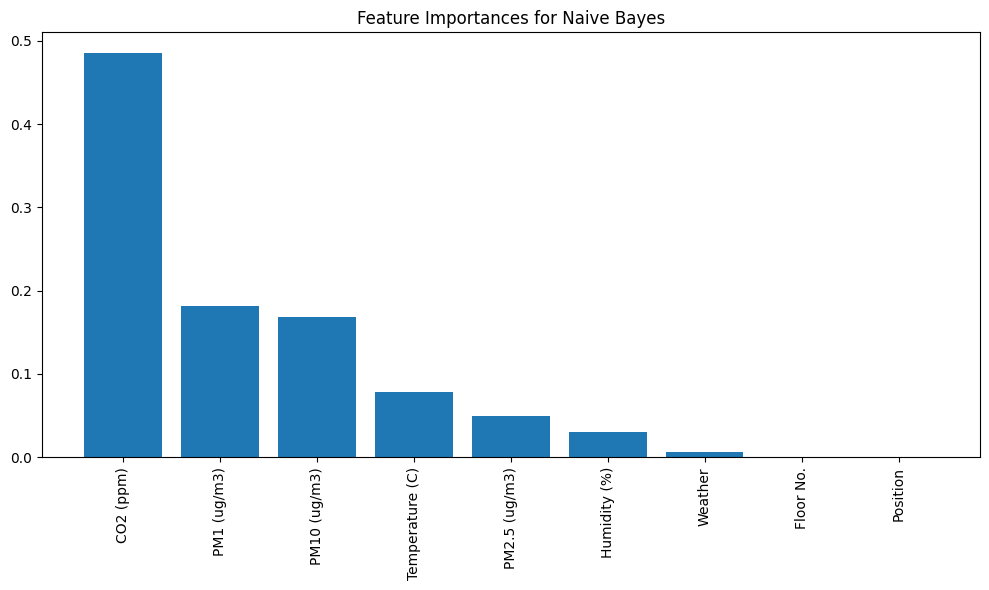

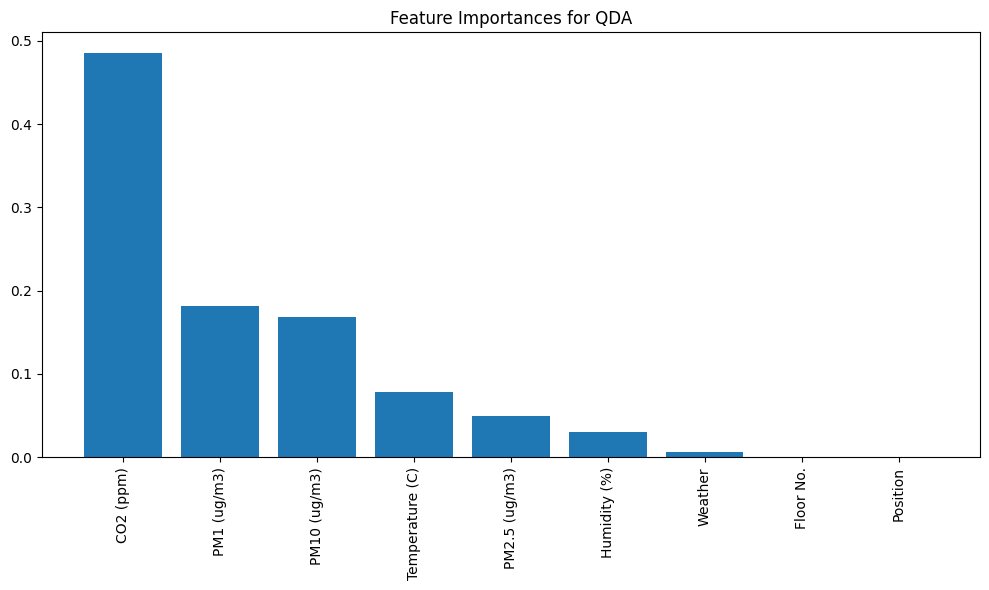

In [ ]:
model_names, models = [], []
for model_name in evaluator_non_ac_classroom_hyper_tuned.model_names:
    model_names.append(model_name)
    models.append(evaluator_non_ac_classroom_hyper_tuned.models[model_name].named_steps['classifier'])
plot_feature_importances(models, model_names, df_tmp.columns.to_numpy()[:-1])

Objects ->
- evaluator_non_ac_classroom
- evaluator_non_ac_classroom_hyper_tuned

Results ->
- result_non_ac_classroom
- result_non_ac_classroom_hyper_tuned

# Saving ML models

In [ ]:
with open("ac_lab_original_models_object_40_test.pkl", "wb") as file:
    joblib.dump(evaluator_ac_lab, file)

with open("ac_lab_hypertuned_models_object_40_test.pkl", "wb") as file:
    joblib.dump(evaluator_ac_lab_hyper_tuned, file)

with open("ac_classroom_original_models_object_40_test.pkl", "wb") as file:
    joblib.dump(evaluator_ac_classroom, file)

with open("ac_classroom_hypertuned_models_object_40_test.pkl", "wb") as file:
    joblib.dump(evaluator_ac_classroom_hyper_tuned, file)

with open("non_ac_classroom_original_models_object_40_test.pkl", "wb") as file:
    joblib.dump(evaluator_non_ac_classroom, file)

with open("non_ac_classroom_hypertuned_models_object_40_test.pkl", "wb") as file:
    joblib.dump(evaluator_non_ac_classroom_hyper_tuned, file)

In [ ]:
with open("ac_lab_ann_model_object_40_test.pkl", "wb") as file:
    torch.save(ann_model_ac_lab, file)

with open("ac_classroom_ann_model_object_40_test.pkl", "wb") as file:
    torch.save(ann_model_ac_classroom, file)

with open("non_ac_classroom_ann_model_object_40_test.pkl", "wb") as file:
    torch.save(ann_model_non_ac_classroom, file)

In [ ]:
# checking

with open("/content/ac_lab_hypertuned_models_object_40_test.pkl", "rb") as file:
    tmp = joblib.load(file)

model_name = 'MLP Neural Net'
scores = tmp.get_metric_scores(model_name)
print(f'Metric Scores for Model {model_name}:')
for metric, score in scores.items():
    print(f'{metric}: {score}')

Metric Scores for Model MLP Neural Net:
Train Accuracy: 0.990558615263572
Train F1 Macro: 0.9763425165179429
Train F1 Weighted: 0.9904363609691609
Train Recall Macro: 0.9641764863338181
Train Recall Weighted: 0.990558615263572
Train Precision Macro: 0.990815235430536
Train Precision Weighted: 0.9906684296202051
Train Confusion Matrix: [[1203    7    0    0]
 [   5  735    1    0]
 [   0    0  506    0]
 [   0    0   11   74]]
Test Accuracy: 0.9746462264150944
Test F1 Macro: 0.948302223342338
Test F1 Weighted: 0.9744902650792115
Test Recall Macro: 0.9373216576195762
Test Recall Weighted: 0.9746462264150944
Test Precision Macro: 0.9612730972945318
Test Precision Weighted: 0.9746150649055128
Test Confusion Matrix: [[799  15   0   0]
 [  9 451   3   0]
 [  0   4 364   3]
 [  0   0   9  39]]


In [ ]:
# checking
ob = torch.load("/content/ac_lab_ann_model_object_40_test.pkl")
evaluate_ann(ob, *train_test_split(ac_lab_x, ac_lab_y, test_size=0.4, random_state=42))[1]

ANN
      Metrics                  
Train Accuracy            88.12
      F1 Macro            82.65
      F1 Weighted         87.59
      Recall Macro        80.43
      Recall Weighted     88.12
      Precision Macro     87.01
      Precision Weighted   88.5
Test  Accuracy            87.38
      F1 Macro            81.12
      F1 Weighted         86.96
      Recall Macro        78.81
      Recall Weighted     87.38
      Precision Macro     85.23
      Precision Weighted   87.7

## Merging ANN with other models

### AC LAB

In [ ]:
with open("/content/ac_lab_original_models_object_40_test.pkl", "rb") as file:
    tmp1 = joblib.load(file)

tmp1 = evaluate_result(tmp1)

ob = torch.load("/content/ac_lab_ann_model_object_40_test.pkl")
tmp2 = evaluate_ann(ob, *train_test_split(ac_lab_x, ac_lab_y, test_size=0.4, random_state=42))[1]


tmp1.join(tmp2)

LogisticRegression    KNN    SVM Linear SVM  \
      Metrics                                                          
Train Accuracy                        75.18  97.29  83.32      73.25   
      F1 Macro                        60.59  96.02  75.55      53.63   
      F1 Weighted                     72.13  97.28  82.42       69.2   
      Recall Macro                    60.89  95.45  72.76      56.39   
      Recall Weighted                 75.18  97.29  83.32      73.25   
      Precision Macro                 67.28  96.65  86.75      52.53   
      Precision Weighted              71.66  97.29  84.91      66.94   
Test  Accuracy                        76.65  93.99  83.67      73.94   
      F1 Macro                        61.96  90.37   74.4      53.66   
      F1 Weighted                     73.78  93.96  82.78      70.18   
      Recall Macro                    61.53  89.84  71.37      55.85   
      Recall Weighted                 76.65  93.99  83.67      73.94   
      Precision Macro                 68.13  90.96  86.34      53.12   
      Precision Weighted              72.93  93.96  85.18      68.18   

                         DecisionTree RandomForest    XGB   LGBM  \
      Metrics                                                      
Train Accuracy                  100.0        100.0  99.92  99.84   
      F1 Macro                  100.0        100.0  99.79  99.73   
      F1 Weighted               100.0        100.0  99.92  99.84   
      Recall Macro              100.0        100.0  99.79  99.88   
      Recall Weighted           100.0        100.0  99.92  99.84   
      Precision Macro           100.0        100.0  99.79  99.59   
      Precision Weighted        100.0        100.0  99.92  99.84   
Test  Accuracy                  97.29        98.41  98.17   97.7   
      F1 Macro                  95.39        97.78  97.11  96.68   
      F1 Weighted               97.29        98.41  98.17   97.7   
      Recall Macro               95.3        97.68  96.87  96.45   
      Recall Weighted           97.29        98.41  98.17   97.7   
      Precision Macro           95.54        97.91  97.38  96.94   
      Precision Weighted        97.32        98.42  98.19  97.72   

                         GradientBoosting MLP Neural Net AdaBoost Naive Bayes  \
      Metrics                                                                   
Train Accuracy                      100.0          86.31    42.25       56.45   
      F1 Macro                      100.0          79.19    22.97       41.23   
      F1 Weighted                   100.0          85.64    31.42        50.4   
      Recall Macro                  100.0          77.41    33.63       50.38   
      Recall Weighted               100.0          86.31    42.25       56.45   
      Precision Macro               100.0          85.67    18.26       58.89   
      Precision Weighted            100.0          87.01    26.59       64.75   
Test  Accuracy                      97.88           86.5    43.51       57.49   
      F1 Macro                      96.58          78.88    23.29       41.67   
      F1 Weighted                   97.87          85.87    33.21       52.43   
      Recall Macro                   96.0          77.28    33.61       51.34   
      Recall Weighted               97.88           86.5    43.51       57.49   
      Precision Macro               97.26          84.01    18.84       58.82   
      Precision Weighted            97.89          86.93    28.76       66.36   

                            QDA    ANN  
      Metrics                           
Train Accuracy             33.4  88.12  
      F1 Macro             7.15  82.65  
      F1 Weighted         16.72  87.59  
      Recall Macro        14.29  80.43  
      Recall Weighted      33.4  88.12  
      Precision Macro      4.77  87.01  
      Precision Weighted  11.15   88.5  
Test  Accuracy            34.91  87.38  
      F1 Macro             7.39  81.12  
      F1 Weighted         18.06  86

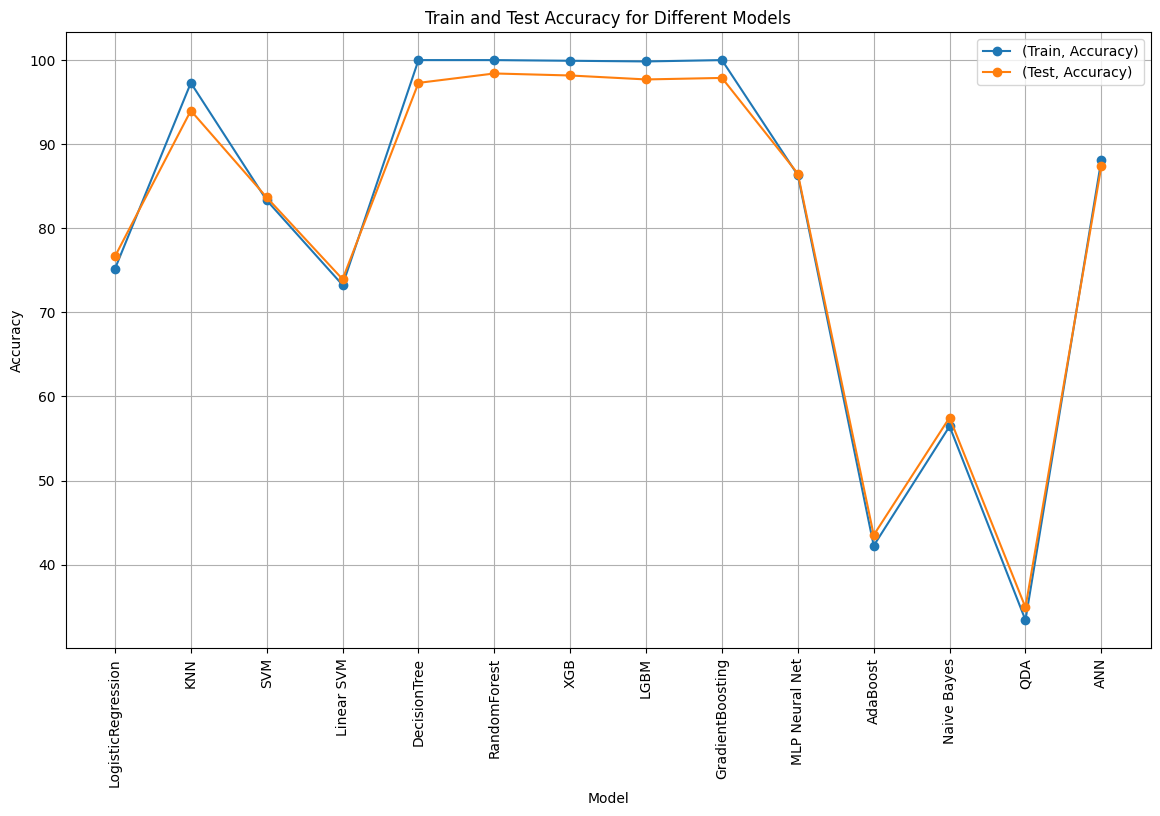

In [ ]:
metric_to_show = 'Accuracy'

tmp1.join(tmp2).loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(marker='o', figsize=(14, 8))
plt.title(f'Train and Test {metric_to_show} for Different Models')
plt.xlabel('Model')
plt.ylabel(metric_to_show)
plt.xticks(np.arange(len(tmp1.join(tmp2).columns.to_numpy())), tmp1.join(tmp2).columns.to_numpy(), rotation=90)
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
with open("/content/ac_lab_hypertuned_models_object_40_test.pkl", "rb") as file:
    tmp3 = joblib.load(file)

tmp3 = evaluate_result(tmp3)

ob = torch.load("/content/ac_lab_ann_model_object_40_test.pkl")
tmp4 = evaluate_ann(ob, *train_test_split(ac_lab_x, ac_lab_y, test_size=0.4, random_state=42))[1]


tmp3.join(tmp4)

LogisticRegression    KNN    SVM Linear SVM  \
      Metrics                                                          
Train Accuracy                        77.62  100.0  95.83      86.15   
      F1 Macro                        70.58  100.0  94.37      80.13   
      F1 Weighted                     75.69  100.0  95.82      85.09   
      Recall Macro                    70.03  100.0  93.44      77.99   
      Recall Weighted                 77.62  100.0  95.83      86.15   
      Precision Macro                 75.52  100.0  95.51      88.78   
      Precision Weighted              76.01  100.0  95.89      86.75   
Test  Accuracy                        78.24  96.52  93.93      86.32   
      F1 Macro                        69.87  95.01  91.52      80.41   
      F1 Weighted                     76.42  96.52  93.96      85.46   
      Recall Macro                    68.92  95.14  91.13      78.23   
      Recall Weighted                 78.24  96.52  93.93      86.32   
      Precision Macro                 75.92  94.89  92.09      88.26   
      Precision Weighted              77.03  96.53  94.05      87.04   

                         DecisionTree RandomForest    XGB   LGBM  \
      Metrics                                                      
Train Accuracy                  100.0        99.57  99.92  99.84   
      F1 Macro                  100.0         99.4  99.79  99.73   
      F1 Weighted               100.0        99.57  99.92  99.84   
      Recall Macro              100.0        99.34  99.79  99.88   
      Recall Weighted           100.0        99.57  99.92  99.84   
      Precision Macro           100.0        99.47  99.79  99.59   
      Precision Weighted        100.0        99.57  99.92  99.84   
Test  Accuracy                  96.82        97.88  98.23  97.88   
      F1 Macro                  94.21        97.41  97.22  97.05   
      F1 Weighted               96.79        97.88  98.23  97.88   
      Recall Macro              93.37        97.45  96.96  96.88   
      Recall Weighted           96.82        97.88  98.23  97.88   
      Precision Macro           95.27        97.41  97.51  97.24   
      Precision Weighted        96.81        97.91  98.24  97.89   

                         GradientBoosting MLP Neural Net AdaBoost Naive Bayes  \
      Metrics                                                                   
Train Accuracy                      100.0          97.25    69.79       65.38   
      F1 Macro                      100.0          95.69    53.34       60.57   
      F1 Weighted                   100.0          97.23    66.48       65.16   
      Recall Macro                  100.0          94.71    55.56       64.78   
      Recall Weighted               100.0          97.25    69.79       65.38   
      Precision Macro               100.0          96.87    58.95       65.15   
      Precision Weighted            100.0          97.29    67.37        68.9   
Test  Accuracy                      97.82          94.93    71.17       64.45   
      F1 Macro                      96.53          91.72    54.42       58.22   
      F1 Weighted                   97.81          94.88    68.36       64.65   
      Recall Macro                  95.93          90.65    55.72       63.22   
      Recall Weighted               97.82          94.93    71.17       64.45   
      Precision Macro               97.24          92.97    63.21       62.25   
      Precision Weighted            97.84           94.9    70.74       68.73   

                            QDA    ANN  
      Metrics                           
Train Accuracy            70.02  88.12  
      F1 Macro            59.54  82.65  
      F1 Weighted         68.01  87.59  
      Recall Macro        63.49  80.43  
      Recall Weighted     70.02  88.12  
      Precision Macro      59.2  87.01  
      Precision Weighted  67.77   88.5  
Test  Accuracy            69.99  87.38  
      F1 Macro            58.62  81.12  
      F1 Weighted         68.33  86

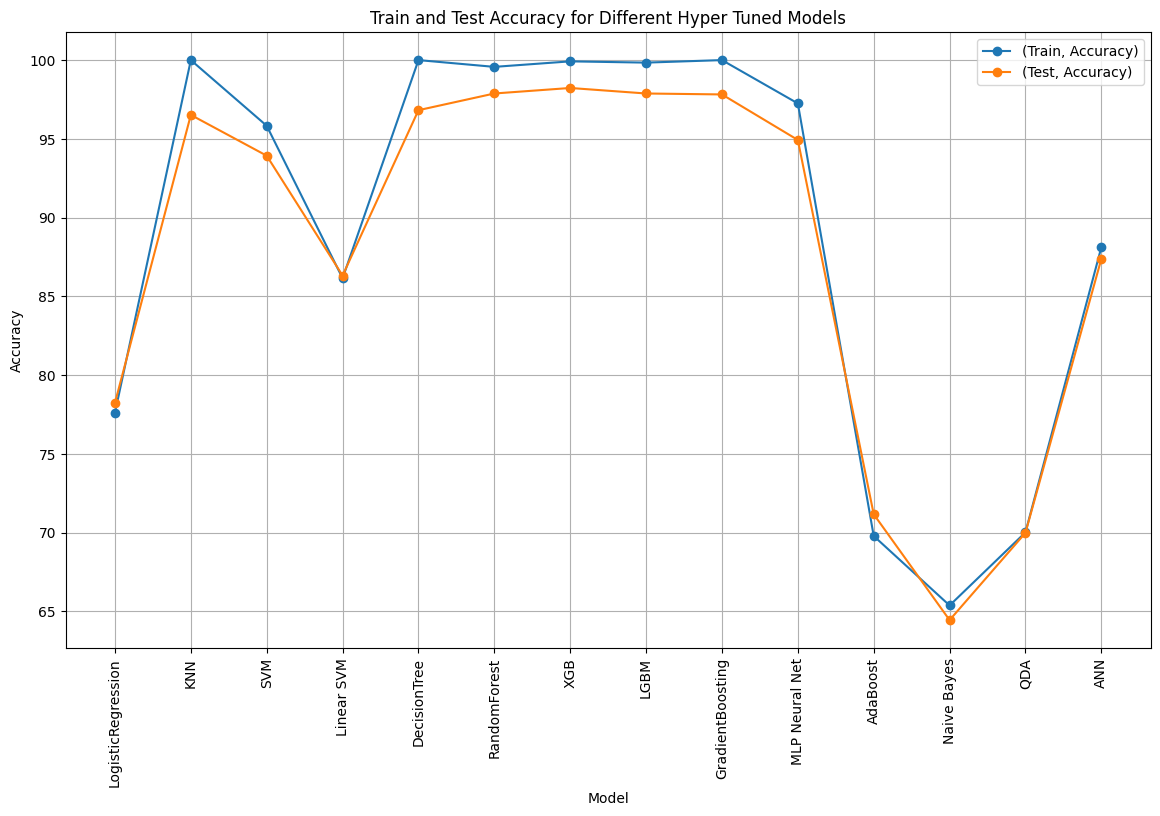

In [ ]:
metric_to_show = 'Accuracy'

tmp3.join(tmp4).loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(marker='o', figsize=(14, 8))
plt.title(f'Train and Test {metric_to_show} for Different Hyper Tuned Models')
plt.xlabel('Model')
plt.ylabel(metric_to_show)
plt.xticks(np.arange(len(tmp3.join(tmp4).columns.to_numpy())), tmp3.join(tmp4).columns.to_numpy(), rotation=90)
plt.legend(loc='best')
plt.grid(True)
plt.show()

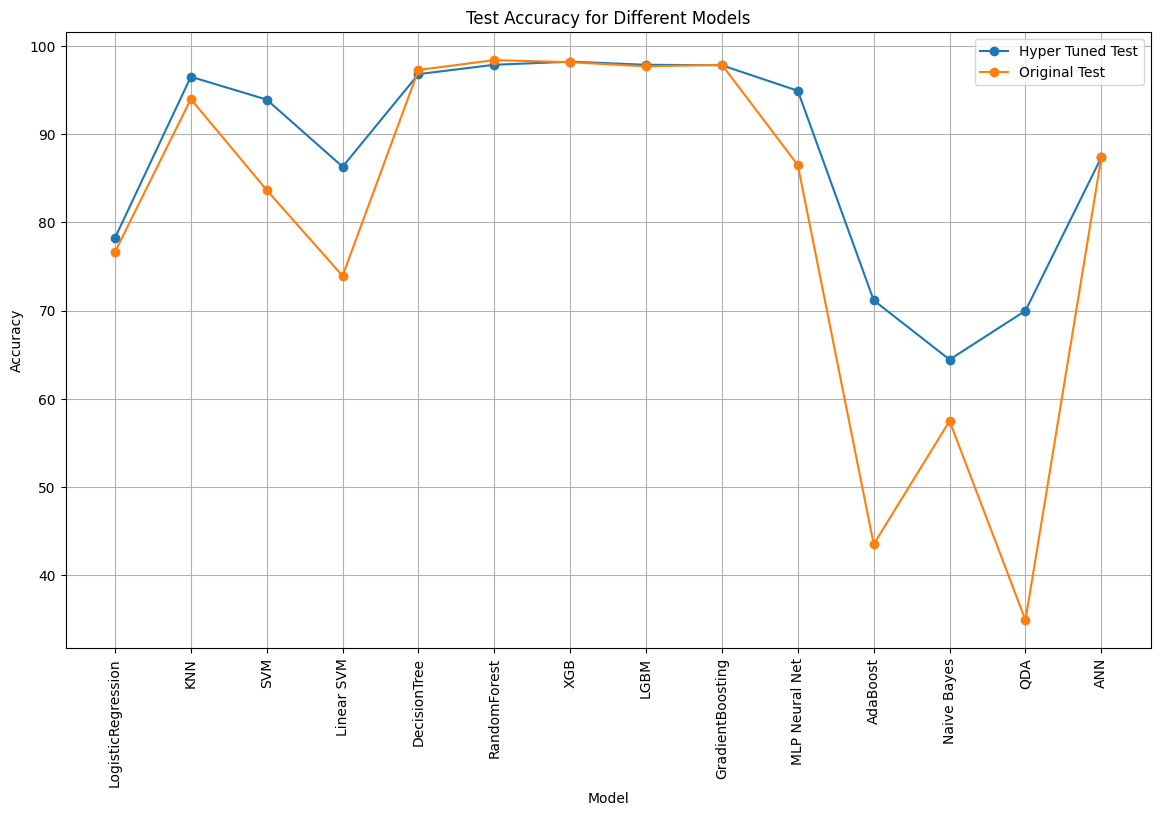

In [ ]:
metric_to_show = 'Accuracy'       # Accuracy, F1 Macro, F1 Weighted, Recall Macro, Recall Weighted, Precision Macro, Precision Weighted

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first set of data
# result_hyper_tuned.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8), title=f'Train and Test {metric_to_show} for Different Models')
tmp3.join(tmp4).loc[[('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8), title=f'Test {metric_to_show} for Different Models')

# Plot the second set of data
# result.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8))
tmp1.join(tmp2).loc[[('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8))

# Set labels, legends, and show the plot
ax.set_xlabel('Model')
ax.set_ylabel(metric_to_show)
ax.grid(True)
# ax.legend(['Hyper Tuned Train', 'Hyper Tuned Test', 'Original Train', 'Original Test'])
ax.legend(['Hyper Tuned Test', 'Original Test'])
plt.xticks(np.arange(len(tmp1.join(tmp2).columns.to_numpy())), tmp1.join(tmp2).columns.to_numpy(), rotation=90)
plt.show();

#### AC LAB FOR RESEARCH PAPER

In [ ]:
with open("/content/ac_lab_original_models_object_40_test.pkl", "rb") as file:
    tmp1 = joblib.load(file)

tmp1 = evaluate_result(tmp1)

ob = torch.load("/content/ac_lab_ann_model_object_40_test.pkl")
tmp2 = evaluate_ann(ob, *train_test_split(ac_lab_x, ac_lab_y, test_size=0.4, random_state=42))[1]

qwe = tmp1.join(tmp2).loc['Test'].loc[['Accuracy', 'F1 Weighted', 'Recall Weighted', 'Precision Weighted']][
    ['KNN', 'SVM', 'DecisionTree', 'RandomForest', 'XGB', 'GradientBoosting', 'MLP Neural Net', 'ANN']].T
qwe['F1 Weighted'] = qwe['F1 Weighted'].map(lambda x: round(x / 100, 2))
qwe['Recall Weighted'] = qwe['Recall Weighted'].map(lambda x: round(x / 100, 2))
qwe['Precision Weighted'] = qwe['Precision Weighted'].map(lambda x: round(x / 100, 2))
qwe

Metrics          Accuracy  F1 Weighted  Recall Weighted  Precision Weighted
KNN                  96.7         0.97             0.97                0.97
SVM                 91.16         0.91             0.91                0.91
DecisionTree        98.11         0.98             0.98                0.98
RandomForest        98.82         0.99             0.99                0.99
XGB                 99.23         0.99             0.99                0.99
GradientBoosting    98.58         0.99             0.99                0.99
MLP Neural Net      91.69         0.91             0.92                0.92
ANN                  93.4         0.93             0.93                0.94

In [ ]:
with open("/content/ac_lab_hypertuned_models_object_40_test.pkl", "rb") as file:
    tmp3 = joblib.load(file)

tmp3 = evaluate_result(tmp3)

ob = torch.load("/content/ac_lab_ann_model_object_40_test.pkl")
tmp4 = evaluate_ann(ob, *train_test_split(ac_lab_x, ac_lab_y, test_size=0.4, random_state=42))[1]

qwe_h = tmp3.join(tmp4).loc['Test'].loc[['Accuracy', 'F1 Weighted', 'Recall Weighted', 'Precision Weighted']][['KNN', 'SVM', 'DecisionTree', 'RandomForest', 'XGB', 'GradientBoosting', 'MLP Neural Net', 'ANN']].T
qwe_h['F1 Weighted'] = qwe_h['F1 Weighted'].map(lambda x: round(x / 100, 2))
qwe_h['Recall Weighted'] = qwe_h['Recall Weighted'].map(lambda x: round(x / 100, 2))
qwe_h['Precision Weighted'] = qwe_h['Precision Weighted'].map(lambda x: round(x / 100, 2))
qwe_h

Metrics          Accuracy  F1 Weighted  Recall Weighted  Precision Weighted
KNN                 97.76         0.98             0.98                0.98
SVM                 96.99         0.97             0.97                0.97
DecisionTree        98.82         0.99             0.99                0.99
RandomForest        98.41         0.98             0.98                0.98
XGB                 99.17         0.99             0.99                0.99
GradientBoosting    98.76         0.99             0.99                0.99
MLP Neural Net      97.46         0.97             0.97                0.97
ANN                  93.4         0.93             0.93                0.94

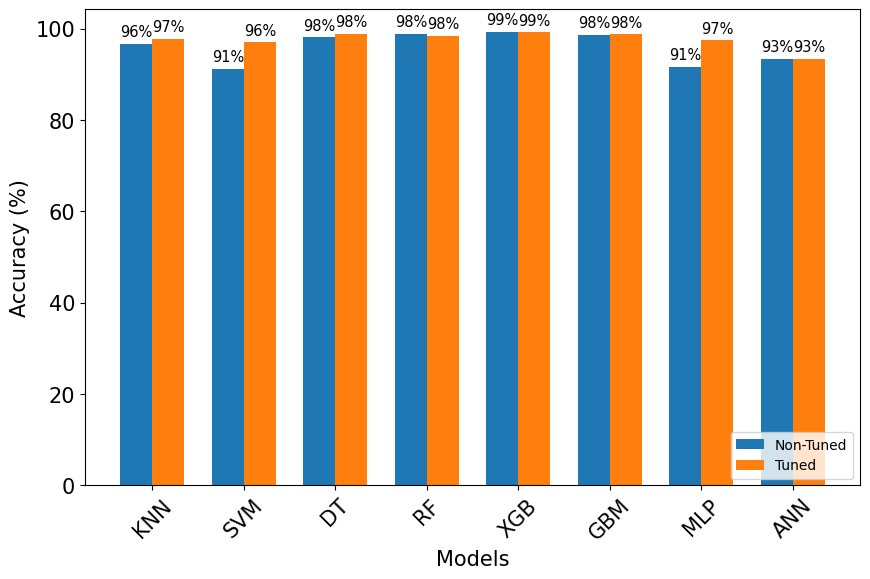

In [ ]:
# Sample data
models = qwe.rename(index = {'RandomForest': 'RF', 'MLP Neural Net': 'MLP', 'GradientBoosting': 'GBM', 'DecisionTree': 'DT'}).index.tolist()
accuracy_nontuned = qwe['Accuracy']
accuracy_tuned = qwe_h['Accuracy']

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 4))

bar_width = 0.35
index = np.arange(len(models))

# Plotting the bars
bars1 = ax.bar(index, accuracy_nontuned, width=bar_width, label='Non-Tuned')
bars2 = ax.bar(index + bar_width, accuracy_tuned, width=bar_width, label='Tuned')

# Annotate the bars with accuracy values
for bar, acc in zip(bars1, accuracy_nontuned):
    height = bar.get_height()
    ax.annotate(f'{int(acc)}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10.5)

for bar, acc in zip(bars2, accuracy_tuned):
    height = bar.get_height()
    ax.annotate(f'{int(acc)}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10.5)


# Set labels and title
ax.set_xlabel('Models', fontsize=15)
ax.set_ylabel('Accuracy (%)', fontsize=15)

# Rotate x-axis labels for better readability
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models, rotation=45, fontsize=15)
ax.tick_params(axis='y', which='both', labelsize=15)
# Add legend
ax.legend(loc='lower right')
plt.subplots_adjust(top=1.3)

# Show the plot
plt.show()

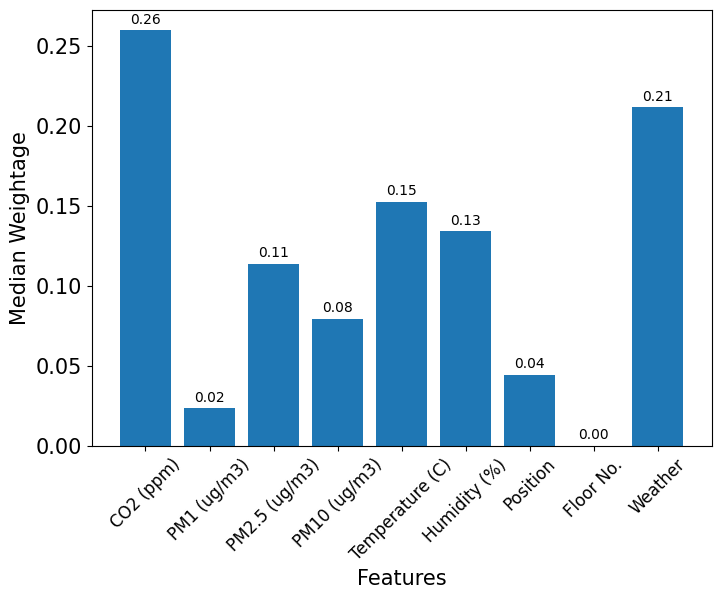

In [ ]:
with open("/content/ac_lab_hypertuned_models_object_40_test.pkl", "rb") as file:
    tmp3 = joblib.load(file)

est_mlp = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

feature_importances_dt = tmp3.models['DecisionTree'].named_steps['classifier'].feature_importances_
feature_importances_rf = tmp3.models['RandomForest'].named_steps['classifier'].feature_importances_
feature_importances_xgb = tmp3.models['XGB'].named_steps['classifier'].feature_importances_
feature_importances_gb = tmp3.models['GradientBoosting'].named_steps['classifier'].feature_importances_

all_feature_importances = np.vstack((feature_importances_dt, feature_importances_rf,
                                     feature_importances_xgb, feature_importances_gb))

mlp_feature_importances = est_mlp([np.sum(np.abs(layer), axis=1) for layer in [layer / np.linalg.norm(layer, ord=2, axis=0)
                            for layer in tmp3.models['MLP Neural Net'].named_steps['classifier'].coefs_]][0])

all_feature_importances = np.vstack((all_feature_importances, mlp_feature_importances))

fig, ax = plt.subplots(figsize=(8, 4))

# Plotting the bars
bars = ax.bar(df_tmp.columns[:-1].to_list(), np.median(all_feature_importances, axis=0))

ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('Median Weightage', fontsize=15)

plt.legend().set_visible(False)
ax.set_xticklabels(df_tmp.columns[:-1].to_list(), rotation=45, fontsize=12)
ax.tick_params(axis='y', which='both', labelsize=15)

# Annotate the bars with their values
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Show the plot
plt.subplots_adjust(top=1.2)
plt.show()

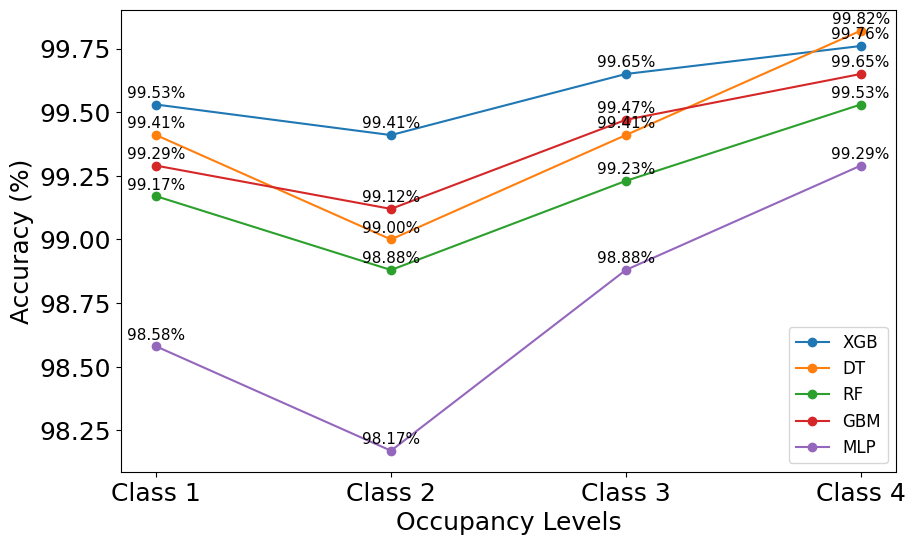

In [ ]:
def calculate_class_accuracy(obj = None, confusion_matrix_ann = None):
    each_model_each_class_accuracy, res = {}, None
    if obj is not None:
        for model in obj.model_names:
            confusion_matrix = obj.get_metric_scores(model)['Test Confusion Matrix']
            num_classes, class_accuracies = len(confusion_matrix), {}
            for i in range(num_classes):
                TP = confusion_matrix[i, i]
                FP = sum(confusion_matrix[:, i]) - TP
                FN = sum(confusion_matrix[i, :]) - TP
                TN = np.sum(confusion_matrix) - TP - FP - FN
                total_samples = TP + TN + FP + FN
                accuracy = (TP + TN) / total_samples
                class_accuracies[f'Class {i + 1}'] = {'Accuracy (%)': round(accuracy * 100.00, 2),
                                                      'Total Samples': total_samples,
                                                      'Total Correct Samples Predicted': TP + TN}
            each_model_each_class_accuracy[model] = class_accuracies
    if confusion_matrix_ann is not None:
        num_classes, class_accuracies = len(confusion_matrix_ann), {}
        for i in range(num_classes):
            TP = confusion_matrix_ann[i, i]
            FP = sum(confusion_matrix_ann[:, i]) - TP
            FN = sum(confusion_matrix_ann[i, :]) - TP
            TN = np.sum(confusion_matrix_ann) - TP - FP - FN
            total_samples = TP + TN + FP + FN
            accuracy = (TP + TN) / total_samples
            class_accuracies[f'Class {i}'] = {'Accuracy (%)': round(accuracy * 100.00, 2),
                                              'Total Samples': total_samples,
                                              'Total Correct Samples Predicted': TP + TN}
        each_model_each_class_accuracy['ANN'] = class_accuracies
    for model_name in each_model_each_class_accuracy:
        tmp = pd.DataFrame(each_model_each_class_accuracy[model_name]).T.stack(0).reset_index().rename(
            columns = {'level_0': 'Class', 'level_1': 'Attributes', 0: model_name}).set_index(
                ['Class', 'Attributes'], drop = True)
        if res is None:
            res = tmp
        else:
            res = res.join(tmp)
    return res

with open("/content/ac_lab_hypertuned_models_object_40_test.pkl", "rb") as file:
    tmp1 = joblib.load(file)

tmp2 = evaluate_ann(torch.load("/content/ac_lab_ann_model_object_40_test.pkl"),
                    *train_test_split(ac_lab_x, ac_lab_y, test_size=0.4, random_state=42))[0]['Test Confusion Matrix']

class_accuracy_df = calculate_class_accuracy(tmp1, tmp2).query("Attributes == 'Accuracy (%)'")

data_to_plot = class_accuracy_df[['XGB', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'MLP Neural Net']].rename(columns = {'DecisionTree': 'DT', 'RandomForest': 'RF', 'GradientBoosting': 'GBM', 'MLP Neural Net': 'MLP'})

ax = data_to_plot.plot(marker='o', figsize=(10, 6))

for model in data_to_plot.columns:
    for index, value in enumerate(data_to_plot[model]):
        ax.annotate(f'{value:.2f}%', (index, value), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=11)

new_labels = data_to_plot.index.get_level_values(0).to_list()
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels, fontsize=18)
ax.set_xlabel('Occupancy Levels', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)
ax.tick_params(axis='y', which='both', labelsize=18);
ax.legend(fontsize='large')
plt.show()

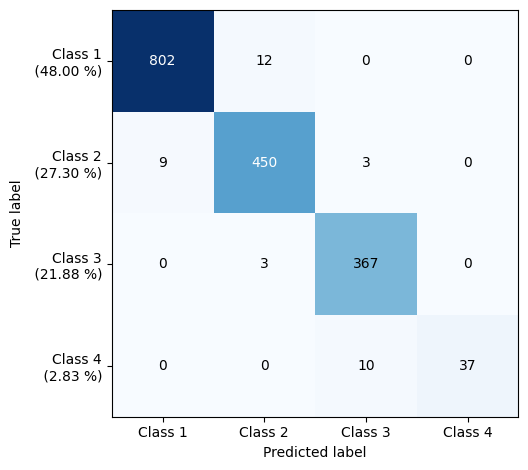

In [ ]:
def calculate_class_accuracy(obj = None, confusion_matrix_ann = None):
    each_model_each_class_accuracy = {}
    res = None
    if obj is not None:
        confusion_matrix = None
        c = 0
        for model in ['XGB', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'MLP Neural Net']:
            if confusion_matrix is not None:
                confusion_matrix = np.add(confusion_matrix, obj.get_metric_scores(model)['Test Confusion Matrix'])
            else:
                confusion_matrix = obj.get_metric_scores(model)['Test Confusion Matrix']
            c += 1
    if confusion_matrix_ann is not None:
        confusion_matrix = np.add(confusion_matrix, confusion_matrix_ann)
        c += 1
    return (confusion_matrix // c)

with open("/content/ac_lab_hypertuned_models_object_40_test.pkl", "rb") as file:
    tmp1 = joblib.load(file)

tmp2 = evaluate_ann(torch.load("/content/ac_lab_ann_model_object_40_test.pkl"),
                    *train_test_split(ac_lab_x, ac_lab_y, test_size=0.4, random_state=42))[0]['Test Confusion Matrix']

all_value_count = Counter(train_test_split(ac_lab_x, ac_lab_y, test_size=0.4, random_state=42)[3])
total = sum(all_value_count.values())

cm = calculate_class_accuracy(tmp1, tmp2)
fig, ax = plt.subplots()
ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=[f"Class {i}" for i in range(1, cm.shape[1] + 1)], yticklabels=[f"Class {i}\n ({((all_value_count[i - 1] / total) * 100.00):.2f} %)" for i in range(1, cm.shape[0] + 1)],
           ylabel='True label',
           xlabel='Predicted label')

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.xlim(-0.5, len(np.unique(ac_lab_y))-0.5)
plt.ylim(len(np.unique(ac_lab_y))-0.5, -0.5)
np.set_printoptions(precision=2)

plt.show();

### AC CLASSROOM

In [ ]:
with open("/content/ac_classroom_original_models_object_40_test.pkl", "rb") as file:
    tmp1 = joblib.load(file)

tmp1 = evaluate_result(tmp1)

ob = torch.load("/content/ac_classroom_ann_model_object_40_test.pkl")
tmp2 = evaluate_ann(ob, *train_test_split(ac_classroom_x, ac_classroom_y, test_size=0.4, random_state=42))[1]


tmp1.join(tmp2)

LogisticRegression    KNN    SVM Linear SVM  \
      Metrics                                                          
Train Accuracy                        72.55  96.28   81.6      67.67   
      F1 Macro                        64.14  95.59  72.96      48.36   
      F1 Weighted                     70.28  96.27  79.18       64.7   
      Recall Macro                    63.54  95.43  73.61      50.68   
      Recall Weighted                 72.55  96.28   81.6      67.67   
      Precision Macro                 66.48  95.76  88.99      62.64   
      Precision Weighted              68.57  96.27  83.33      65.35   
Test  Accuracy                         73.1  93.75  83.35      69.86   
      F1 Macro                        63.72   91.0  73.73      50.12   
      F1 Weighted                     71.31  93.78  81.47      67.45   
      Recall Macro                    62.02  90.87  73.63      50.75   
      Recall Weighted                  73.1  93.75  83.35      69.86   
      Precision Macro                 67.42  91.22  90.05      64.89   
      Precision Weighted              70.03  93.86  84.53      67.62   

                         DecisionTree RandomForest    XGB   LGBM  \
      Metrics                                                      
Train Accuracy                   99.8         99.8   99.6   99.5   
      F1 Macro                  99.73        99.73   99.6  99.43   
      F1 Weighted                99.8         99.8   99.6   99.5   
      Recall Macro              99.77        99.56  99.45  99.28   
      Recall Weighted            99.8         99.8   99.6   99.5   
      Precision Macro           99.69         99.9  99.75  99.58   
      Precision Weighted         99.8         99.8   99.6   99.5   
Test  Accuracy                  97.66        97.59  97.51  97.59   
      F1 Macro                   95.8        95.58  96.18  96.32   
      F1 Weighted               97.71        97.58  97.52  97.61   
      Recall Macro              96.99        95.05  96.52  96.55   
      Recall Weighted           97.66        97.59  97.51  97.59   
      Precision Macro           94.84        96.13  95.88  96.13   
      Precision Weighted        97.83        97.58  97.55  97.65   

                         GradientBoosting MLP Neural Net AdaBoost Naive Bayes  \
      Metrics                                                                   
Train Accuracy                       99.5          82.45    51.63       33.69   
      F1 Macro                      99.27          72.35    39.43       31.88   
      F1 Weighted                   99.49          79.88    40.88       22.22   
      Recall Macro                  98.95          72.76    41.17       49.44   
      Recall Weighted                99.5          82.45    51.63       33.69   
      Precision Macro               99.61           72.5    53.73       45.86   
      Precision Weighted             99.5          77.74     46.8       61.21   
Test  Accuracy                      97.81           84.4    50.26       34.06   
      F1 Macro                      96.37          73.03    38.82       31.03   
      F1 Weighted                   97.82          82.33    39.26       22.91   
      Recall Macro                  96.23          72.65    40.38       48.55   
      Recall Weighted               97.81           84.4    50.26       34.06   
      Precision Macro               96.52          73.93    54.71       46.04   
      Precision Weighted            97.85          80.49    46.79       64.49   

                            QDA    ANN  
      Metrics                           
Train Accuracy             2.87   81.8  
      F1 Macro             0.93  72.38  
      F1 Weighted          0.16  80.58  
      Recall Macro        16.67  74.18  
      Recall Weighted      2.87   81.8  
      Precision Macro      0.48  78.85  
      Precision Weighted   0.08  82.45  
Test  Accuracy             2.19  83.27  
      F1 Macro             0.71  71.13  
      F1 Weighted          0.09  82

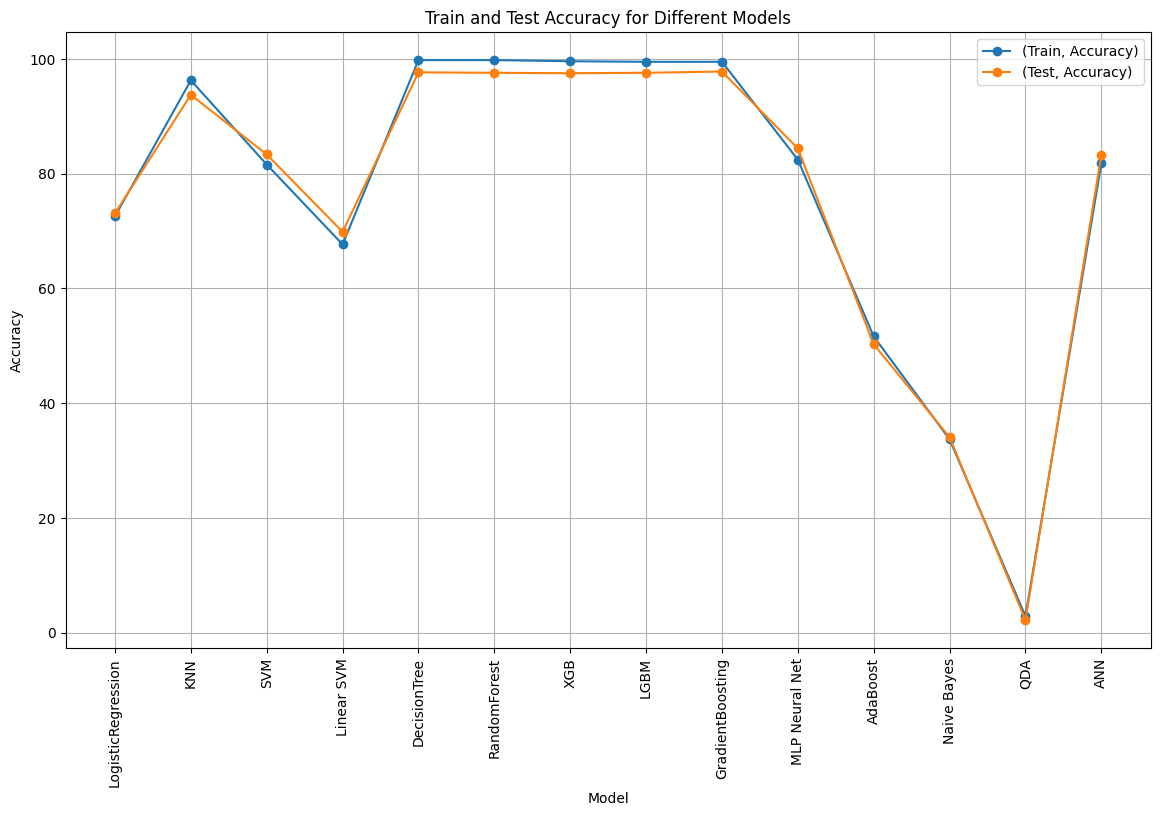

In [ ]:
metric_to_show = 'Accuracy'

tmp1.join(tmp2).loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(marker='o', figsize=(14, 8))
plt.title(f'Train and Test {metric_to_show} for Different Models')
plt.xlabel('Model')
plt.ylabel(metric_to_show)
plt.xticks(np.arange(len(tmp1.join(tmp2).columns.to_numpy())), tmp1.join(tmp2).columns.to_numpy(), rotation=90)
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
with open("/content/ac_classroom_hypertuned_models_object_40_test.pkl", "rb") as file:
    tmp3 = joblib.load(file)

tmp3 = evaluate_result(tmp3)

ob = torch.load("/content/ac_classroom_ann_model_object_40_test.pkl")
tmp4 = evaluate_ann(ob, *train_test_split(ac_classroom_x, ac_classroom_y, test_size=0.4, random_state=42))[1]


tmp3.join(tmp4)

LogisticRegression    KNN    SVM Linear SVM  \
      Metrics                                                          
Train Accuracy                        75.87  97.23  94.87      80.19   
      F1 Macro                        72.98  96.43   92.7      78.53   
      F1 Weighted                     74.38  97.22  94.69      79.81   
      Recall Macro                    72.29  96.27   91.5      77.61   
      Recall Weighted                 75.87  97.23  94.87      80.19   
      Precision Macro                 84.69  96.61  94.64      80.14   
      Precision Weighted              77.22  97.22  94.82      79.73   
Test  Accuracy                        75.96  94.72   94.8       79.5   
      F1 Macro                         73.3  91.94  92.45      75.84   
      F1 Weighted                     74.89  94.75  94.73      79.38   
      Recall Macro                    71.63  92.23  90.96      74.18   
      Recall Weighted                 75.96  94.72   94.8       79.5   
      Precision Macro                 84.57  91.74  94.26      77.79   
      Precision Weighted              76.83  94.82  94.77      79.44   

                         DecisionTree RandomForest    XGB   LGBM  \
      Metrics                                                      
Train Accuracy                  99.04        99.35   99.6   99.3   
      F1 Macro                  98.47        99.09   99.6   99.1   
      F1 Weighted               99.05        99.34   99.6  99.29   
      Recall Macro              98.37        98.79  99.45  98.95   
      Recall Weighted           99.04        99.35   99.6   99.3   
      Precision Macro           98.57         99.4  99.75  99.25   
      Precision Weighted        99.05        99.34   99.6  99.29   
Test  Accuracy                  97.06        97.59  97.59  97.51   
      F1 Macro                  95.02        96.06  96.26  96.07   
      F1 Weighted               97.11        97.58  97.61  97.52   
      Recall Macro              95.17        95.26  96.77  95.75   
      Recall Weighted           97.06        97.59  97.59  97.51   
      Precision Macro           95.06        96.91   95.8  96.41   
      Precision Weighted        97.22        97.59  97.64  97.54   

                         GradientBoosting MLP Neural Net AdaBoost Naive Bayes  \
      Metrics                                                                   
Train Accuracy                       99.8          98.54    52.99        54.4   
      F1 Macro                      99.73          98.15    39.83       52.32   
      F1 Weighted                    99.8          98.54    48.06       49.99   
      Recall Macro                  99.66          98.11    42.47       57.79   
      Recall Weighted                99.8          98.54    52.99        54.4   
      Precision Macro                99.8          98.19    46.55       56.94   
      Precision Weighted             99.8          98.55    54.57       58.54   
Test  Accuracy                      97.51          96.01    56.52       57.27   
      F1 Macro                      95.86          94.25    42.46        53.0   
      F1 Weighted                   97.54          96.04    52.01       54.01   
      Recall Macro                  96.07          94.66    44.66       58.64   
      Recall Weighted               97.51          96.01    56.52       57.27   
      Precision Macro                95.7          93.92    50.62       57.86   
      Precision Weighted            97.59          96.11    59.99       64.08   

                            QDA    ANN  
      Metrics                           
Train Accuracy            72.75   81.8  
      F1 Macro            71.13  72.38  
      F1 Weighted         73.09  80.58  
      Recall Macro         72.7  74.18  
      Recall Weighted     72.75   81.8  
      Precision Macro     72.67  78.85  
      Precision Weighted  77.45  82.45  
Test  Accuracy            76.79  83.27  
      F1 Macro            74.12  71.13  
      F1 Weighted         77.68  82

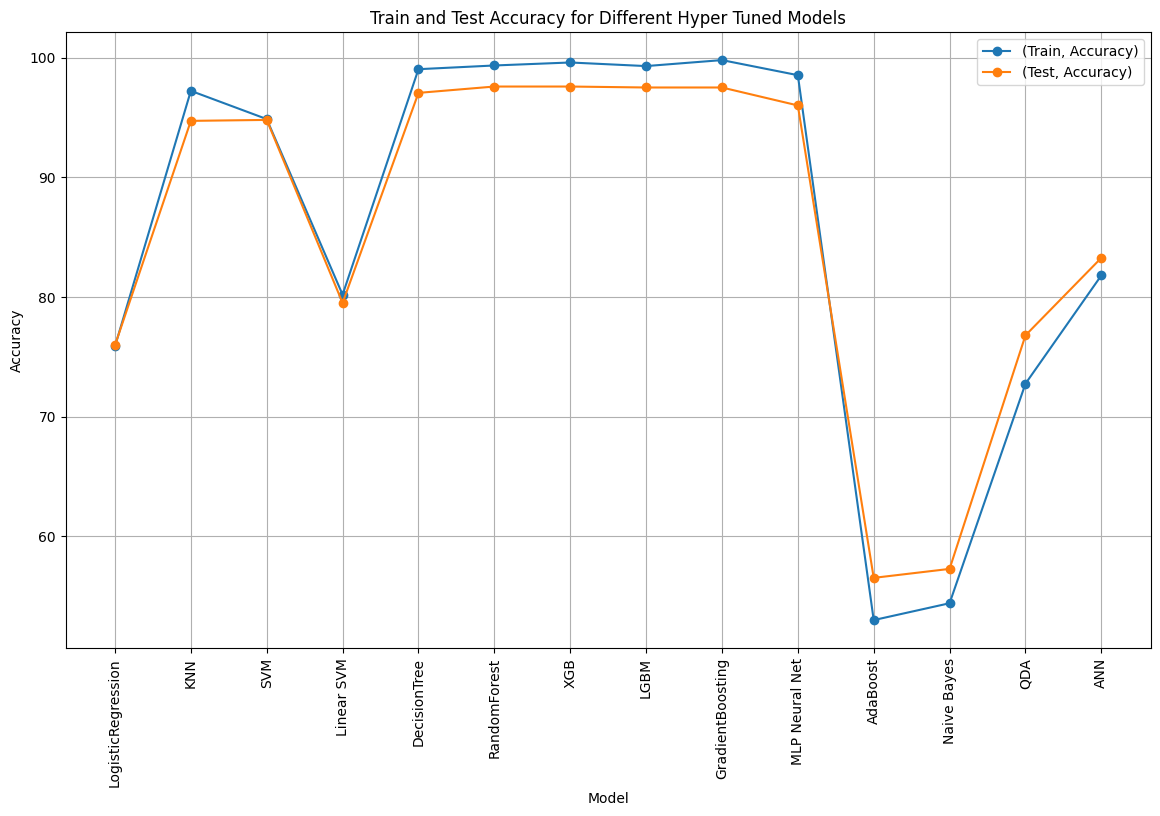

In [ ]:
metric_to_show = 'Accuracy'

tmp3.join(tmp4).loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(marker='o', figsize=(14, 8))
plt.title(f'Train and Test {metric_to_show} for Different Hyper Tuned Models')
plt.xlabel('Model')
plt.ylabel(metric_to_show)
plt.xticks(np.arange(len(tmp3.join(tmp4).columns.to_numpy())), tmp3.join(tmp4).columns.to_numpy(), rotation=90)
plt.legend(loc='best')
plt.grid(True)
plt.show()

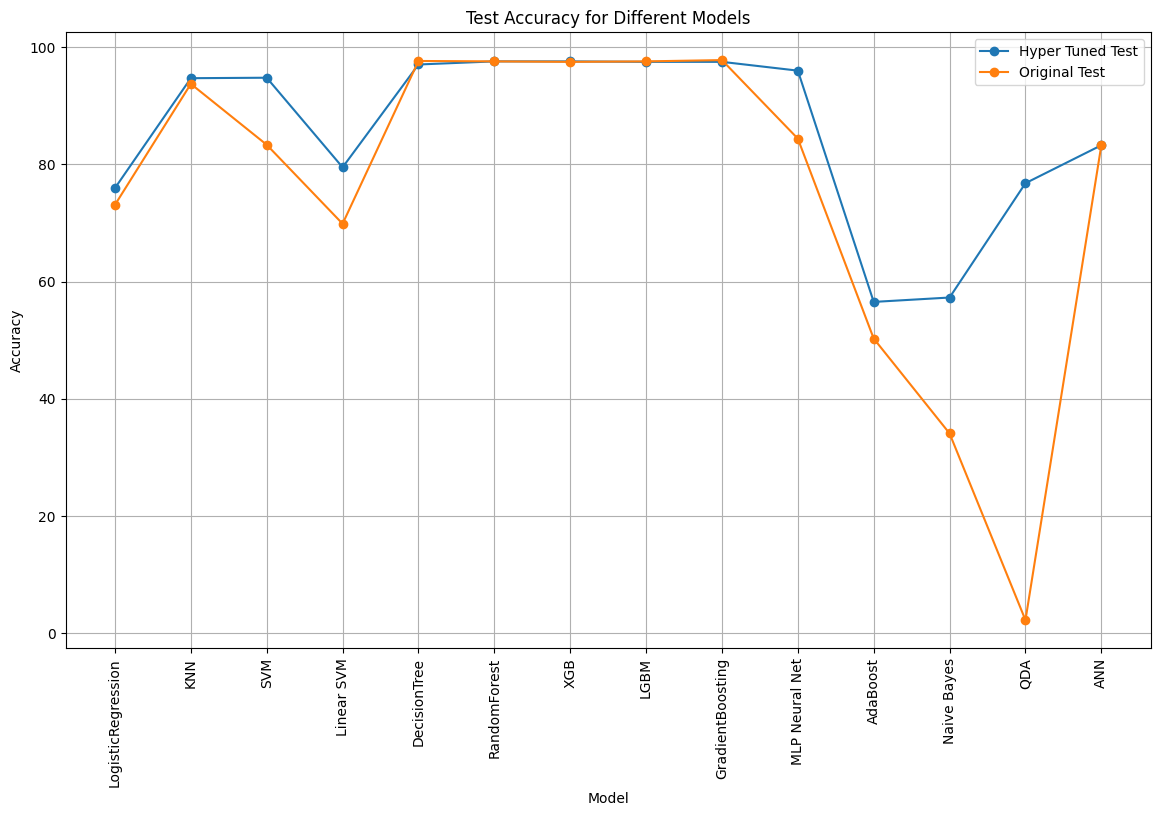

In [ ]:
metric_to_show = 'Accuracy'       # Accuracy, F1 Macro, F1 Weighted, Recall Macro, Recall Weighted, Precision Macro, Precision Weighted

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first set of data
# result_hyper_tuned.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8), title=f'Train and Test {metric_to_show} for Different Models')
tmp3.join(tmp4).loc[[('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8), title=f'Test {metric_to_show} for Different Models')

# Plot the second set of data
# result.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8))
tmp1.join(tmp2).loc[[('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8))

# Set labels, legends, and show the plot
ax.set_xlabel('Model')
ax.set_ylabel(metric_to_show)
ax.grid(True)
# ax.legend(['Hyper Tuned Train', 'Hyper Tuned Test', 'Original Train', 'Original Test'])
ax.legend(['Hyper Tuned Test', 'Original Test'])
plt.xticks(np.arange(len(tmp1.join(tmp2).columns.to_numpy())), tmp1.join(tmp2).columns.to_numpy(), rotation=90)
plt.show();

### NON AC CLASSROOM

In [ ]:
with open("/content/non_ac_classroom_original_models_object_40_test.pkl", "rb") as file:
    tmp1 = joblib.load(file)

tmp1 = evaluate_result(tmp1)

ob = torch.load("/content/non_ac_classroom_ann_model_object_40_test.pkl")
tmp2 = evaluate_ann(ob, *train_test_split(non_ac_classroom_x, non_ac_classroom_y, test_size=0.4, random_state=42))[1]


tmp1.join(tmp2)

LogisticRegression    KNN    SVM Linear SVM  \
      Metrics                                                          
Train Accuracy                        77.07  97.53  82.12      71.89   
      F1 Macro                        55.99  96.07  68.99      41.59   
      F1 Weighted                     72.66  97.54   80.4      64.24   
      Recall Macro                    58.56  96.28  71.11      47.77   
      Recall Weighted                 77.07  97.53  82.12      71.89   
      Precision Macro                 60.52  95.87  72.52      54.42   
      Precision Weighted              72.39  97.55  81.89      68.01   
Test  Accuracy                         76.2  96.31  79.34      71.59   
      F1 Macro                         55.9  94.21  66.44      42.59   
      F1 Weighted                     70.65  96.23  77.14       62.6   
      Recall Macro                    59.84  93.87   68.1      48.84   
      Recall Weighted                  76.2  96.31  79.34      71.59   
      Precision Macro                 61.06  94.76   69.4      54.63   
      Precision Weighted              71.09  96.29  77.85      64.59   

                         DecisionTree RandomForest    XGB   LGBM  \
      Metrics                                                      
Train Accuracy                  100.0        100.0  100.0  100.0   
      F1 Macro                  100.0        100.0  100.0  100.0   
      F1 Weighted               100.0        100.0  100.0  100.0   
      Recall Macro              100.0        100.0  100.0  100.0   
      Recall Weighted           100.0        100.0  100.0  100.0   
      Precision Macro           100.0        100.0  100.0  100.0   
      Precision Weighted        100.0        100.0  100.0  100.0   
Test  Accuracy                  96.13        97.23   97.6   97.6   
      F1 Macro                   93.8        95.39  96.32  96.12   
      F1 Weighted               96.12        97.22  97.61   97.6   
      Recall Macro              93.85        95.13  96.08  95.78   
      Recall Weighted           96.13        97.23   97.6   97.6   
      Precision Macro           93.78        95.66   96.6  96.48   
      Precision Weighted        96.12        97.21  97.63  97.61   

                         GradientBoosting MLP Neural Net AdaBoost Naive Bayes  \
      Metrics                                                                   
Train Accuracy                      100.0          77.07    69.54       81.13   
      F1 Macro                      100.0           53.1    63.58       75.12   
      F1 Weighted                   100.0          71.31    70.84       82.33   
      Recall Macro                  100.0          58.03    63.04       78.52   
      Recall Weighted               100.0          77.07    69.54       81.13   
      Precision Macro               100.0          49.25    71.41       78.15   
      Precision Weighted            100.0          66.75    78.37       88.87   
Test  Accuracy                      96.31          75.83    68.27       82.29   
      F1 Macro                      94.49           53.3    61.31       77.98   
      F1 Weighted                   96.31          69.19    68.99       83.54   
      Recall Macro                  94.53          59.38    59.77       80.44   
      Recall Weighted               96.31          75.83    68.27       82.29   
      Precision Macro               94.48          48.88    68.43        80.5   
      Precision Weighted            96.32          64.09    73.85       89.17   

                            QDA    ANN  
      Metrics                           
Train Accuracy            72.38  88.41  
      F1 Macro            56.02  79.12  
      F1 Weighted         67.14  88.35  
      Recall Macro         58.6  79.05  
      Recall Weighted     72.38  88.41  
      Precision Macro     65.99  80.14  
      Precision Weighted  74.67  88.74  
Test  Accuracy            71.03  87.64  
      F1 Macro            57.81  79.59  
      F1 Weighted         66.13  87

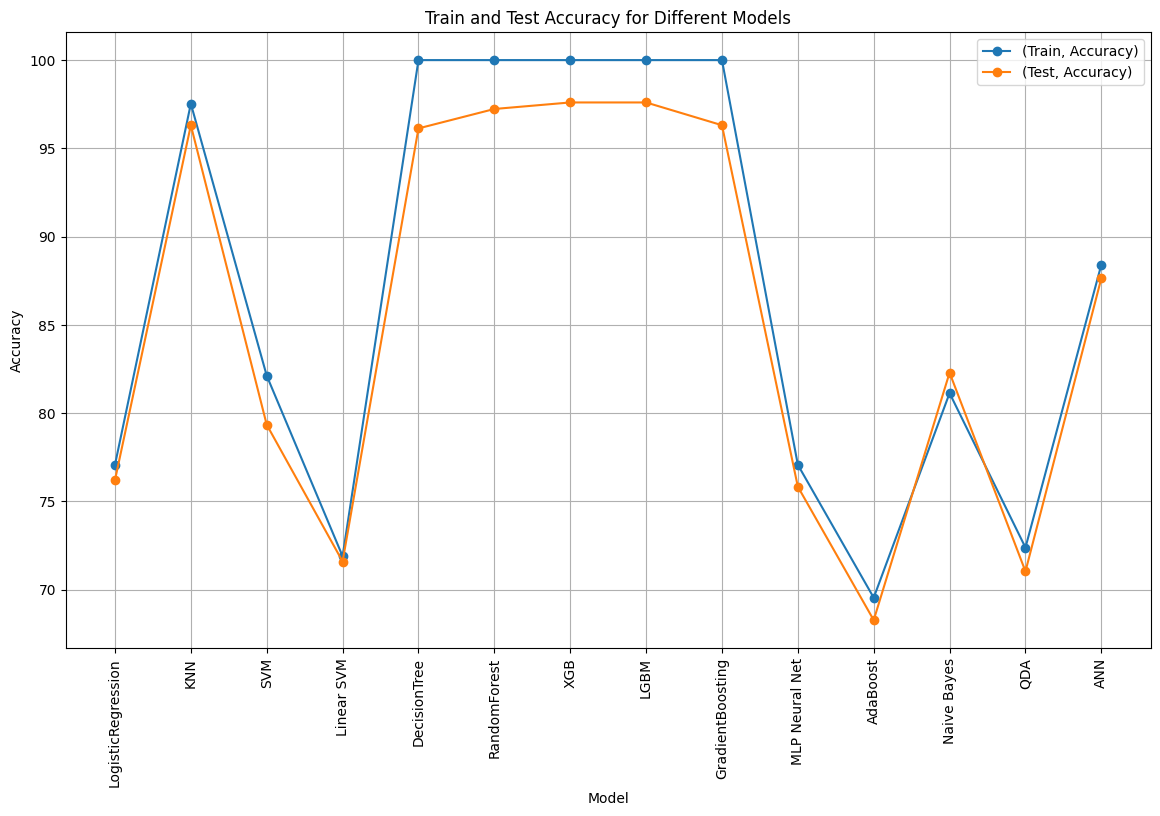

In [ ]:
metric_to_show = 'Accuracy'

tmp1.join(tmp2).loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(marker='o', figsize=(14, 8))
plt.title(f'Train and Test {metric_to_show} for Different Models')
plt.xlabel('Model')
plt.ylabel(metric_to_show)
plt.xticks(np.arange(len(tmp1.join(tmp2).columns.to_numpy())), tmp1.join(tmp2).columns.to_numpy(), rotation=90)
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
with open("/content/non_ac_classroom_hypertuned_models_object_40_test.pkl", "rb") as file:
    tmp3 = joblib.load(file)

tmp3 = evaluate_result(tmp3)

ob = torch.load("/content/non_ac_classroom_ann_model_object_40_test.pkl")
tmp4 = evaluate_ann(ob, *train_test_split(non_ac_classroom_x, non_ac_classroom_y, test_size=0.4, random_state=42))[1]


tmp3.join(tmp4)

LogisticRegression    KNN    SVM Linear SVM  \
      Metrics                                                          
Train Accuracy                        83.85  100.0  97.78      84.96   
      F1 Macro                        71.88  100.0  95.99      71.27   
      F1 Weighted                     82.38  100.0  97.78       82.6   
      Recall Macro                    70.01  100.0  95.95      71.08   
      Recall Weighted                 83.85  100.0  97.78      84.96   
      Precision Macro                  78.5  100.0  96.05       87.0   
      Precision Weighted              83.23  100.0  97.79      86.97   
Test  Accuracy                        80.81   95.2  95.57      83.39   
      F1 Macro                        68.97   92.3  92.94      69.71   
      F1 Weighted                     79.11  95.16  95.51      80.63   
      Recall Macro                    69.02  92.08  92.32      70.58   
      Recall Weighted                 80.81   95.2  95.57      83.39   
      Precision Macro                 74.75  92.54  93.69      84.74   
      Precision Weighted              80.73  95.13  95.53      86.05   

                         DecisionTree RandomForest    XGB   LGBM  \
      Metrics                                                      
Train Accuracy                  99.51        100.0  100.0  100.0   
      F1 Macro                  99.13        100.0  100.0  100.0   
      F1 Weighted               99.51        100.0  100.0  100.0   
      Recall Macro              99.01        100.0  100.0  100.0   
      Recall Weighted           99.51        100.0  100.0  100.0   
      Precision Macro           99.28        100.0  100.0  100.0   
      Precision Weighted        99.52        100.0  100.0  100.0   
Test  Accuracy                  96.13        97.42  97.23   97.6   
      F1 Macro                  93.97        95.75  95.57  95.98   
      F1 Weighted               96.11        97.41  97.23  97.58   
      Recall Macro              93.72        95.45  95.45  95.69   
      Recall Weighted           96.13        97.42  97.23   97.6   
      Precision Macro           94.48        96.07  95.71  96.31   
      Precision Weighted        96.23        97.41  97.23  97.58   

                         GradientBoosting MLP Neural Net AdaBoost Naive Bayes  \
      Metrics                                                                   
Train Accuracy                      100.0          99.51    67.45       83.48   
      F1 Macro                      100.0          98.89    55.33       77.79   
      F1 Weighted                   100.0          99.51    66.42       84.76   
      Recall Macro                  100.0          98.95    52.83       81.19   
      Recall Weighted               100.0          99.51    67.45       83.48   
      Precision Macro               100.0          98.87    63.59       79.05   
      Precision Weighted            100.0          99.52    71.07       89.74   
Test  Accuracy                      96.49          96.86    64.76        84.5   
      F1 Macro                      94.72          94.64    54.23       79.72   
      F1 Weighted                   96.49          96.86    63.45       85.75   
      Recall Macro                  94.62          94.36    52.03       82.21   
      Recall Weighted               96.49          96.86    64.76        84.5   
      Precision Macro               94.82          95.05    62.36       80.62   
      Precision Weighted            96.48          96.91    68.05       89.78   

                            QDA    ANN  
      Metrics                           
Train Accuracy            75.59  88.41  
      F1 Macro            59.82  79.12  
      F1 Weighted         73.27  88.35  
      Recall Macro         65.3  79.05  
      Recall Weighted     75.59  88.41  
      Precision Macro     61.57  80.14  
      Precision Weighted  77.17  88.74  
Test  Accuracy             73.8  87.64  
      F1 Macro            59.46  79.59  
      F1 Weighted         71.23  87

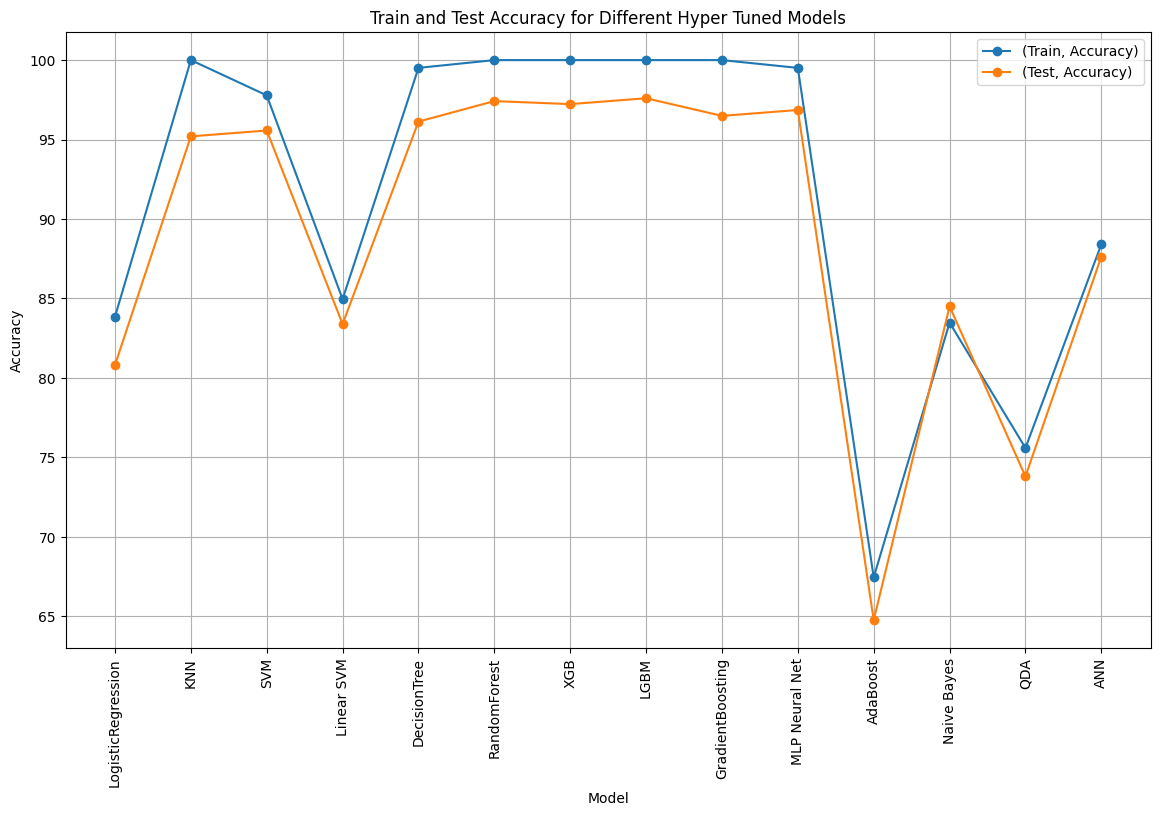

In [ ]:
metric_to_show = 'Accuracy'

tmp3.join(tmp4).loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(marker='o', figsize=(14, 8))
plt.title(f'Train and Test {metric_to_show} for Different Hyper Tuned Models')
plt.xlabel('Model')
plt.ylabel(metric_to_show)
plt.xticks(np.arange(len(tmp3.join(tmp4).columns.to_numpy())), tmp3.join(tmp4).columns.to_numpy(), rotation=90)
plt.legend(loc='best')
plt.grid(True)
plt.show()

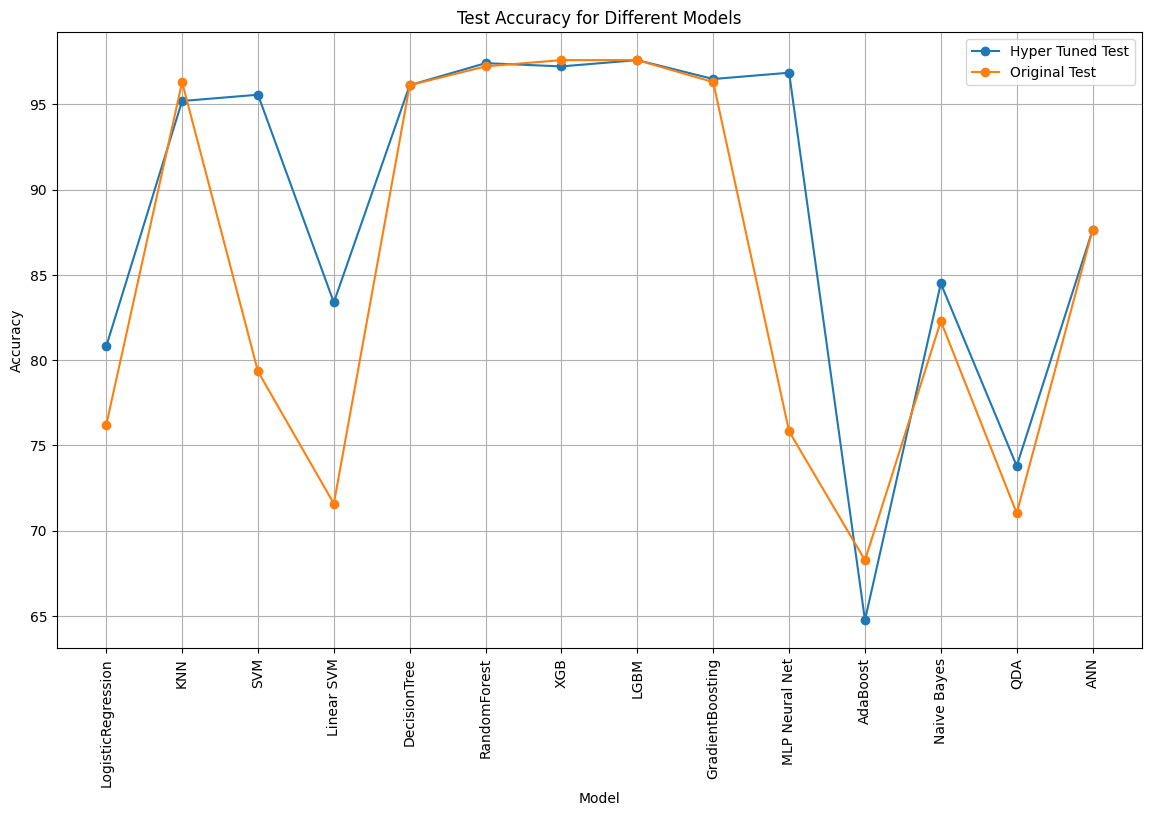

In [ ]:
metric_to_show = 'Accuracy'       # Accuracy, F1 Macro, F1 Weighted, Recall Macro, Recall Weighted, Precision Macro, Precision Weighted

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first set of data
# result_hyper_tuned.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8), title=f'Train and Test {metric_to_show} for Different Models')
tmp3.join(tmp4).loc[[('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8), title=f'Test {metric_to_show} for Different Models')

# Plot the second set of data
# result.loc[[('Train', metric_to_show), ('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8))
tmp1.join(tmp2).loc[[('Test', metric_to_show)]].T.plot(ax=ax, marker='o', figsize=(14, 8))

# Set labels, legends, and show the plot
ax.set_xlabel('Model')
ax.set_ylabel(metric_to_show)
ax.grid(True)
# ax.legend(['Hyper Tuned Train', 'Hyper Tuned Test', 'Original Train', 'Original Test'])
ax.legend(['Hyper Tuned Test', 'Original Test'])
plt.xticks(np.arange(len(tmp1.join(tmp2).columns.to_numpy())), tmp1.join(tmp2).columns.to_numpy(), rotation=90)
plt.show();

## Each Class Accuracy, Precision, Recall, F1 Score of Prediction

In [ ]:
def calculate_class_metrics(obj = None, confusion_matrix_ann = None):
    each_model_each_class_metrics = {}
    res = None
    epsilon = 1e-7  # small constant

    if obj is not None:
        for model in obj.model_names:
            confusion_matrix = obj.get_metric_scores(model)['Test Confusion Matrix']
            num_classes = len(confusion_matrix)
            class_metrics = {}

            for i in range(num_classes):
                TP = confusion_matrix[i, i]
                FP = sum(confusion_matrix[:, i]) - TP
                FN = sum(confusion_matrix[i, :]) - TP
                total_samples = TP + FP + FN

                accuracy = TP / (total_samples + epsilon)
                precision = TP / (TP + FP + epsilon)
                recall = TP / (TP + FN + epsilon)
                f1_score = 2 * (precision * recall) / (precision + recall + epsilon)

                class_metrics[f'Class {i}'] = {'Accuracy (%)': round(accuracy * 100.00, 2), 'Precision (%)': round(precision * 100.00, 2), 'Recall (%)': round(recall * 100.00, 2), 'F1 Score (%)': round(f1_score * 100.00, 2)}
            each_model_each_class_metrics[model] = class_metrics

    if confusion_matrix_ann is not None:
        num_classes = len(confusion_matrix_ann)
        class_metrics = {}
        for i in range(num_classes):
            TP = confusion_matrix_ann[i, i]
            FP = sum(confusion_matrix_ann[:, i]) - TP
            FN = sum(confusion_matrix_ann[i, :]) - TP
            total_samples = TP + FP + FN

            accuracy = TP / (total_samples + epsilon)
            precision = TP / (TP + FP + epsilon)
            recall = TP / (TP + FN + epsilon)
            f1_score = 2 * (precision * recall) / (precision + recall + epsilon)

            class_metrics[f'Class {i}'] = {'Accuracy (%)': round(accuracy * 100.00, 2), 'Precision (%)': round(precision * 100.00, 2), 'Recall (%)': round(recall * 100.00, 2), 'F1 Score (%)': round(f1_score * 100.00, 2)}
        each_model_each_class_metrics['ANN'] = class_metrics

    for model_name in each_model_each_class_metrics:
        tmp = pd.DataFrame(each_model_each_class_metrics[model_name]).T.stack(0).reset_index().rename(columns = {'level_0': 'Class', 'level_1': 'Attributes', 0: model_name}).set_index(['Class', 'Attributes'], drop = True)
        if res is None:
            res = tmp
        else:
            res = res.join(tmp, how='outer')

    return res

In [ ]:
with open("/content/ac_lab_hypertuned_models_object_40_test.pkl", "rb") as file:
    tmp1 = joblib.load(file)

tmp2 = evaluate_ann(torch.load("/content/ac_lab_ann_model_object_40_test.pkl"),
                    *train_test_split(ac_lab_x, ac_lab_y, test_size=0.4, random_state=42))[0]['Test Confusion Matrix']

calculate_class_metrics(tmp1, tmp2)

In [ ]:
with open("/content/ac_classroom_hypertuned_models_object_40_test.pkl", "rb") as file:
    tmp1 = joblib.load(file)

tmp2 = evaluate_ann(torch.load("/content/ac_classroom_ann_model_object_40_test.pkl"),
                    *train_test_split(ac_classroom_x, ac_classroom_y, test_size=0.4, random_state=42))[0]['Test Confusion Matrix']

calculate_class_metrics(tmp1, tmp2)
# calculate_class_accuracy(tmp1, tmp2).query("Attributes == 'Accuracy (%)'")

In [ ]:
with open("/content/non_ac_classroom_hypertuned_models_object_40_test.pkl", "rb") as file:
    tmp1 = joblib.load(file)

tmp2 = evaluate_ann(torch.load("/content/non_ac_classroom_ann_model_object_40_test.pkl"),
                    *train_test_split(non_ac_classroom_x, non_ac_classroom_y, test_size=0.4, random_state=42))[0]['Test Confusion Matrix']

calculate_class_metrics(tmp1, tmp2)
# calculate_class_accuracy(tmp1, tmp2).query("Attributes == 'Accuracy (%)'")